# SURE 2024 Speedy Simulations Kickoff
## Kernel Density Estimation with Quasi-Monte Carlo Methods

This demo makes use of our QMCPy software package.  See [qmcpy.org](www.qmcpy.org) for more details.

### Those involved in this project are
- Fred J. Hickernell
- [add your names here]
- Aiwen Li
- Richard Varela
- Luke Bielawski

### If you are running this on colab, run this cell below
### If you running this in Jupyter notebook and you have the environment set up, ignore this cell below

In [ ]:
# If you are running this on colab
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!sudo apt install cm-super
!pip install git+https://github.com/QMCSoftware/QMCSoftware.git@SURE2024

### Import needed packages

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from copy import deepcopy
import sympy as sy
import sympy.stats
figpath = '' #this path sends the figures to the directory that you want
savefigs = True  #save the figures on your disk if True
imgfrmt = 'pdf' #kind of format to save figures as

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

## Examples of ways to spread points on a hypercube

### Evenly spaced points in one dimension $(d=1)$
In one dimension it is easy to spread points evenly

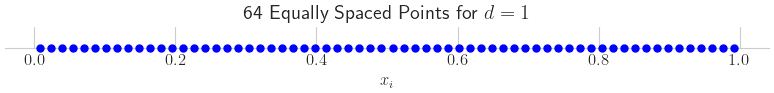

In [67]:
n = 64
xpts = np.linspace(1/(2*n), 1-1/(2*n), n) #equally spaced points between 0 and 1
fig, ax = plt.subplots()
ax.plot(xpts, np.zeros_like(xpts), 'b.', markersize = 10, zorder=10, clip_on=False) 
ax.set_ylim([0, 3e-2])
ax.set_title(f"{n:.0f} Equally Spaced Points for $d=1$")
ax.set_xlabel("$x_i$")
ax.set_aspect(1)
ax.axes.get_yaxis().set_visible(False)  #turn off the tics on the vertical axis
ax.spines[['top','right','left']].set_visible(False)  #turn off the bounding box on the top and sides
# if savefigs:
#     fig.savefig(figpath+f"{n:.0f}equallyspacedpts."+imgfrmt,format=imgfrmt)

### Grids in dimension $d$
Our natural thought for higher dimensions is to use rectangular grids, but as the dimension, $d$, increases, the number of different values per coordinate decreases drastically.

In [4]:
def make_grid(d=3,nper=2):  #this function creates a nper^d x d matrix of grid points
    xpts = np.linspace(1/(2*nper), 1.0-1/(2*nper), nper)  #array of coordinate values
    xgrid = xpts  #initial grid
    n = nper  #initial length of grid
    for ii in range(1,d):
        xgrid0 = xgrid  #store the old grid
        xgrid = np.vstack((xgrid0,xpts[0]*np.ones((1,n))))  #stack the next coordinate
        for jj in range(1,nper):
            xgrid = np.hstack((xgrid,np.vstack((xgrid0,xpts[jj]*np.ones((1,n))))))
        n = n*nper  #update the length of the grid
    return xgrid.T  #take the transpose to that coordinates are columns

def plot_grid(xgrid, coord_to_plot = [0, 1], savefig = True, figpath = ''):
    n = xgrid.shape[0]
    d = xgrid.shape[1]
    coord_to_plot = np.minimum(coord_to_plot,[d,d]), #ensure that they are no more than d
    coord_to_plot = coord_to_plot[0]
    coord_to_plot = np.maximum(coord_to_plot,[1,1]), #ensure that they are no less than 1
    coord_to_plot = coord_to_plot[0]
    fig, ax = plt.subplots()
    ax.plot(xgrid[:,coord_to_plot[0]-1], xgrid[:,coord_to_plot[1]-1], 'b.', markersize = 10, zorder=10, clip_on=False) 
    ax.set_title(f"{n:.0f} Grid Points for $d = ${d:.0f}")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel(r'$x_{i%d}$'%(coord_to_plot[0]),fontsize=14)
    ax.set_ylabel(r'$x_{i%d}$'%(coord_to_plot[1]),fontsize=14)
    ax.set_aspect(1)
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}gridpts_d{d:.0f}."+imgfrmt,format=imgfrmt)


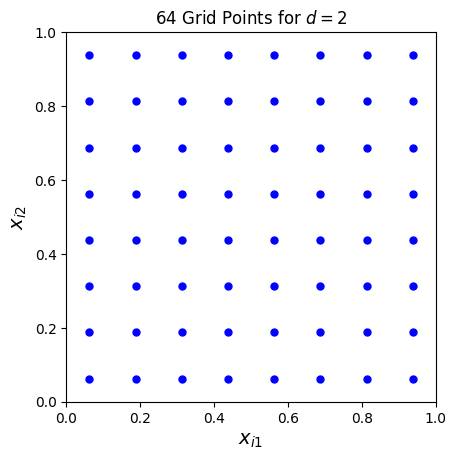

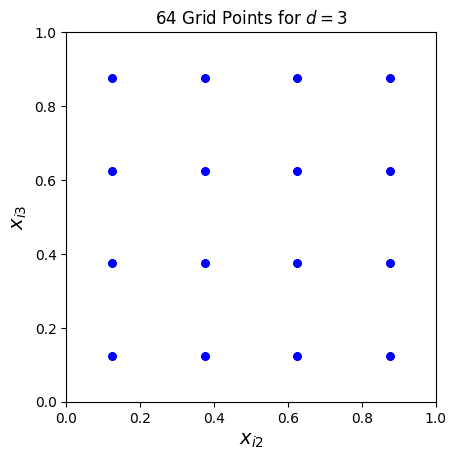

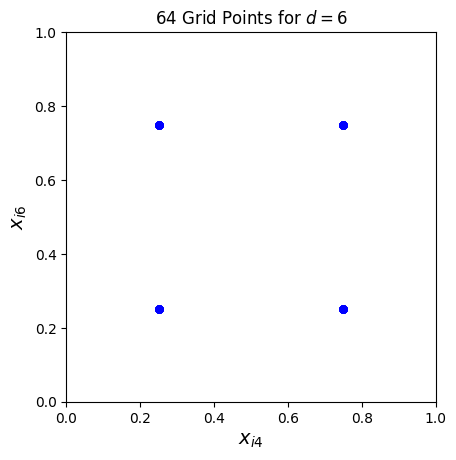

In [4]:
plot_grid(make_grid(2,8), [1,2], savefigs, figpath)
plot_grid(make_grid(3,4), [2,3], savefigs, figpath)
plot_grid(make_grid(6,2), [4,6], savefigs, figpath)

### Independent and identically distributed (IID) points
Since grids are bad, we can use IID points instead.  Note how they fill space better.

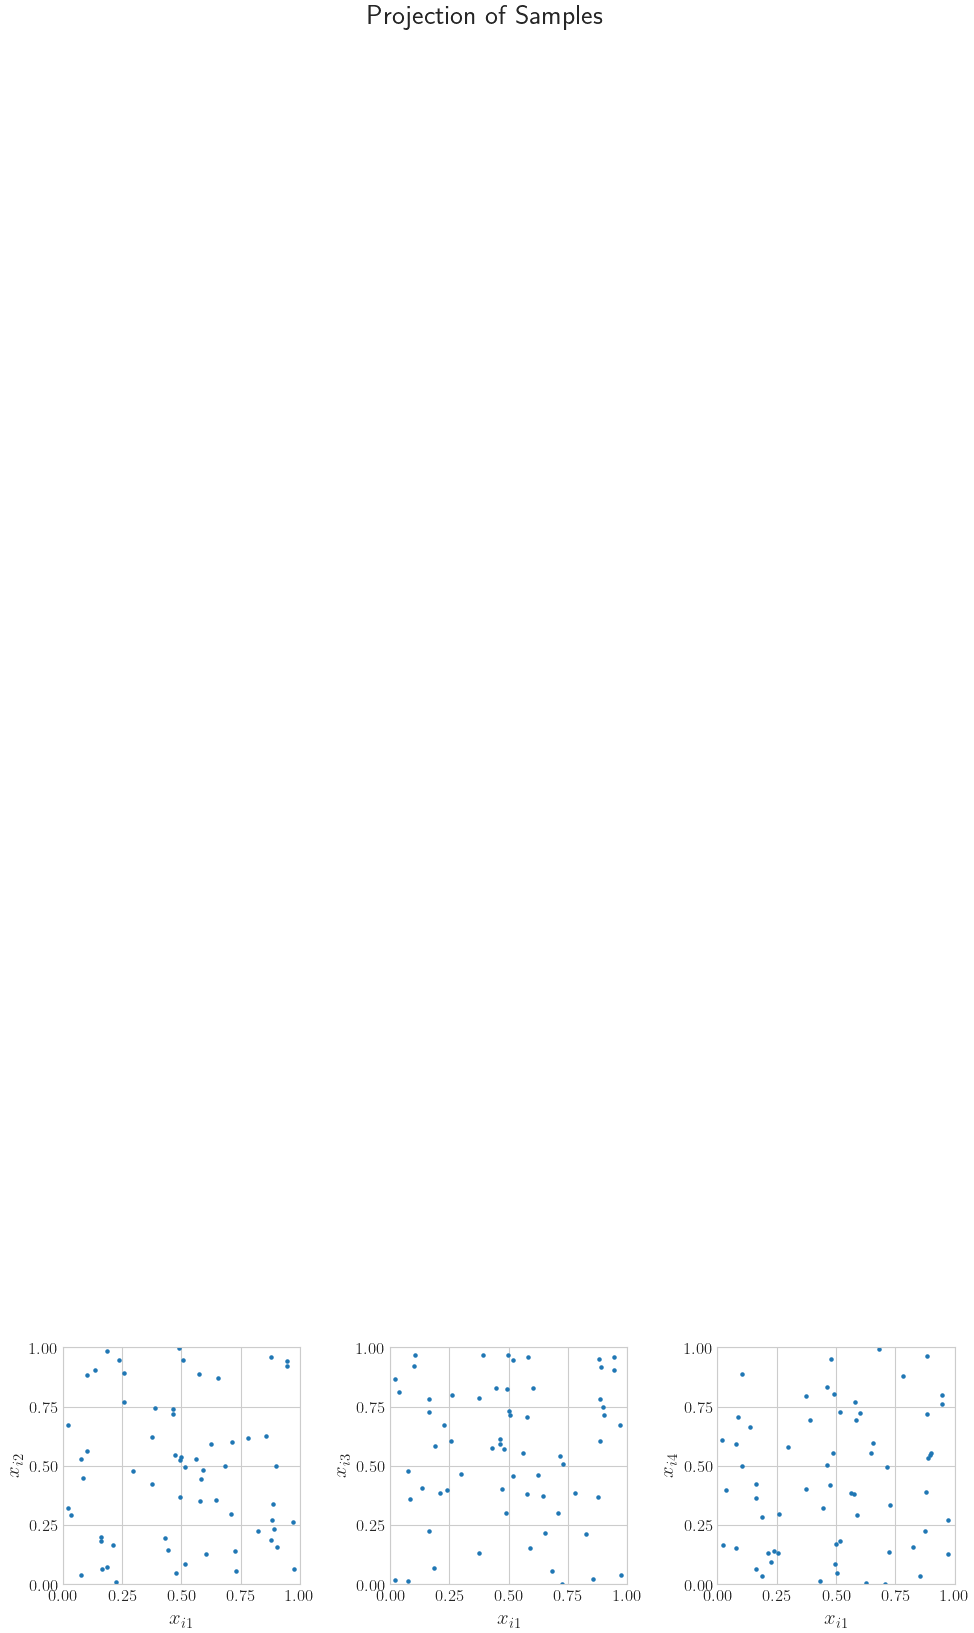

In [61]:
d = 6  #the dimension used for these examples
n = 64  #the sample size used for these examples
fig,ax = qp.plot_proj(qp.IIDStdUniform(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
if savefigs:
        fig.savefig(figpath+f"{n:.0f}iidpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

### Low disrepancy points
There are several kinds of low discrepancy points, includng Sobol', lattice, and Halton.  Below we display one kind.

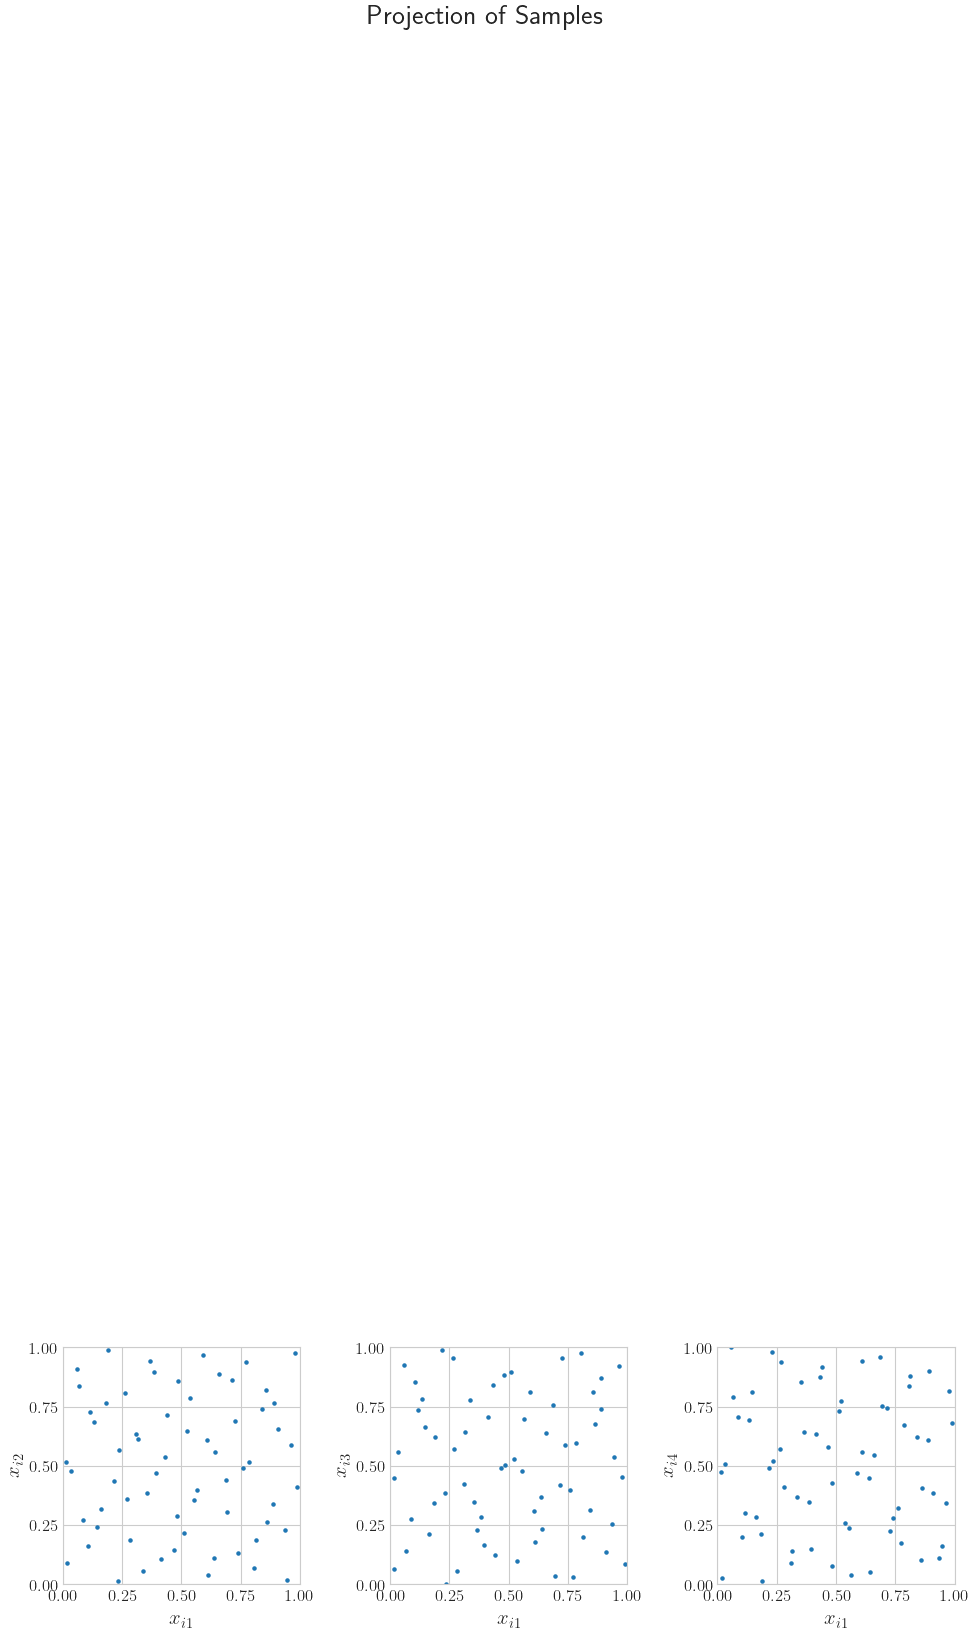

In [62]:
fig,ax = qp.plot_proj(qp.Sobol(d), n, d_horizontal = 1, d_vertical = np.arange(2,5), figfac = 10)
    #d_horizontal and d_vertical are the tuples of coordinates to plot
if savefigs:
        fig.savefig(figpath+f"{n:.0f}sobolpts_d{d:.0f}."+imgfrmt,format=imgfrmt)

## Kernel Density Estimation

### Gaussian kernel

In [5]:
def kernel(y):
    return np.exp(-y*y)/np.sqrt(np.pi)

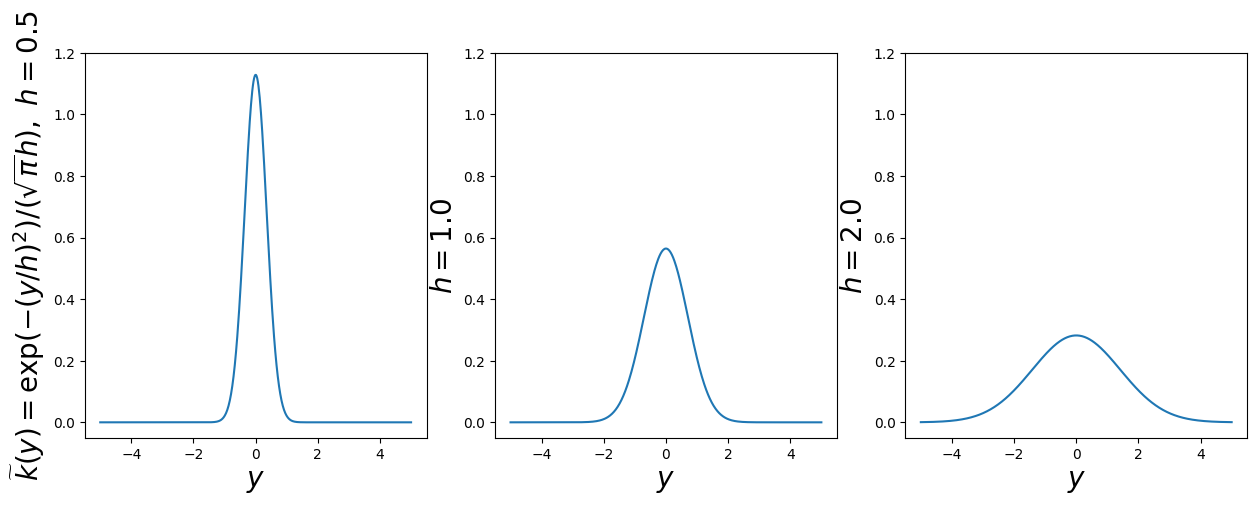

In [6]:
ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.05, 1.2])
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = \exp(-(y/h)^2)/(\sqrt{\pi}h), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
if savefigs:
        fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

### Numerical experiment

#### Generate some $\vx_i$

In [7]:
# dim = 1
d = 1
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts1 = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts1)
wtiidpts1 = np.multiply(iidpts1,coord_wts)
print(wtiidpts1)
sobpts1 = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts1)

iid pts [[0.3052683 ]
 [0.08436528]
 [0.95625571]
 ...
 [0.20545227]
 [0.37400041]
 [0.37873874]]
[[0.3052683 ]
 [0.08436528]
 [0.95625571]
 ...
 [0.20545227]
 [0.37400041]
 [0.37873874]]
sobol pts [[0.82400596]
 [0.2132472 ]
 [0.50133495]
 ...
 [0.0663381 ]
 [0.64934792]
 [0.25926172]]


In [8]:
# dim = 3
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts3 = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts3)
wtiidpts3 = np.multiply(iidpts3,coord_wts)
print(wtiidpts3)
sobpts3 = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts3)

iid pts [[0.11738818 0.17101631 0.22439307]
 [0.77446947 0.49757195 0.89453853]
 [0.62273608 0.87621515 0.76385742]
 ...
 [0.61016251 0.31356093 0.74617514]
 [0.74583626 0.73863424 0.58631605]
 [0.48361565 0.14555625 0.95652857]]
[[0.11738818 0.08550815 0.05609827]
 [0.77446947 0.24878597 0.22363463]
 [0.62273608 0.43810758 0.19096436]
 ...
 [0.61016251 0.15678047 0.18654378]
 [0.74583626 0.36931712 0.14657901]
 [0.48361565 0.07277813 0.23913214]]
sobol pts [[0.41707926 0.13774812 0.96997093]
 [0.8897928  0.70687815 0.35806013]
 [0.17214432 0.75707332 0.04273472]
 ...
 [0.7735188  0.84178306 0.03952768]
 [0.03853628 0.63387119 0.35655223]
 [0.50319298 0.21075268 0.97166194]]


In [25]:
# dim = 1, increase n to 2**14
d = 1
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**14
many_iidpts1 = qp.IIDStdUniform(d).gen_samples(n)
print("many iid pts",many_iidpts1)
many_wtiidpts1 = np.multiply(many_iidpts1,coord_wts)
print(many_wtiidpts1)
many_sobpts1 = qp.Sobol(d).gen_samples(n)
print("many sobol pts",many_sobpts1)

many iid pts [[0.23048961]
 [0.63629079]
 [0.49214649]
 ...
 [0.89765457]
 [0.5378931 ]
 [0.27185994]]
[[0.23048961]
 [0.63629079]
 [0.49214649]
 ...
 [0.89765457]
 [0.5378931 ]
 [0.27185994]]
many sobol pts [[0.67669319]
 [0.45946201]
 [0.86268462]
 ...
 [0.35126982]
 [0.94011658]
 [0.15649344]]


In [26]:
# dim = 3, increase n to 2**14
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**14
many_iidpts3 = qp.IIDStdUniform(d).gen_samples(n)
print("many iid pts",many_iidpts3)
many_wtiidpts3 = np.multiply(many_iidpts3,coord_wts)
print(wtiidpts3)
many_sobpts3 = qp.Sobol(d).gen_samples(n)
print("many sobol pts",many_sobpts3)

many iid pts [[0.29733714 0.12361949 0.50402999]
 [0.3295621  0.00164779 0.95420119]
 [0.71566795 0.38895518 0.1373859 ]
 ...
 [0.58818398 0.77220344 0.95767586]
 [0.0591013  0.22545325 0.43203542]
 [0.31312442 0.24538649 0.43604824]]
[[0.11738818 0.08550815 0.05609827]
 [0.77446947 0.24878597 0.22363463]
 [0.62273608 0.43810758 0.19096436]
 ...
 [0.61016251 0.15678047 0.18654378]
 [0.74583626 0.36931712 0.14657901]
 [0.48361565 0.07277813 0.23913214]]
many sobol pts [[0.76075905 0.46213886 0.19409441]
 [0.47600916 0.60931768 0.8879462 ]
 [0.69219594 0.97330367 0.70012517]
 ...
 [0.30712477 0.53161818 0.88722925]
 [0.52526515 0.91721264 0.70035379]
 [0.23995022 0.02925059 0.38150359]]


In [36]:
# dim = 1, decrease n to 2**10
d = 1
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**10
few_iidpts1 = qp.IIDStdUniform(d).gen_samples(n)
print("few iid pts",few_iidpts1)
few_wtiidpts1 = np.multiply(few_iidpts1,coord_wts)
print(few_wtiidpts1)
few_sobpts1 = qp.Sobol(d).gen_samples(n)
print("few sobol pts",few_sobpts1)

few iid pts [[0.67576961]
 [0.77208945]
 [0.36883141]
 ...
 [0.01934854]
 [0.57148006]
 [0.82213321]]
[[0.67576961]
 [0.77208945]
 [0.36883141]
 ...
 [0.01934854]
 [0.57148006]
 [0.82213321]]
few sobol pts [[0.41824124]
 [0.95996428]
 [0.04148027]
 ...
 [0.77250817]
 [0.22896309]
 [0.6417952 ]]


In [37]:
# dim = 3, decrease n to 2**10
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**10
few_iidpts3 = qp.IIDStdUniform(d).gen_samples(n)
print("few iid pts",few_iidpts3)
few_wtiidpts3 = np.multiply(few_iidpts3,coord_wts)
print(few_wtiidpts3)
few_sobpts3 = qp.Sobol(d).gen_samples(n)
print("few sobol pts",few_sobpts3)

few iid pts [[0.00095323 0.4643031  0.08411791]
 [0.14160152 0.0967792  0.00192757]
 [0.57190078 0.41588413 0.66238986]
 ...
 [0.10284084 0.65609767 0.91977003]
 [0.61224853 0.60675198 0.41979546]
 [0.53557573 0.60316157 0.25761379]]
[[9.53233497e-04 2.32151552e-01 2.10294779e-02]
 [1.41601517e-01 4.83895976e-02 4.81891873e-04]
 [5.71900781e-01 2.07942064e-01 1.65597466e-01]
 ...
 [1.02840841e-01 3.28048835e-01 2.29942508e-01]
 [6.12248533e-01 3.03375992e-01 1.04948864e-01]
 [5.35575725e-01 3.01580783e-01 6.44034473e-02]]
few sobol pts [[0.98159493 0.81794659 0.71822451]
 [0.03377349 0.41089376 0.11026389]
 [0.71728439 0.02929069 0.44974178]
 ...
 [0.16499387 0.40904192 0.99054369]
 [0.58214736 0.02724014 0.57245274]
 [0.40202647 0.74483598 0.2242974 ]]


#### Generate some $y_i=f(x_i)$ points
$
f(\vx) = 10 \exp(- w_1x_1 - \cdots - w_d x_d) \sin(w_1x_1 + \cdots +w_d x_d)
$

In [9]:
def testfun1(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    #y = x[:,0] # if x is uniform, then y is uniform
    return y

In [10]:
yiid1 = testfun1(iidpts1)
ysob1 = testfun1(sobpts1)

yiid3 = testfun1(iidpts3)
ysob3 = testfun1(sobpts3)

In [27]:
many_yiid1 = testfun1(many_iidpts1)
many_ysob1 = testfun1(many_sobpts1)

many_yiid3 = testfun1(many_iidpts3)
many_ysob3 = testfun1(many_sobpts3)

In [34]:
few_yiid1 = testfun1(few_iidpts1)
few_ysob1 = testfun1(few_sobpts1)

few_yiid3 = testfun1(few_iidpts3)
few_ysob3 = testfun1(few_sobpts3)

#### Construct a kernel density estimator

In [11]:
def kde(kernel,ypts,bandwidth,yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts)/bandwidth))/bandwidth
    return rhoval

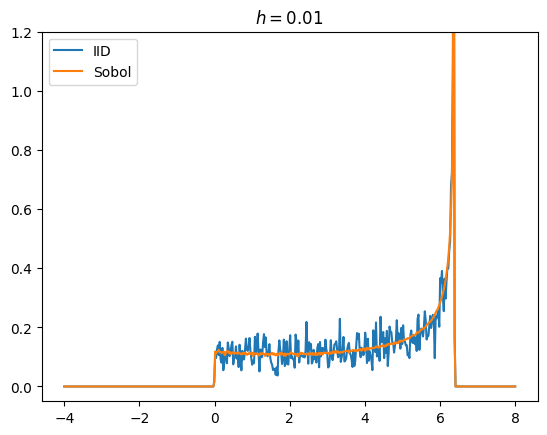

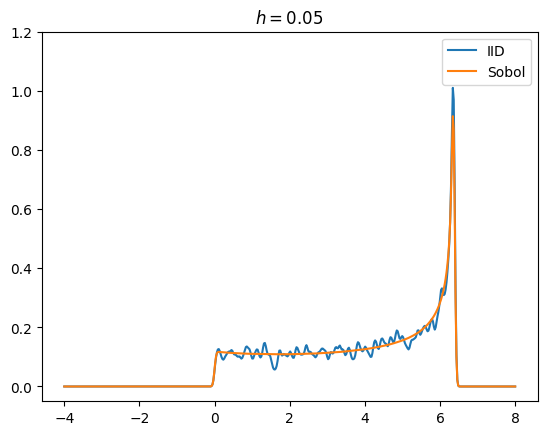

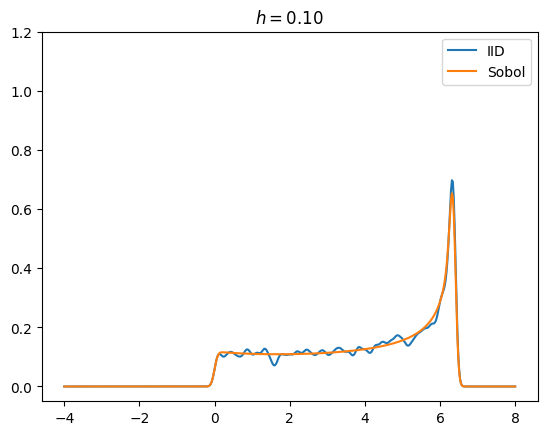

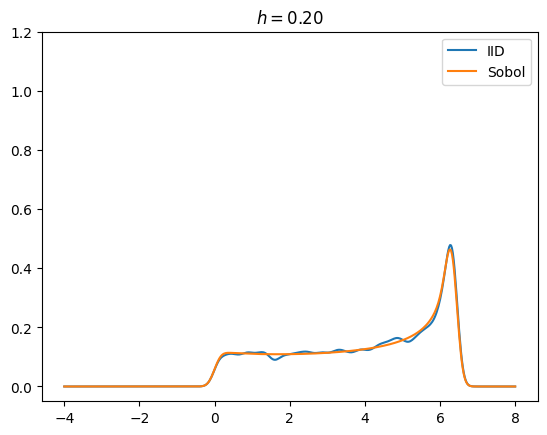

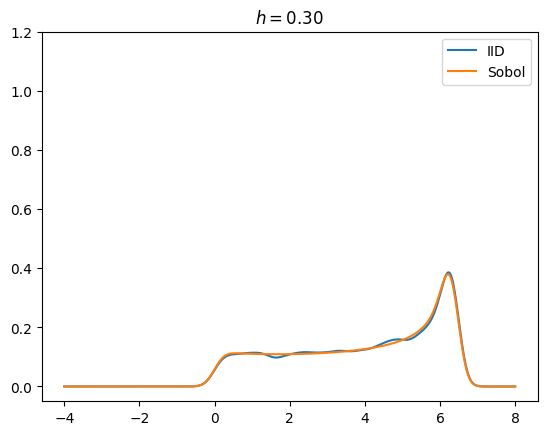

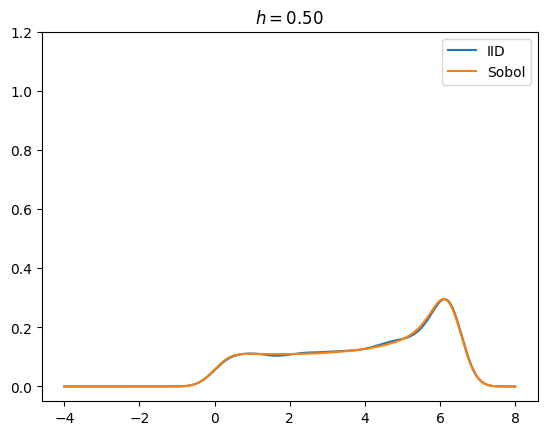

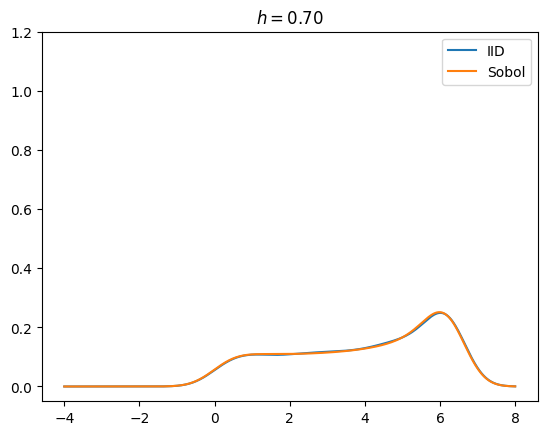

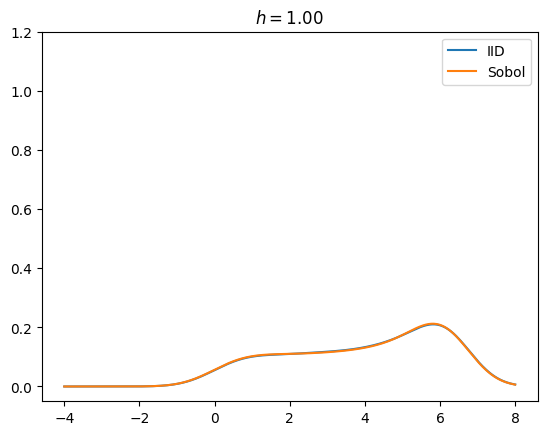

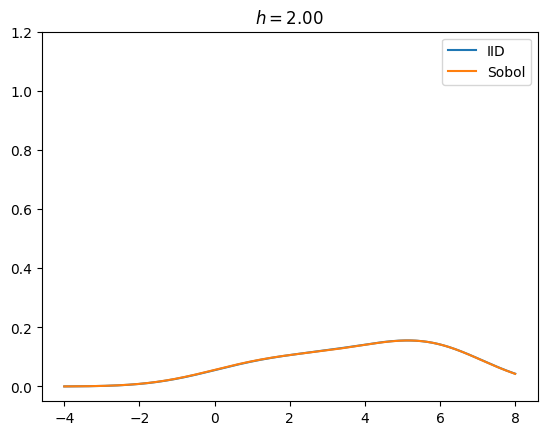

In [19]:
# dim = 1
bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

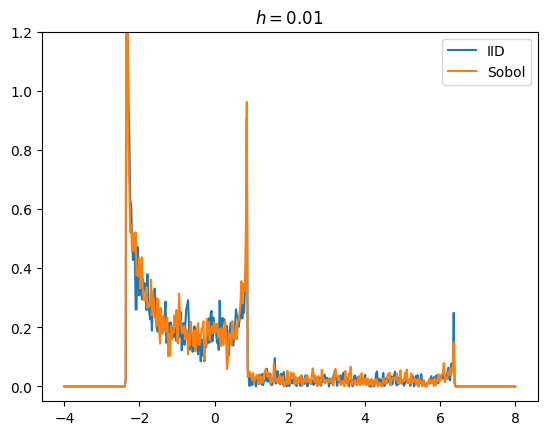

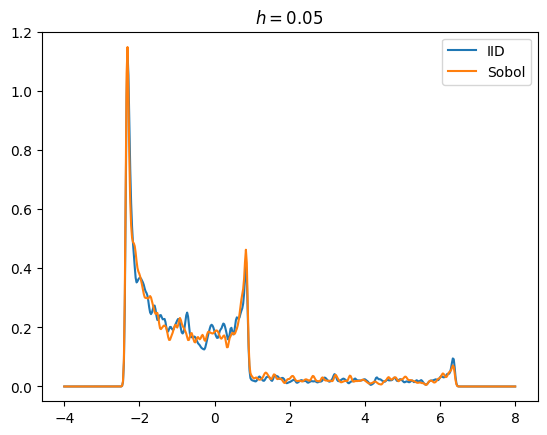

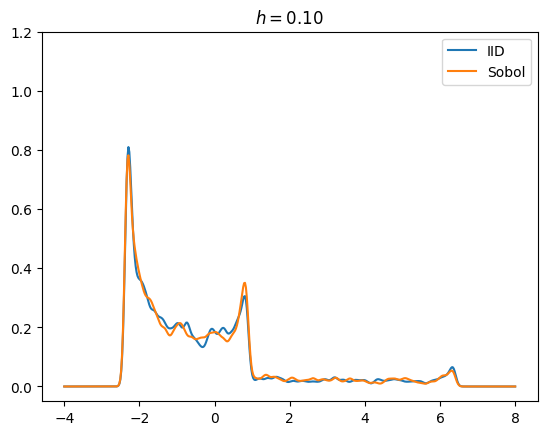

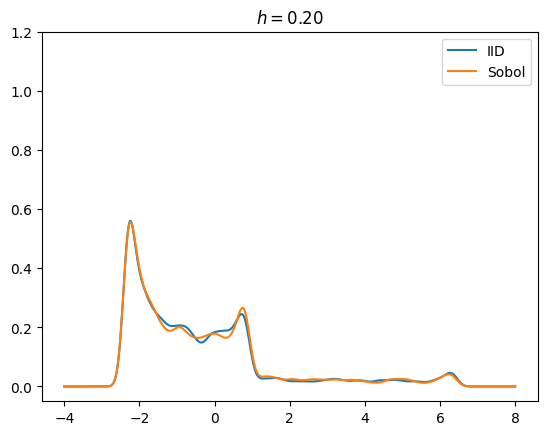

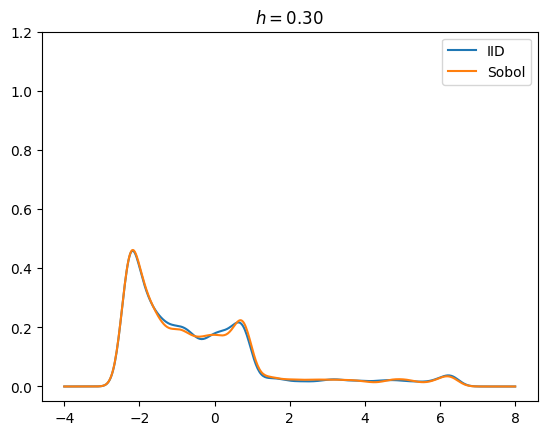

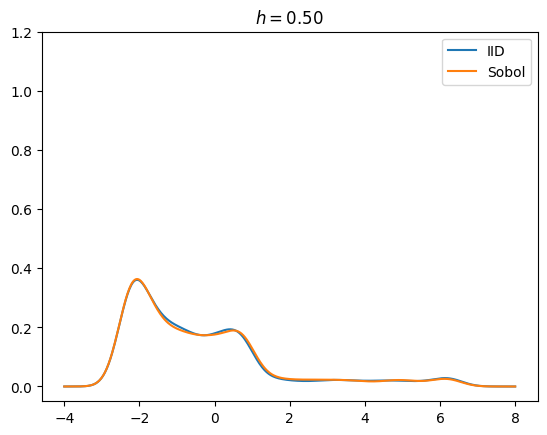

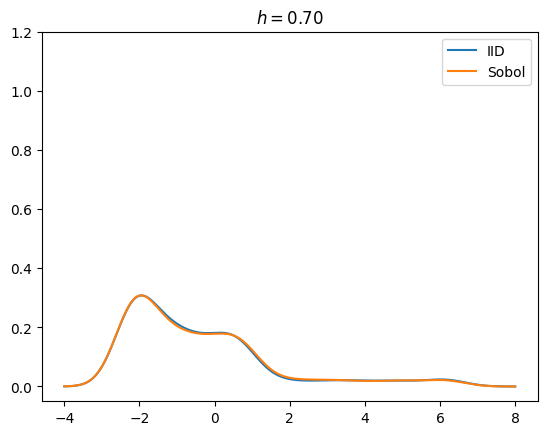

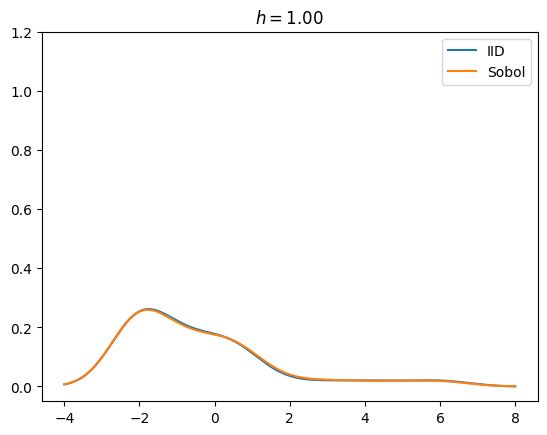

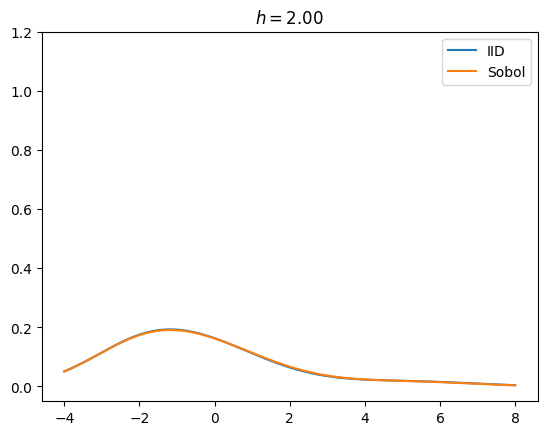

In [20]:
# dim = 3

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

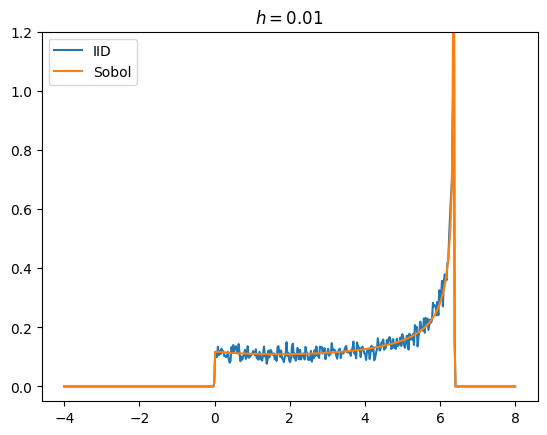

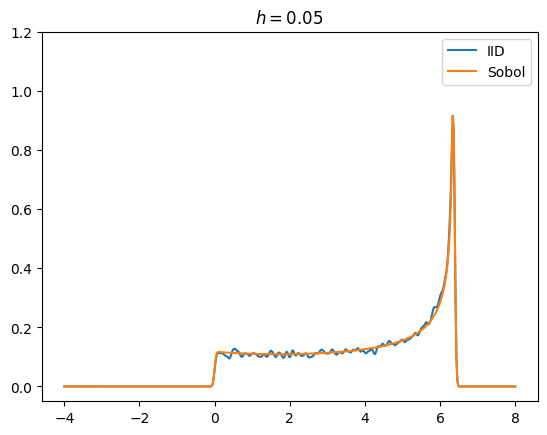

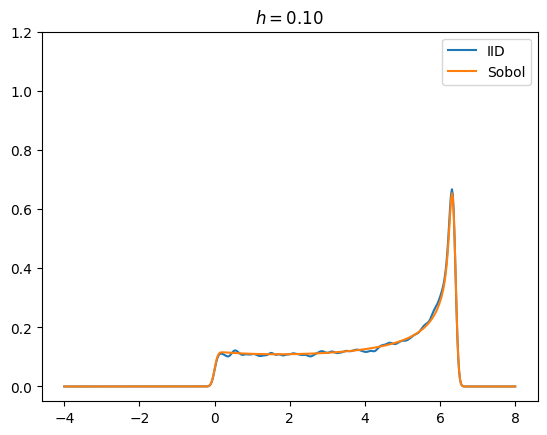

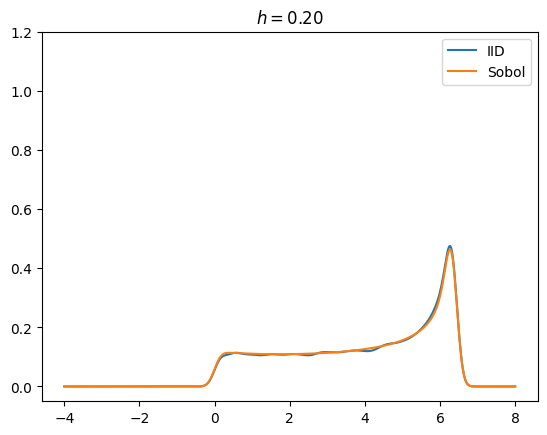

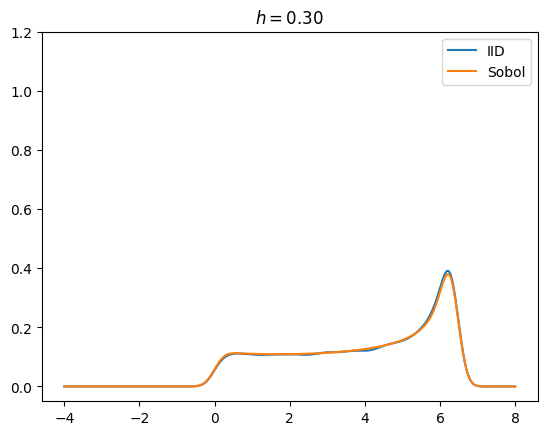

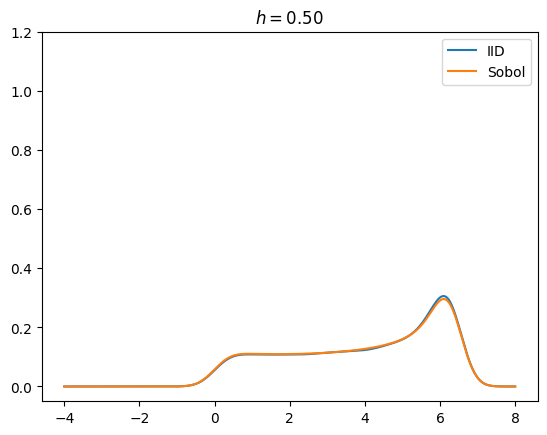

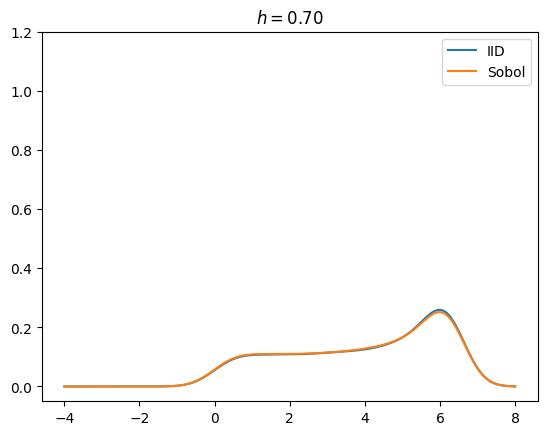

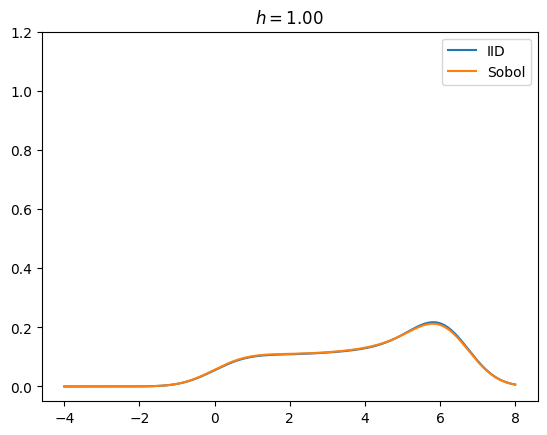

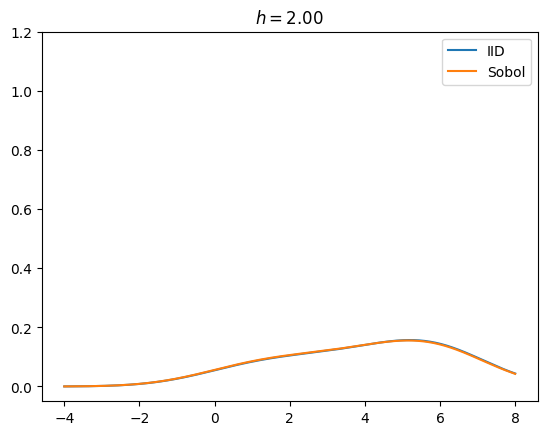

In [28]:
# dim = 1, many points (n = 2**14)
bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,many_yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,many_ysob1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

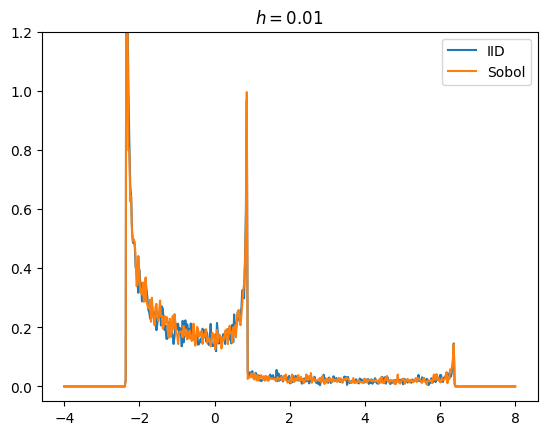

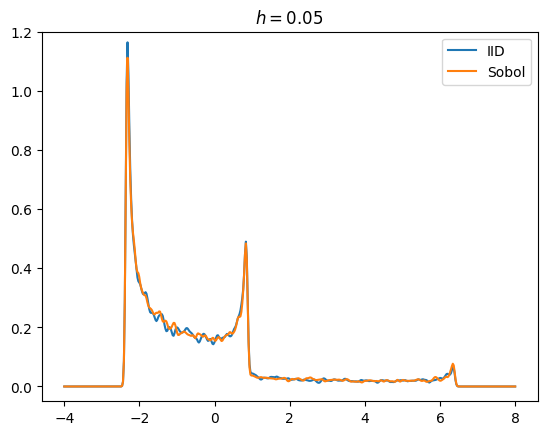

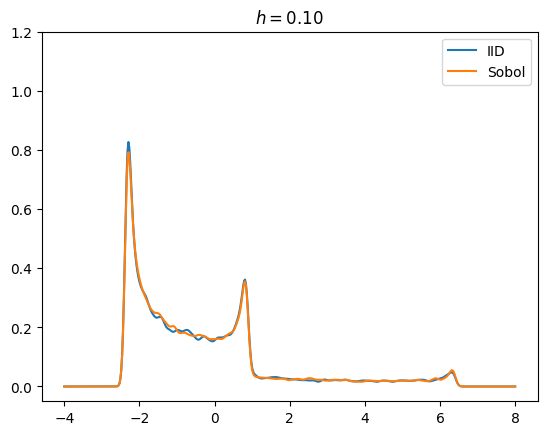

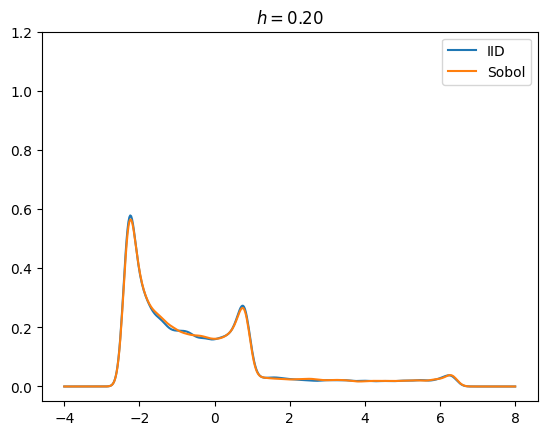

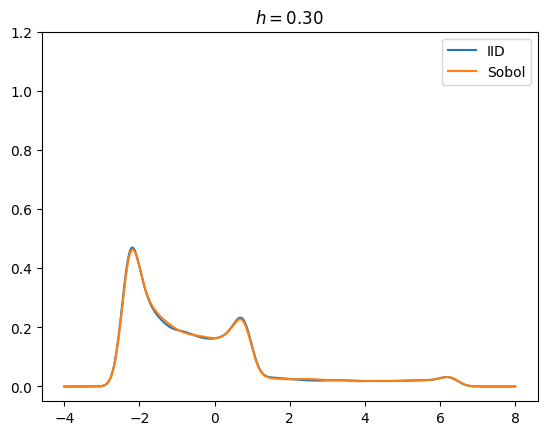

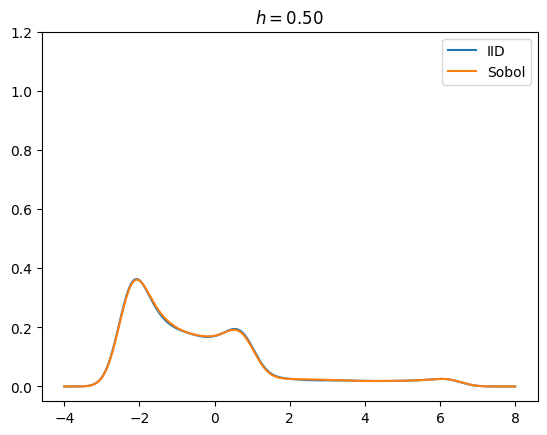

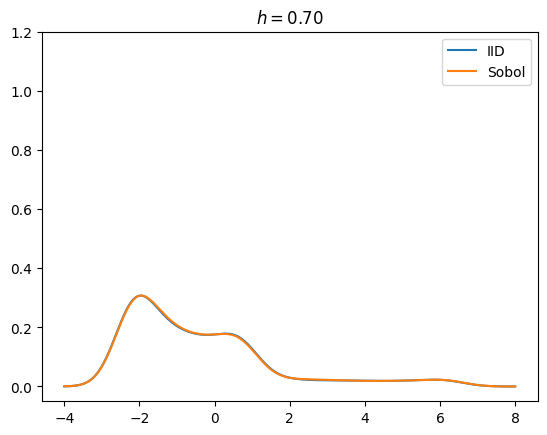

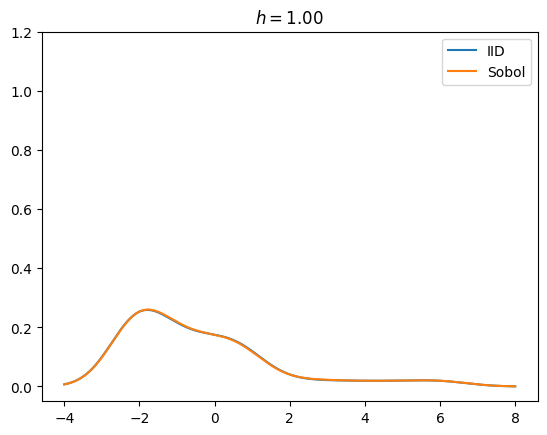

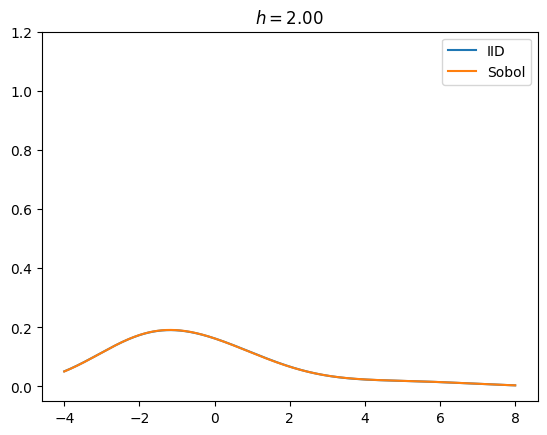

In [29]:
# dim = 3, many points (n = 2**14)

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,many_yiid3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,many_ysob3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

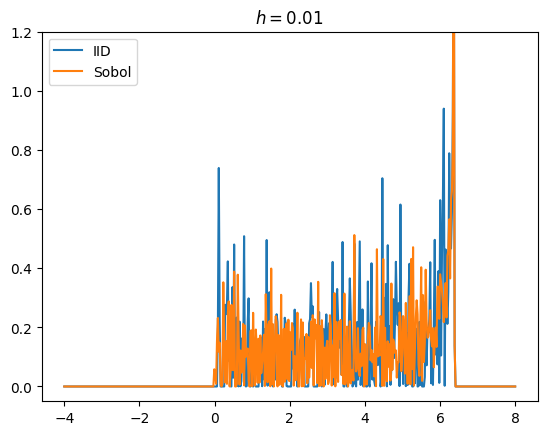

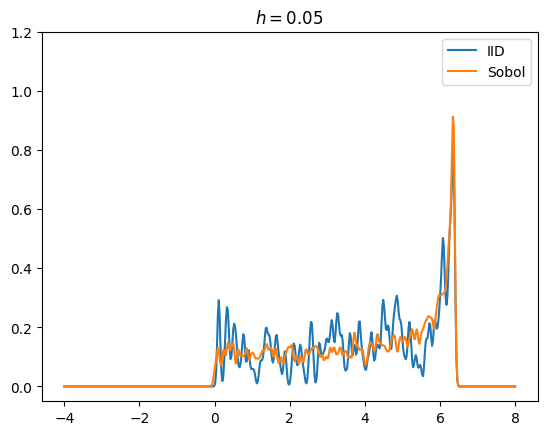

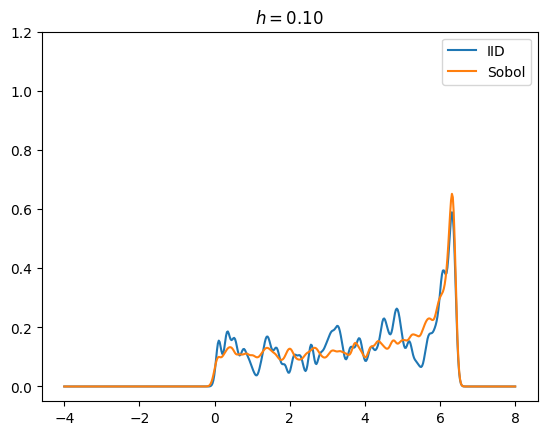

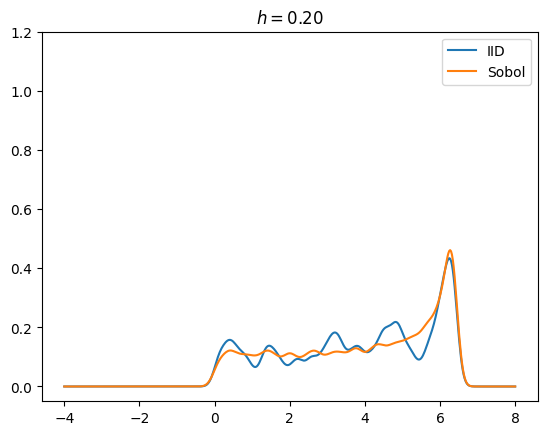

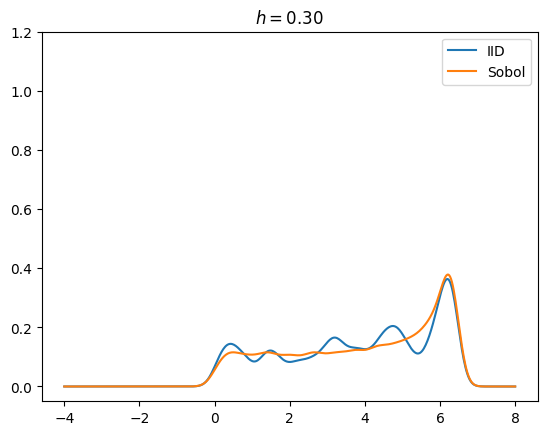

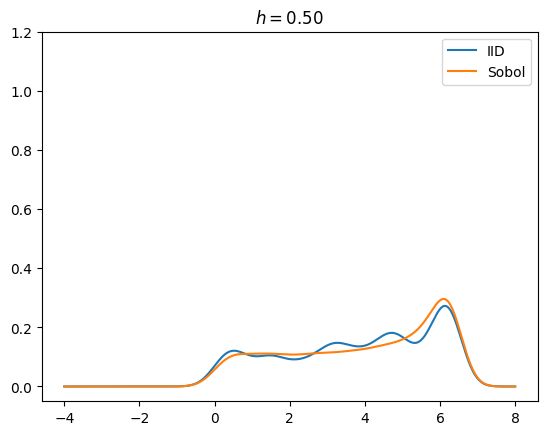

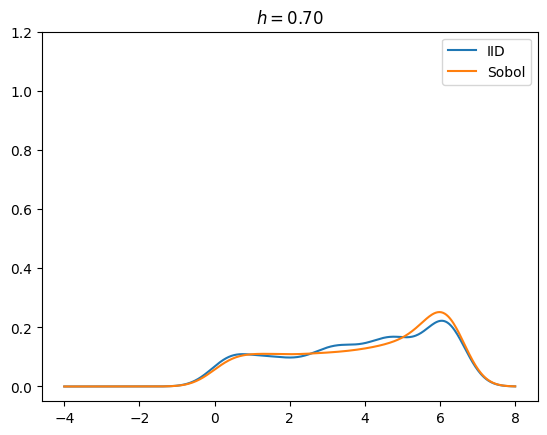

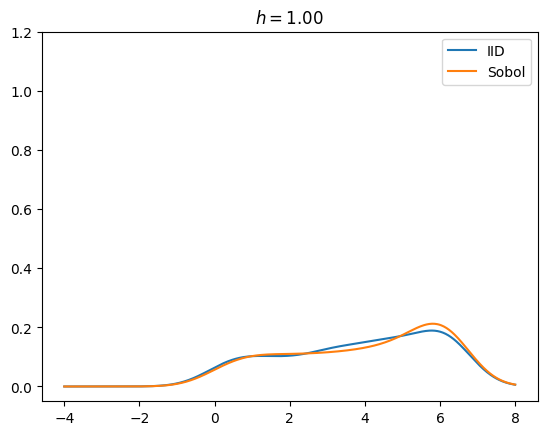

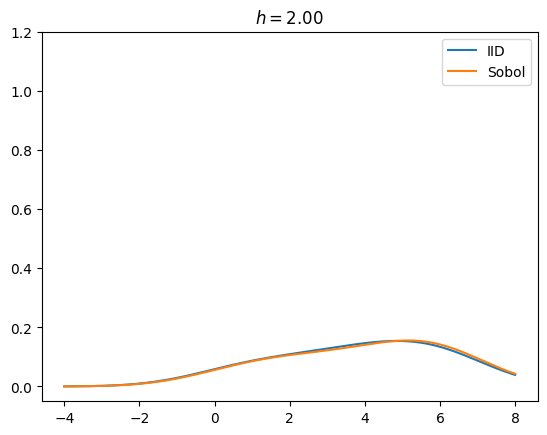

In [38]:
# dim = 1, decrease n to 2**10
bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,few_yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,few_ysob1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

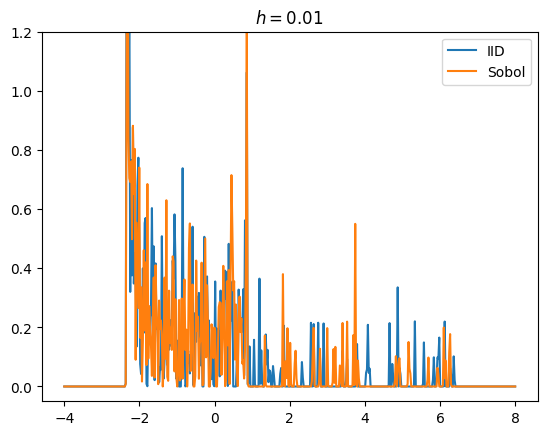

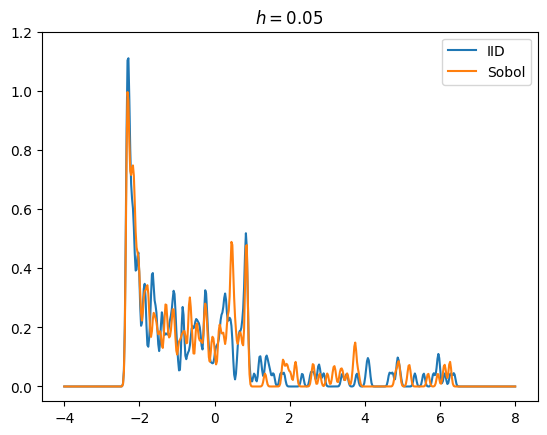

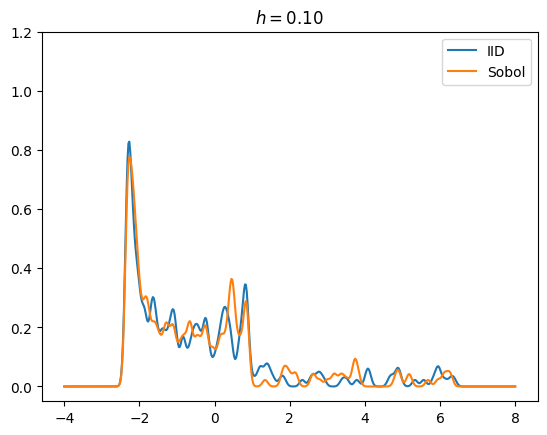

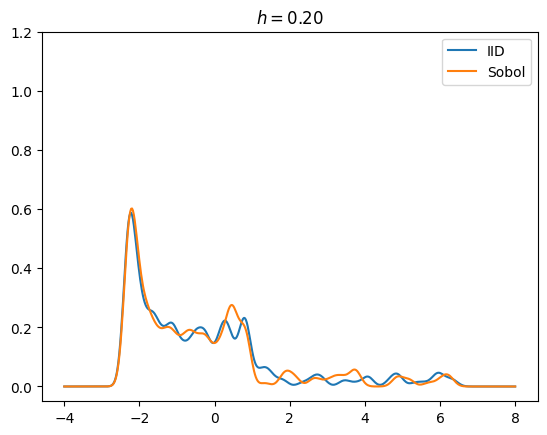

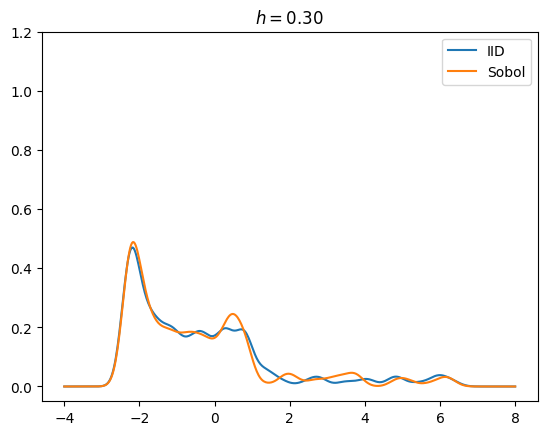

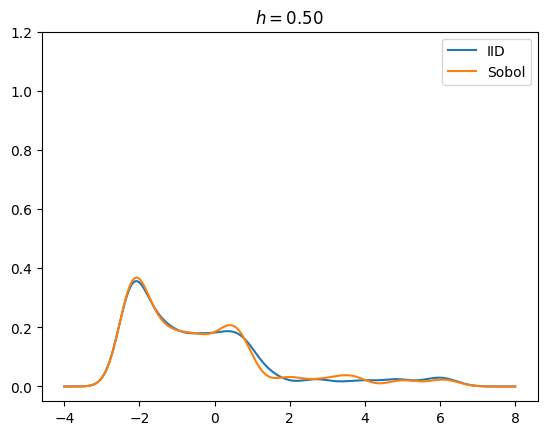

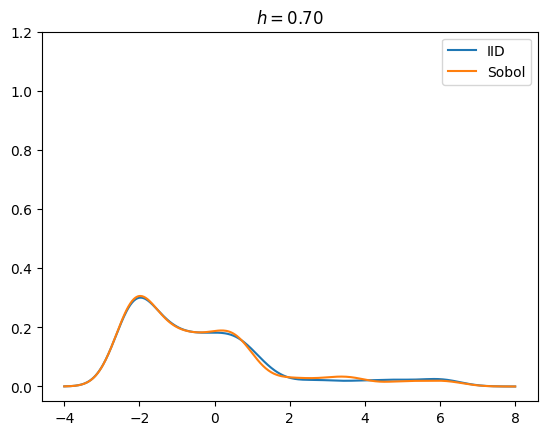

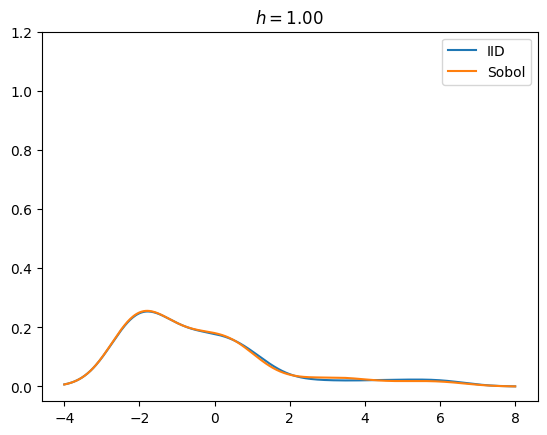

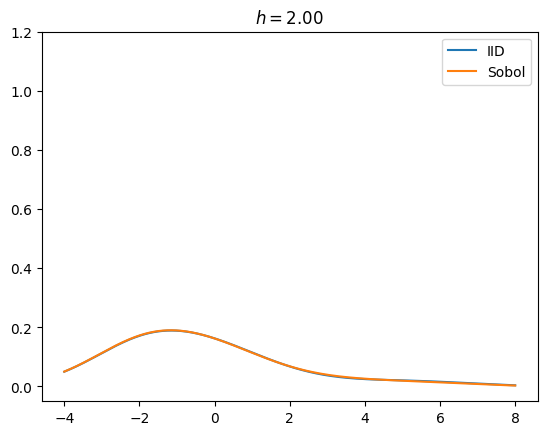

In [39]:
# dim = 3, decrease n to 2**10
bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,few_yiid3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,few_ysob3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Kernel density estimator for uniform distribution

In [12]:
def testfun_unif(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    # y = 10*np.exp(-wtx.sum(1))*np.sin(np.pi*wtx.sum(1))
    y = x[:,0] # if x is uniform, then y is uniform
    return y

In [13]:
yiid_unif1 = testfun_unif(iidpts1)
ysob_unif1 = testfun_unif(sobpts1)

yiid_unif3 = testfun_unif(iidpts3)
ysob_unif3 = testfun_unif(sobpts3)

In [40]:
many_yiid_unif1 = testfun_unif(many_iidpts1)
many_ysob_unif1 = testfun_unif(many_sobpts1)

many_yiid_unif3 = testfun_unif(many_iidpts3)
many_ysob_unif3 = testfun_unif(many_sobpts3)

In [41]:
few_yiid_unif1 = testfun_unif(few_iidpts1)
few_ysob_unif1 = testfun_unif(few_sobpts1)

few_yiid_unif3 = testfun_unif(few_iidpts3)
few_ysob_unif3 = testfun_unif(few_sobpts3)

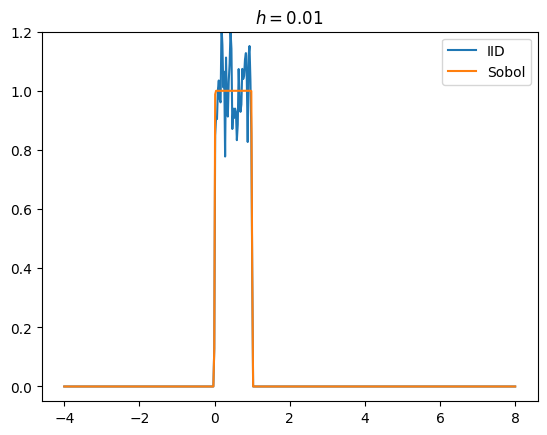

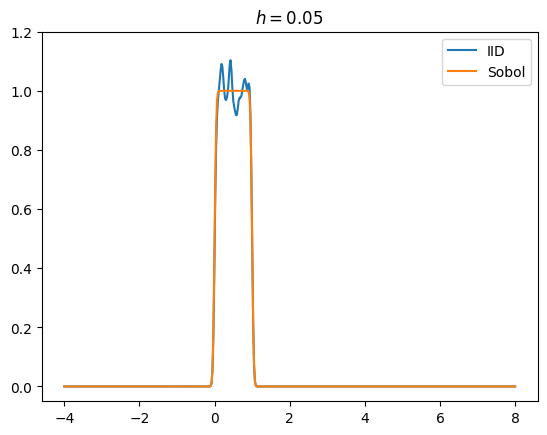

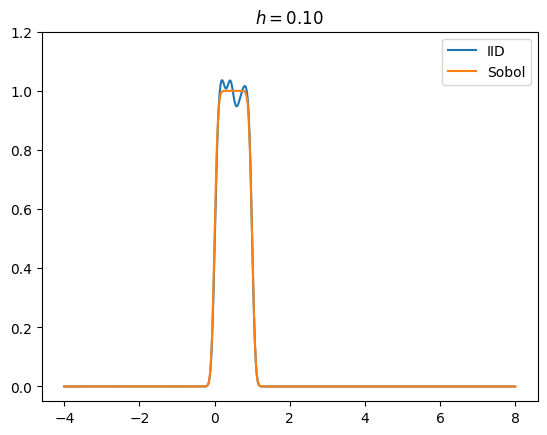

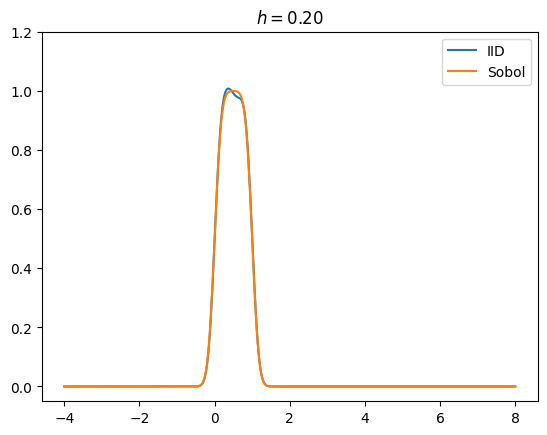

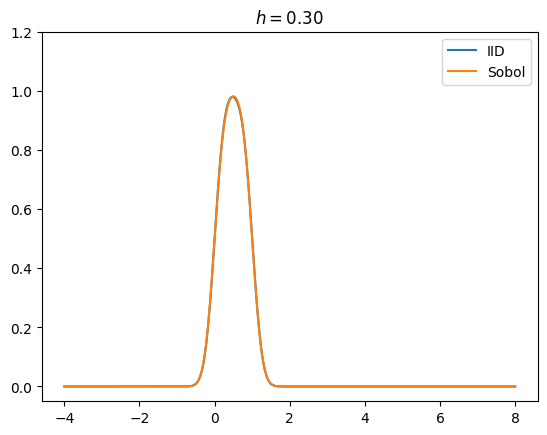

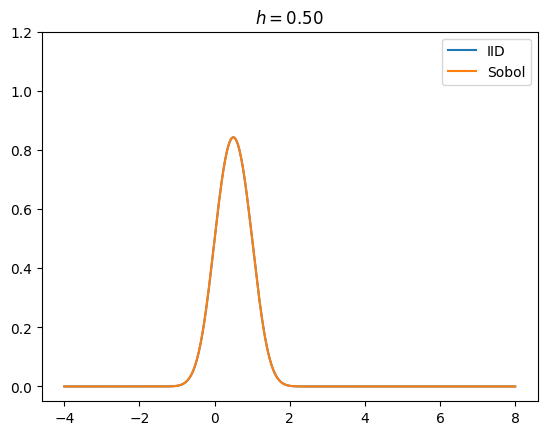

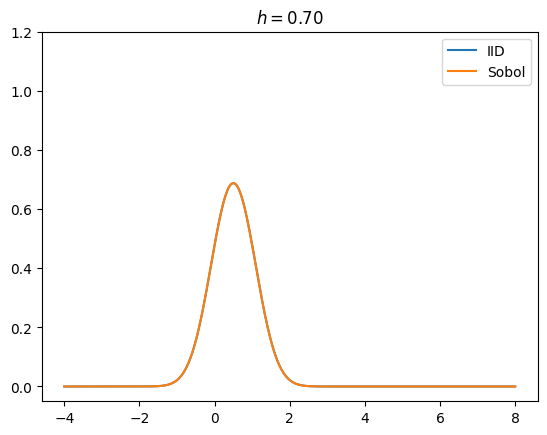

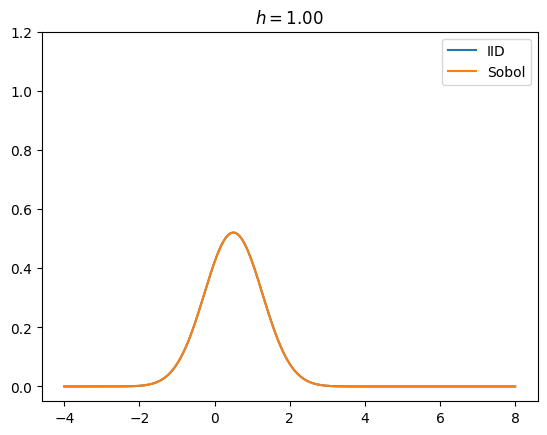

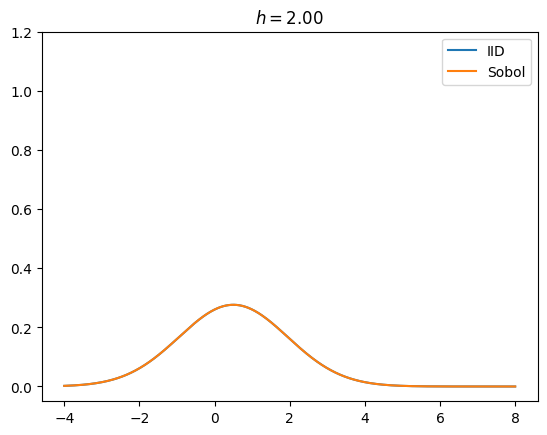

In [21]:
# dim = 1

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid_unif1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob_unif1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

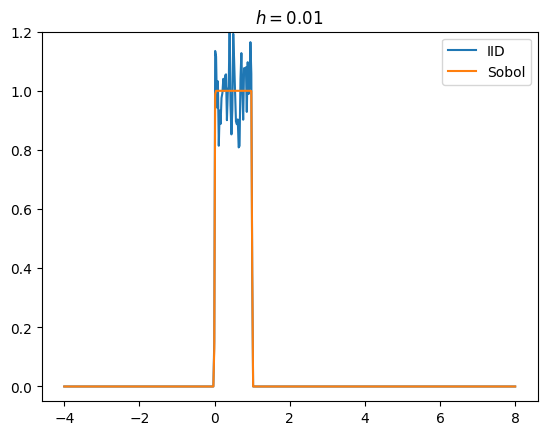

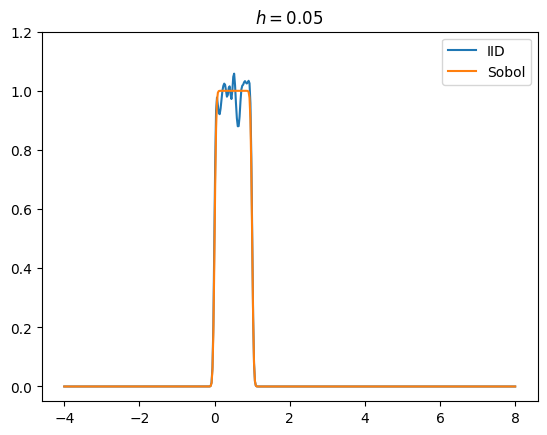

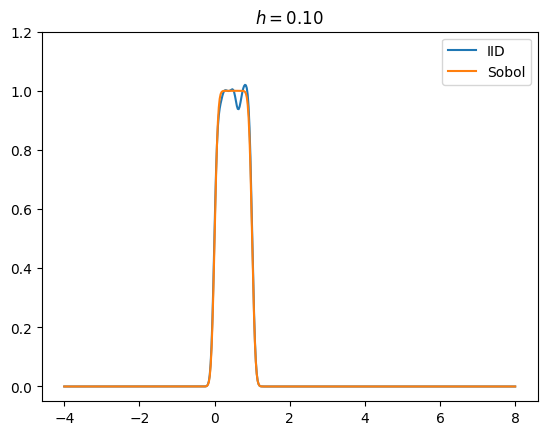

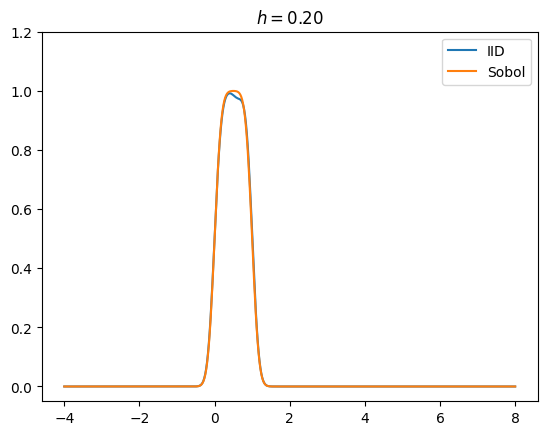

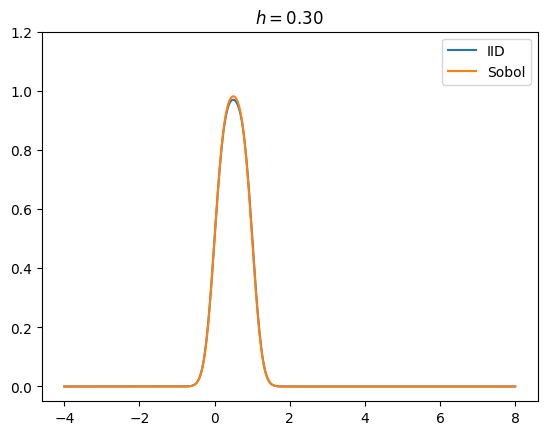

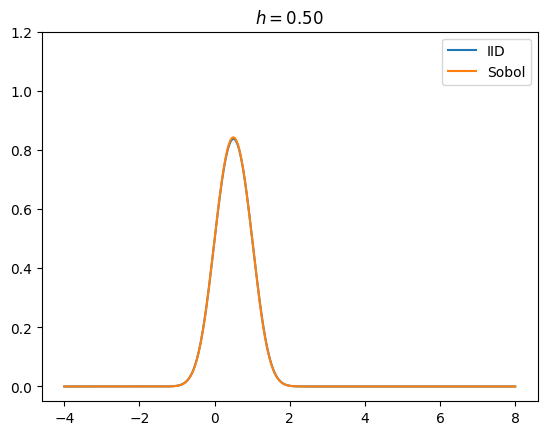

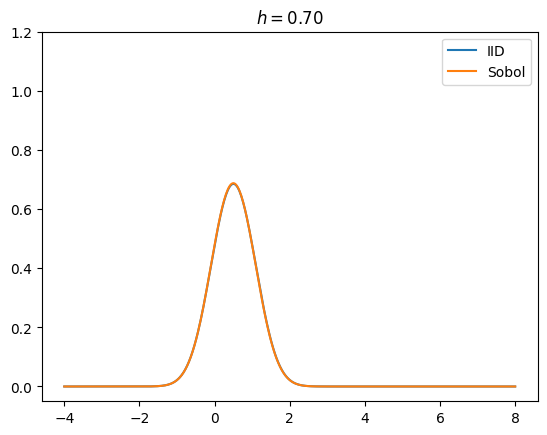

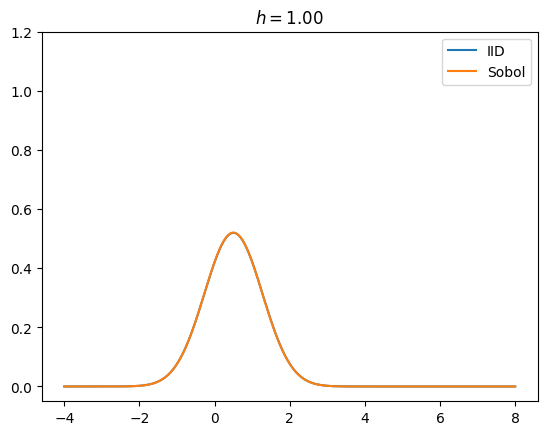

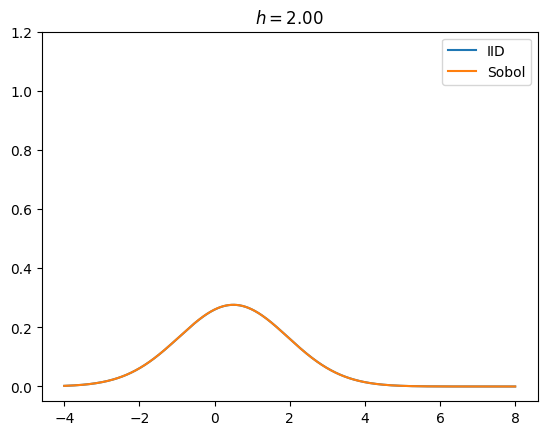

In [22]:
# dim = 3

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid_unif3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob_unif3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

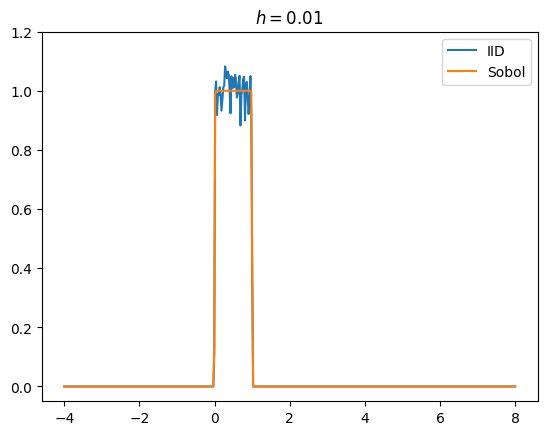

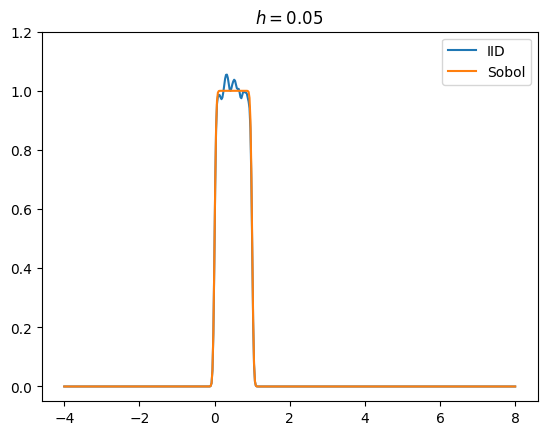

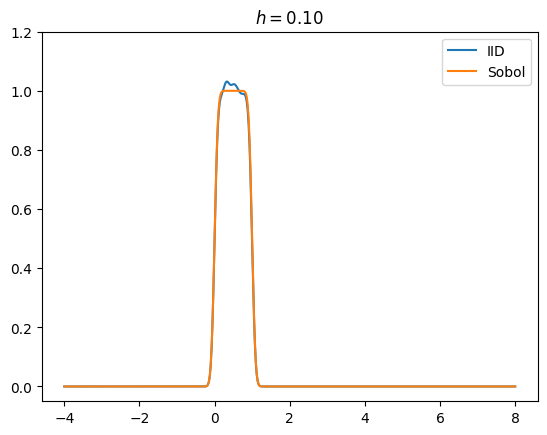

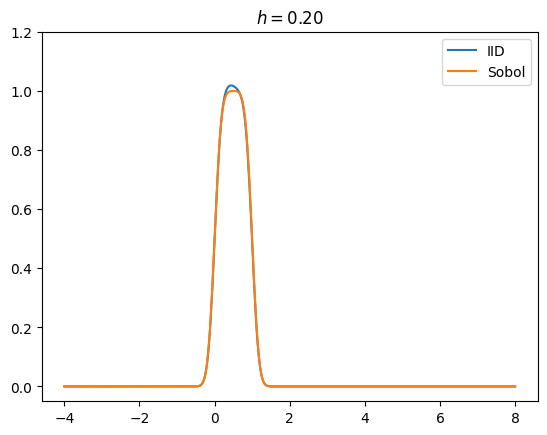

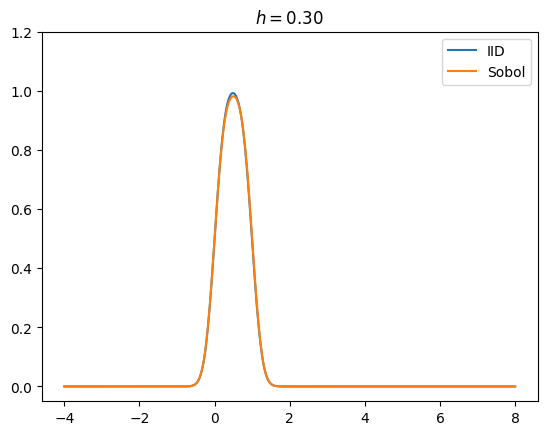

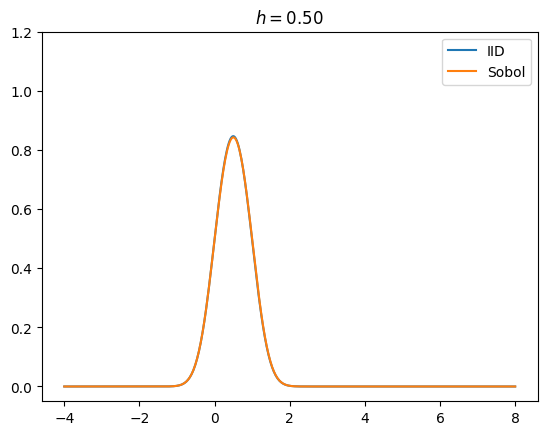

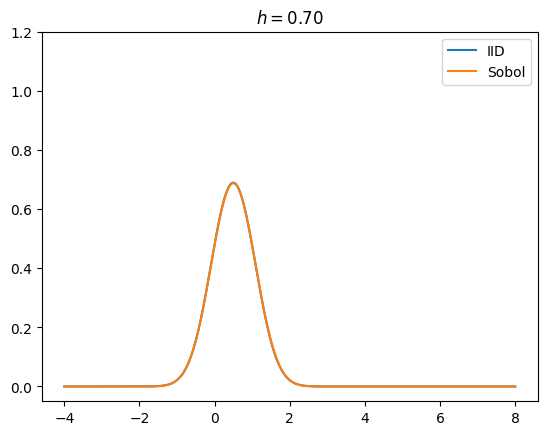

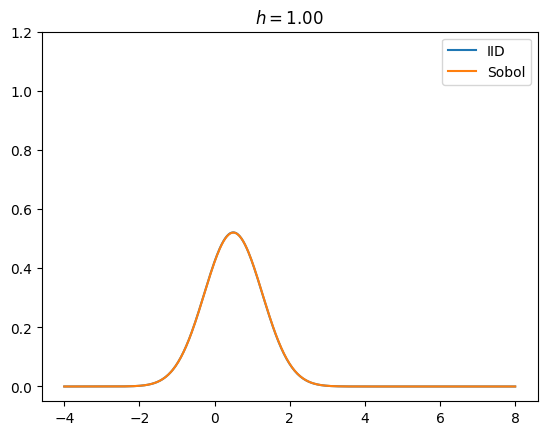

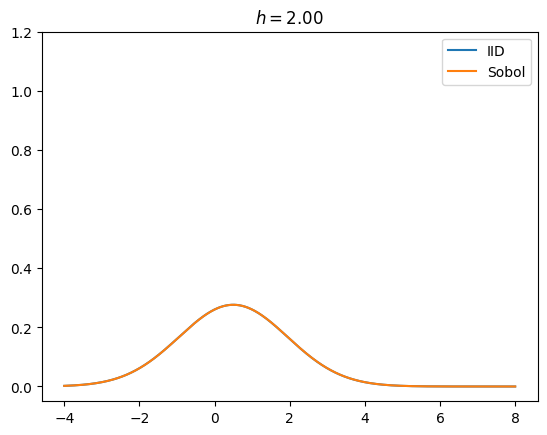

In [42]:
# dim = 1, increase n to 2**14

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,many_yiid_unif1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,many_ysob_unif1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

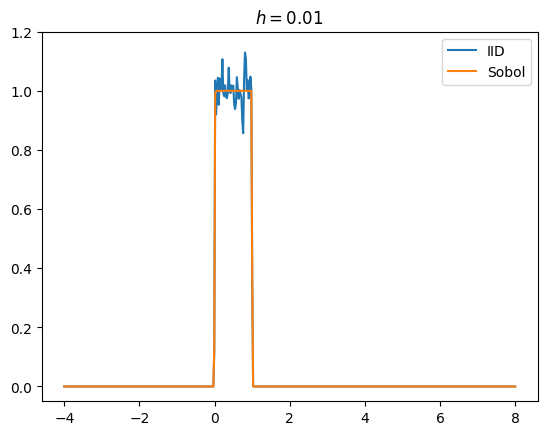

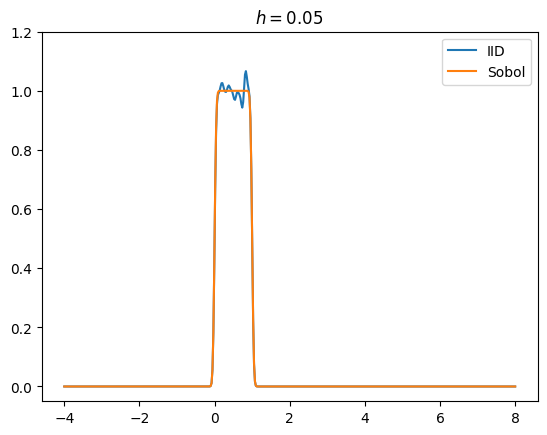

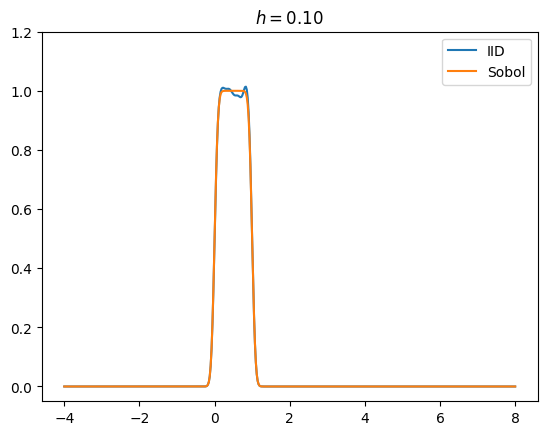

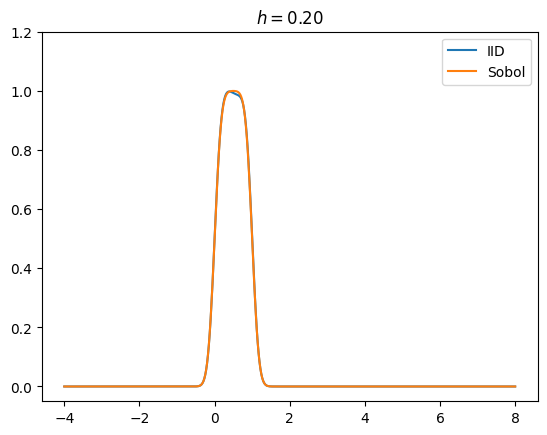

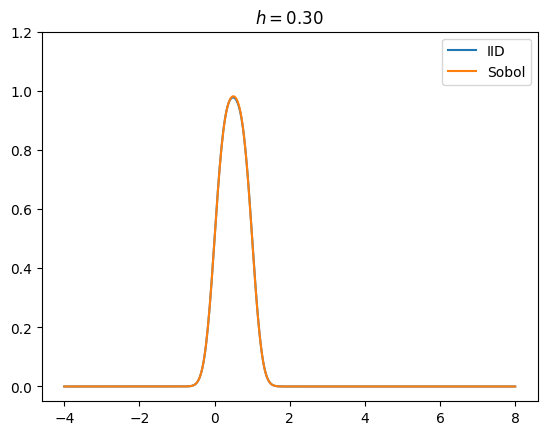

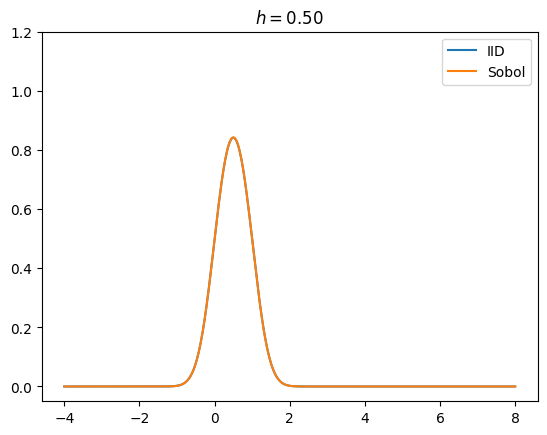

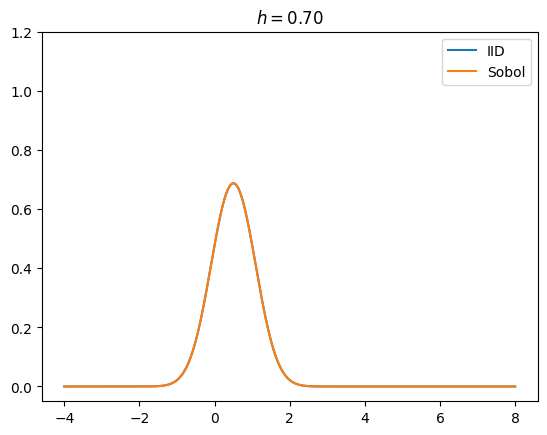

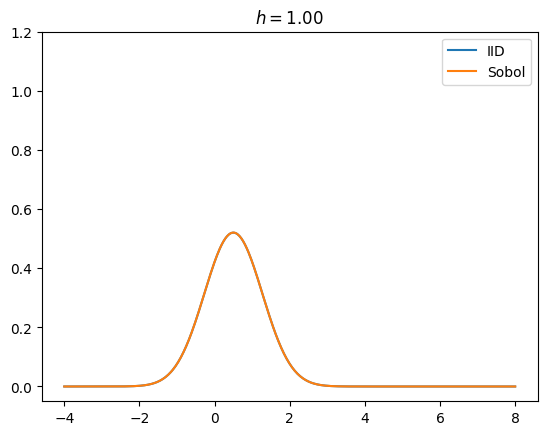

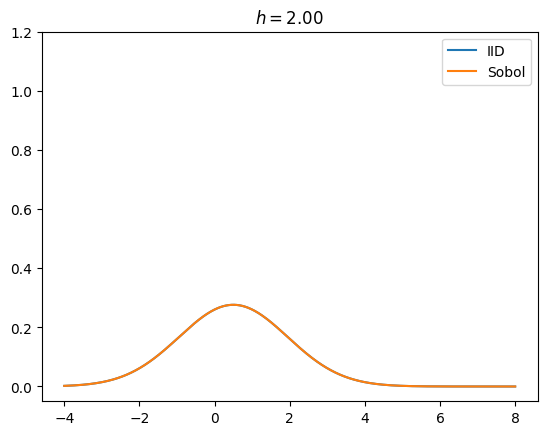

In [43]:
# dim = 3, increase n to 2**14

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,many_yiid_unif3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,many_ysob_unif3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

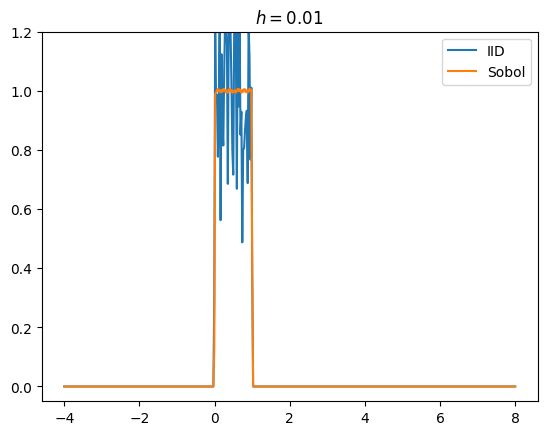

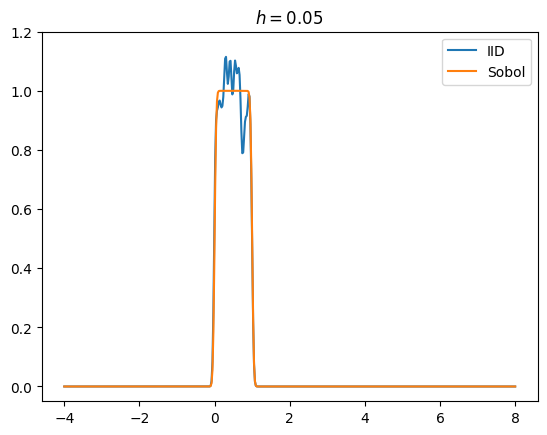

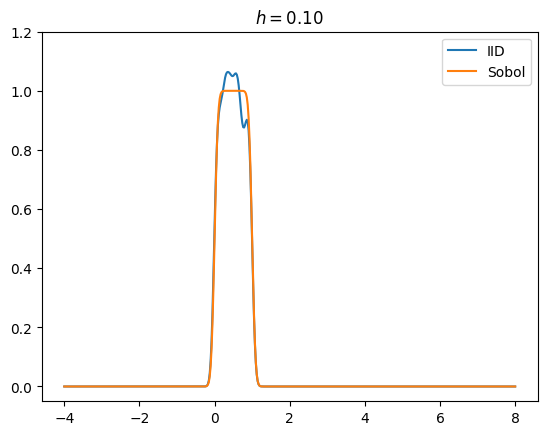

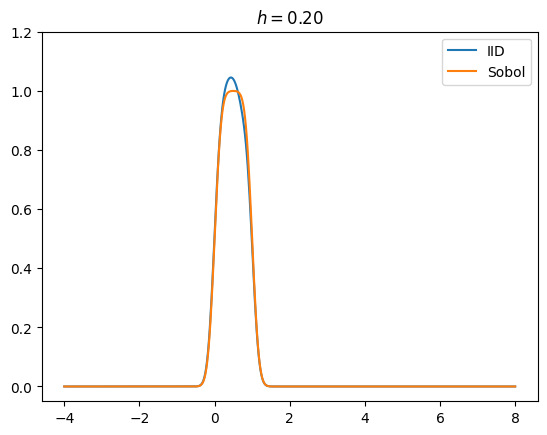

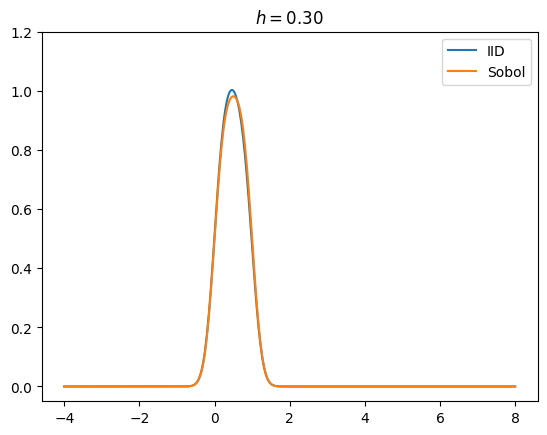

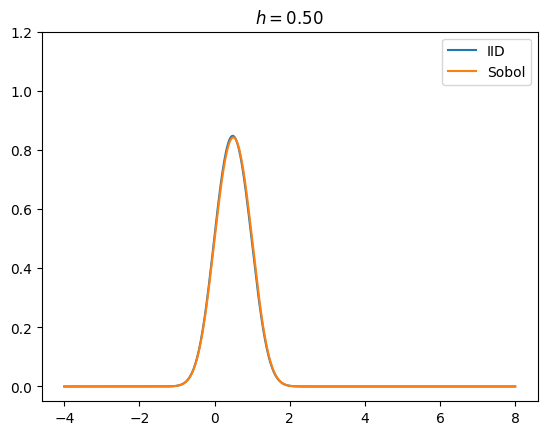

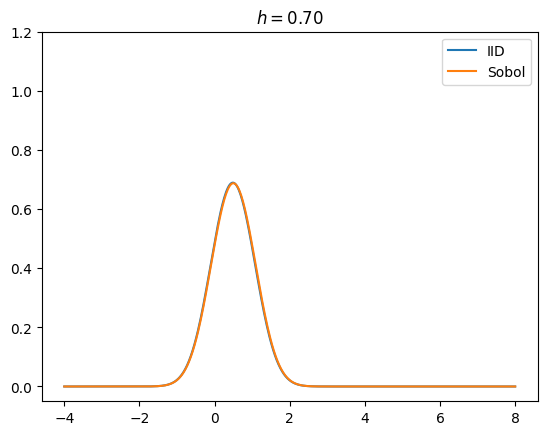

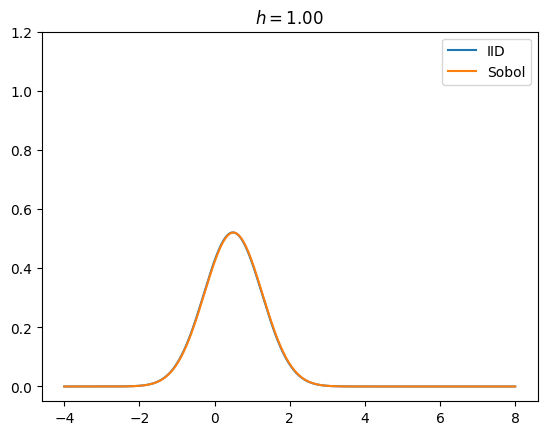

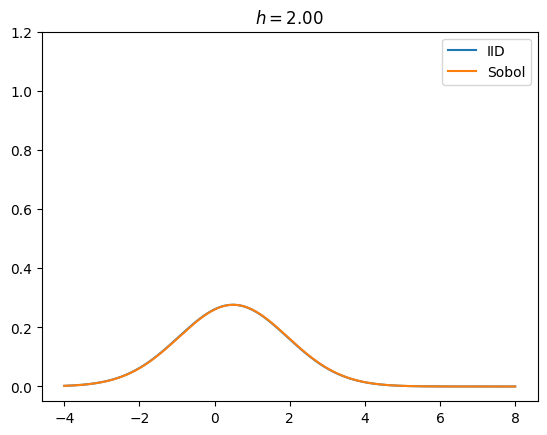

In [44]:
# dim = 1, decrease n to 2**10

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,few_yiid_unif1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,few_ysob_unif1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

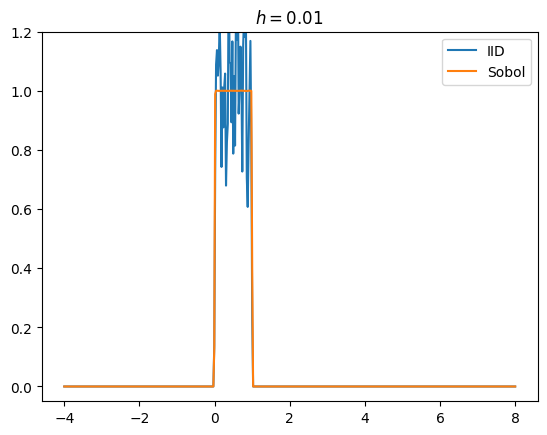

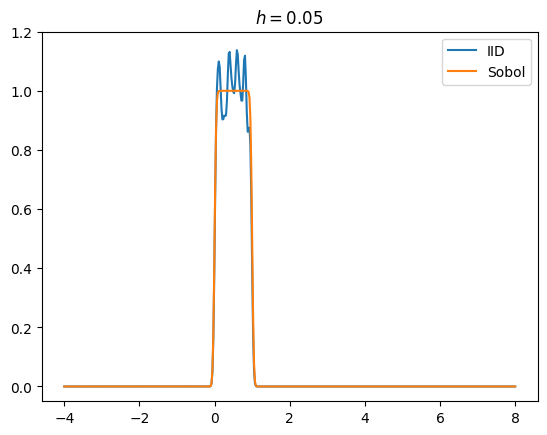

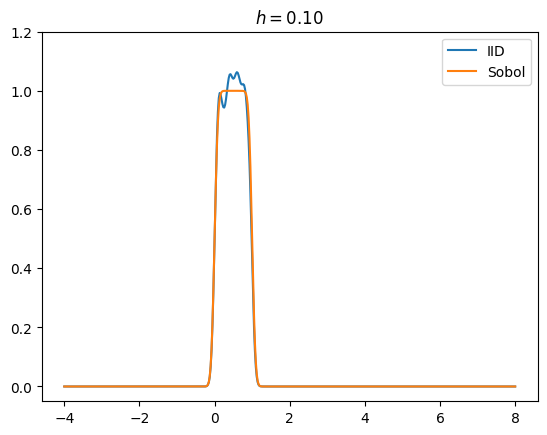

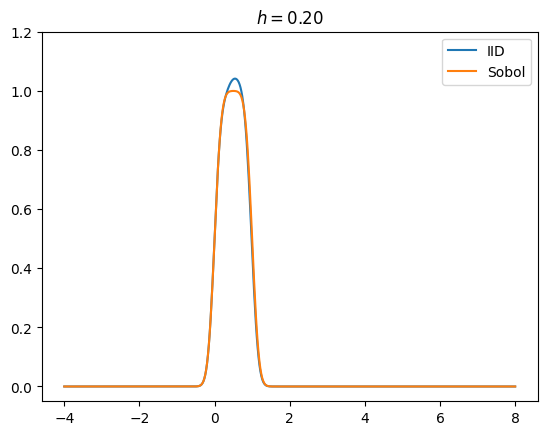

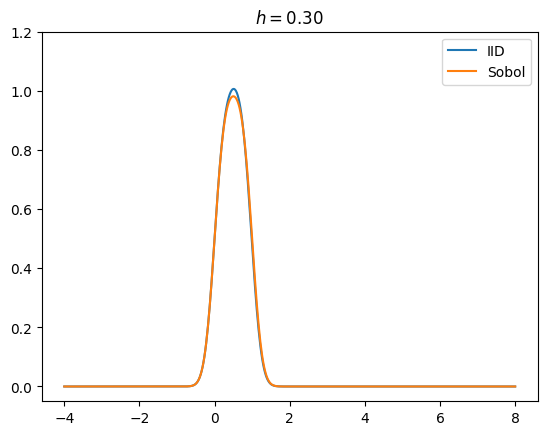

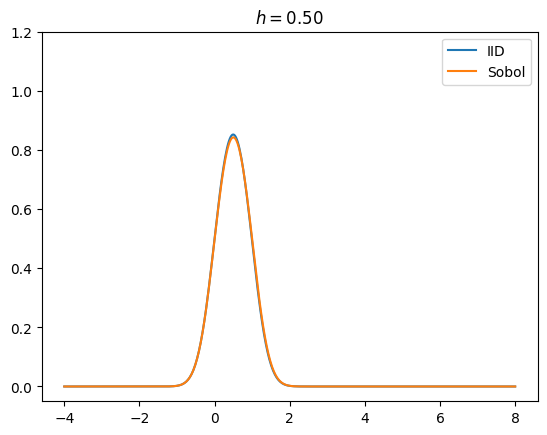

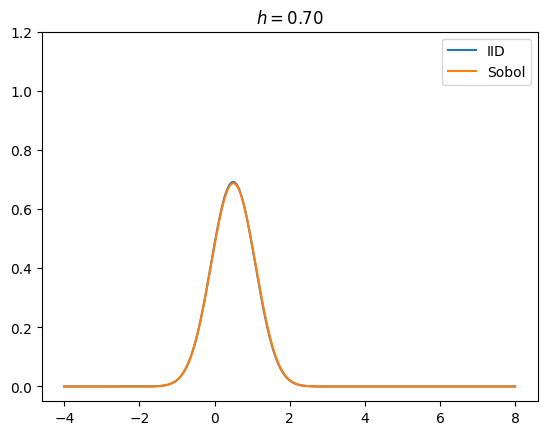

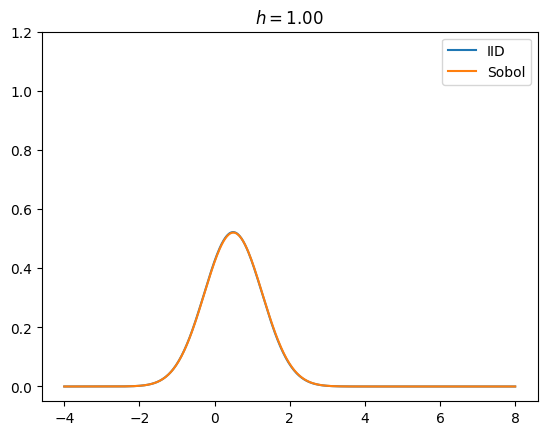

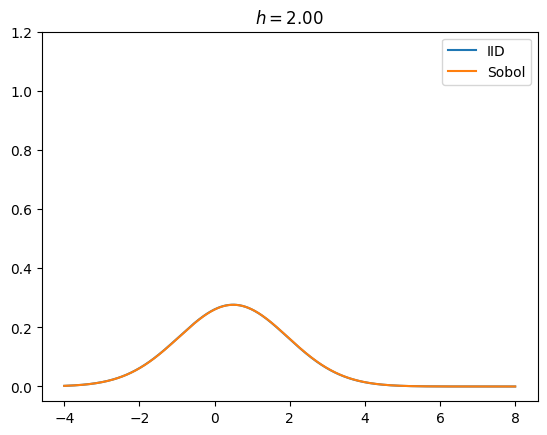

In [45]:
# dim = 3, decrease n to 2**10

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,few_yiid_unif3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,few_ysob_unif3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Testing different LD sequences: Sobol, Lattice, Digital Net B2, and Halton

In [23]:
d = 1
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
# iidpts1 = qp.IIDStdUniform(d).gen_samples(n)
# print("iid pts",iidpts1)
# wtiidpts1 = np.multiply(iidpts1,coord_wts)
# print(wtiidpts1)
# sobpts1 = qp.Sobol(d).gen_samples(n)
# print("sobol pts",sobpts1)
latticepts1 = qp.Lattice(d).gen_samples(n)
print("lattice pts",latticepts1)
dnetb2pts1 = qp.DigitalNetB2(d).gen_samples(n)
print("Digital Net B2 pts",dnetb2pts1)
haltonpts1 = qp.Halton(d).gen_samples(n)
print("halton pts",haltonpts1)

lattice pts [[0.9573272 ]
 [0.4573272 ]
 [0.2073272 ]
 ...
 [0.70708306]
 [0.45708306]
 [0.95708306]]
Digital Net B2 pts [[0.74559594]
 [0.3583416 ]
 [0.96590345]
 ...
 [0.38172262]
 [0.80178297]
 [0.15677644]]
halton pts [[0.24709518]
 [0.74709518]
 [0.49709518]
 ...
 [0.50271042]
 [0.25271042]
 [0.75271042]]


In [24]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
# iidpts3 = qp.IIDStdUniform(d).gen_samples(n)
# print("iid pts",iidpts3)
# wtiidpts3 = np.multiply(iidpts3,coord_wts)
# print(wtiidpts3)
# sobpts3 = qp.Sobol(d).gen_samples(n)
# print("sobol pts",sobpts3)
latticepts3 = qp.Lattice(d).gen_samples(n)
print("lattice pts",latticepts3)
dnetb2pts3 = qp.DigitalNetB2(d).gen_samples(n)
print("Digital Net B2 pts",dnetb2pts3)
haltonpts3 = qp.Halton(d).gen_samples(n)
print("halton pts",haltonpts3)

lattice pts [[0.57983255 0.92335443 0.46740066]
 [0.07983255 0.42335443 0.96740066]
 [0.82983255 0.67335443 0.21740066]
 ...
 [0.32958841 0.57691888 0.99791824]
 [0.07958841 0.82691888 0.24791824]
 [0.57958841 0.32691888 0.74791824]]
Digital Net B2 pts [[0.70603118 0.84672164 0.96466103]
 [0.23357289 0.21492521 0.16564222]
 [0.92371286 0.26876079 0.43243052]
 ...
 [0.04155459 0.37379435 0.43053867]
 [0.86353007 0.17370867 0.16753455]
 [0.32185876 0.76464478 0.96264711]]
halton pts [[0.54621318 0.96022727 0.6591939 ]
 [0.04621318 0.2935606  0.2591939 ]
 [0.79621318 0.62689393 0.8591939 ]
 ...
 [0.20368388 0.19311859 0.4120259 ]
 [0.95368388 0.52645193 0.0120259 ]
 [0.45368388 0.8968223  0.7320259 ]]


In [27]:
# using original function f(x)

# yiid1 = testfun1(iidpts1)
# ysob1 = testfun1(sobpts1)
ylattice1 = testfun1(latticepts1)
ydnetb21 = testfun1(dnetb2pts1)
yhalton1 = testfun1(haltonpts1)

# yiid3 = testfun1(iidpts1)
# ysob3 = testfun1(sobpts1)
ylattice3 = testfun1(latticepts3)
ydnetb23 = testfun1(dnetb2pts3)
yhalton3 = testfun1(haltonpts3)

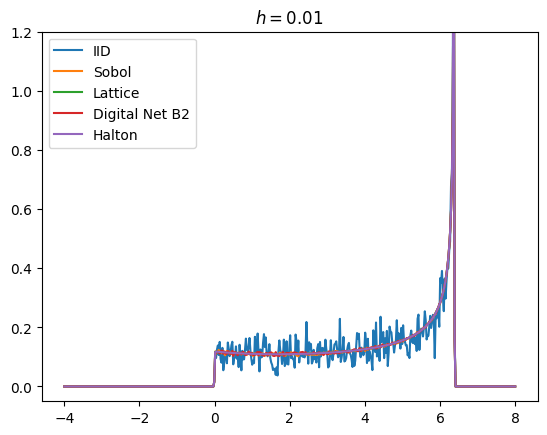

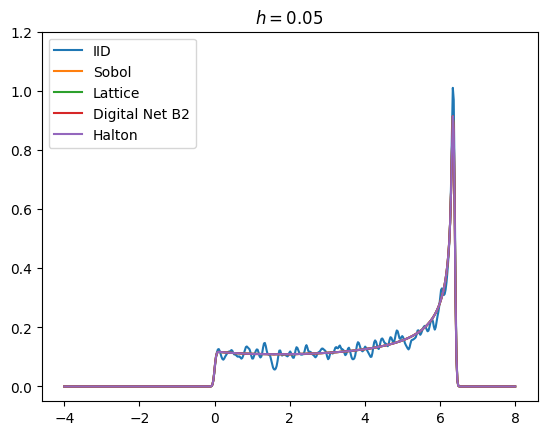

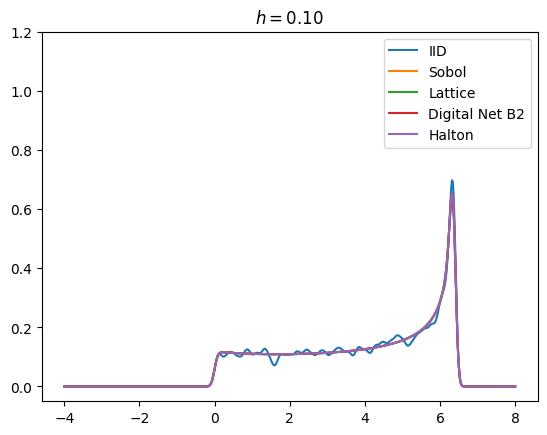

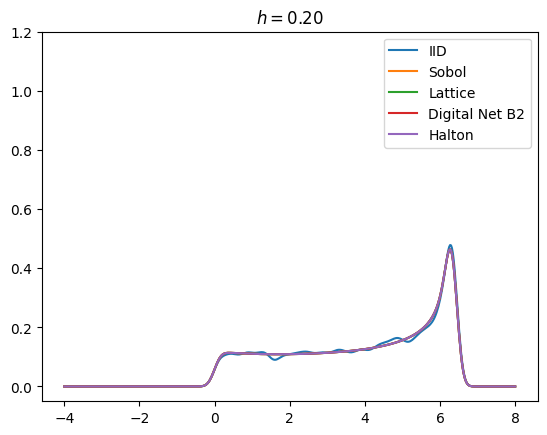

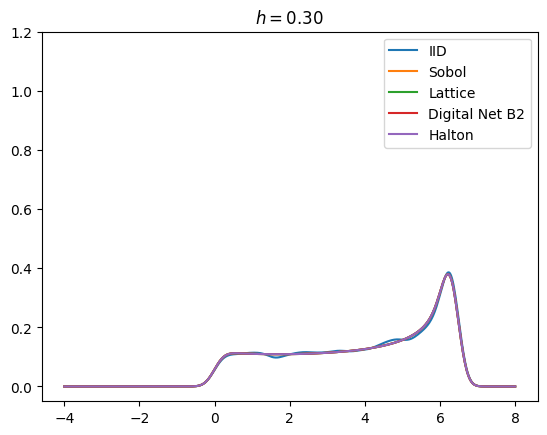

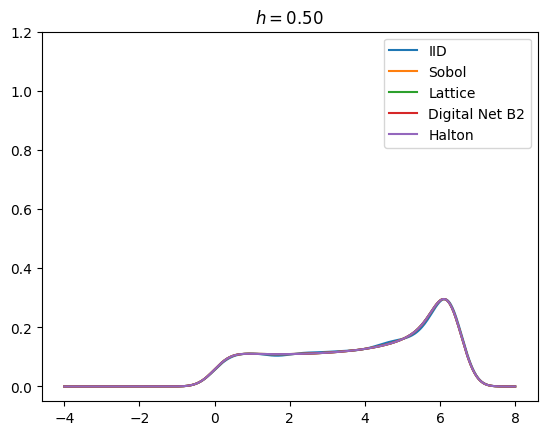

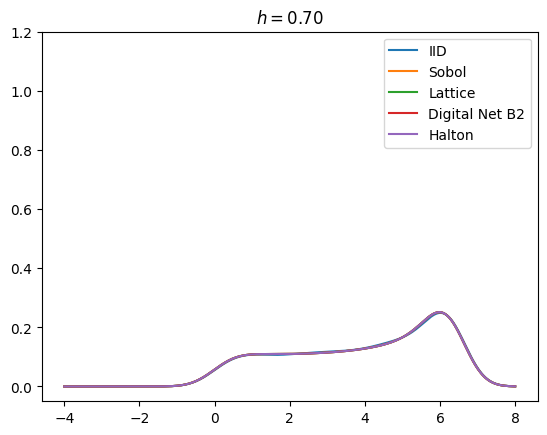

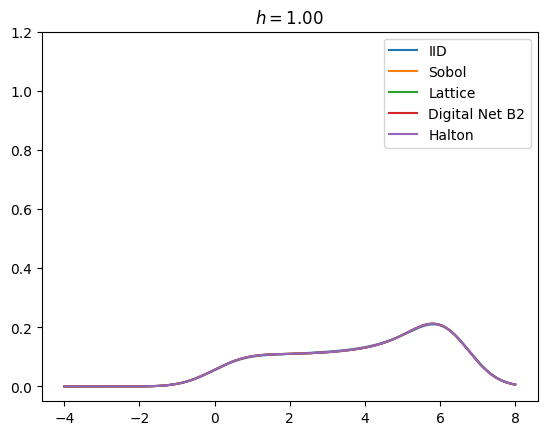

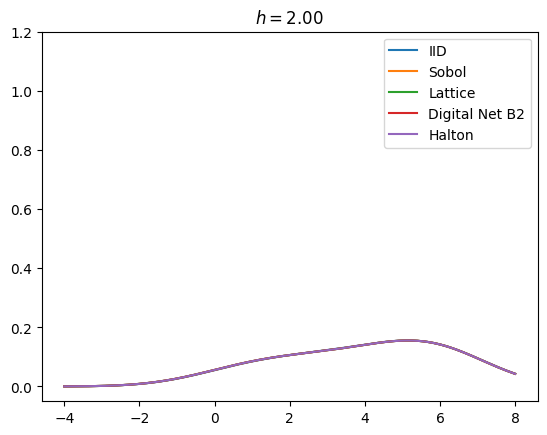

In [36]:
# dim = 1

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob1,bandwidth[ii],yeval)
    rhovallattice = kde(kernel,ylattice1,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel,ydnetb21,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel,yhalton1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

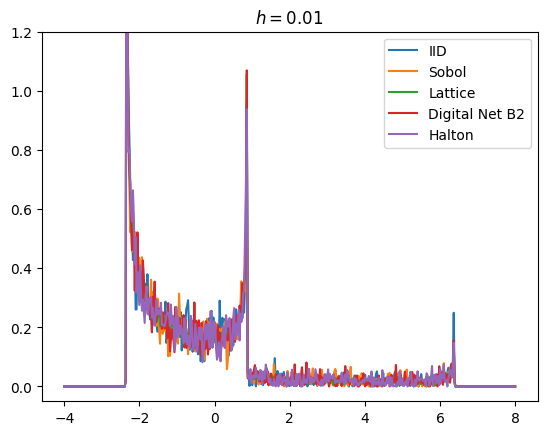

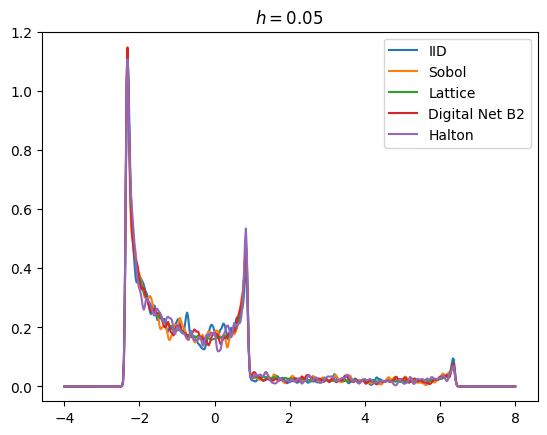

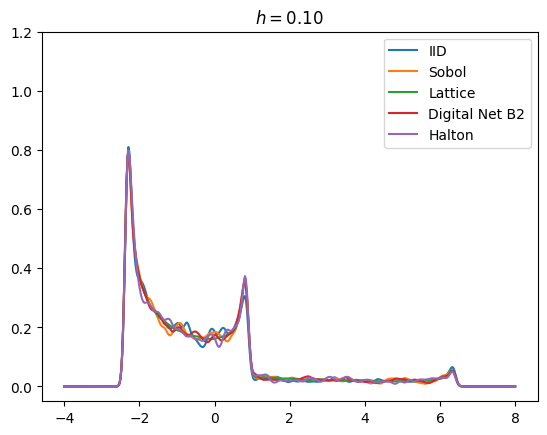

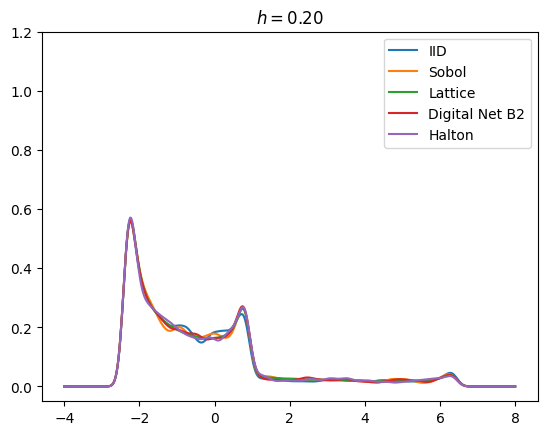

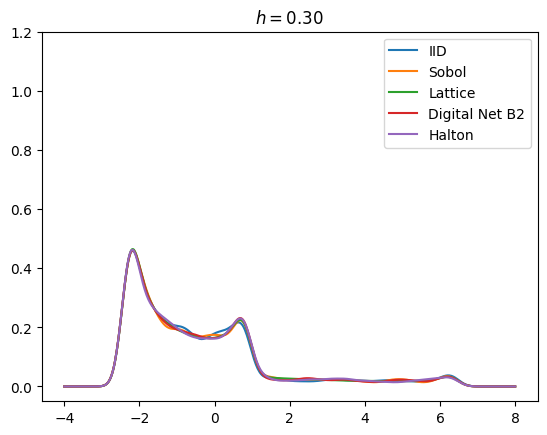

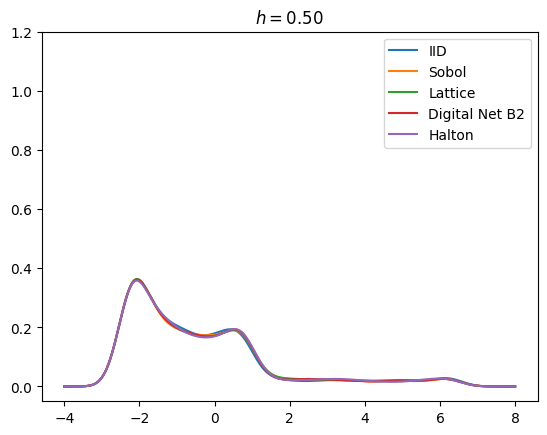

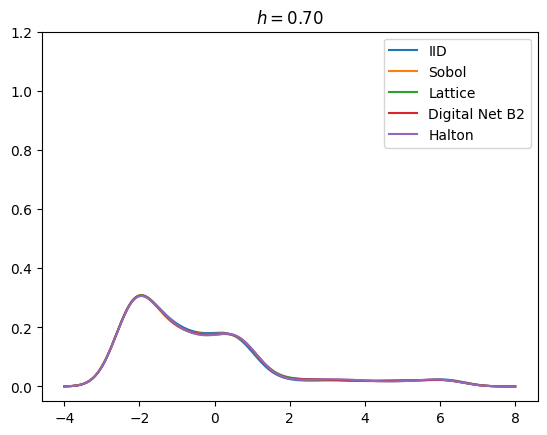

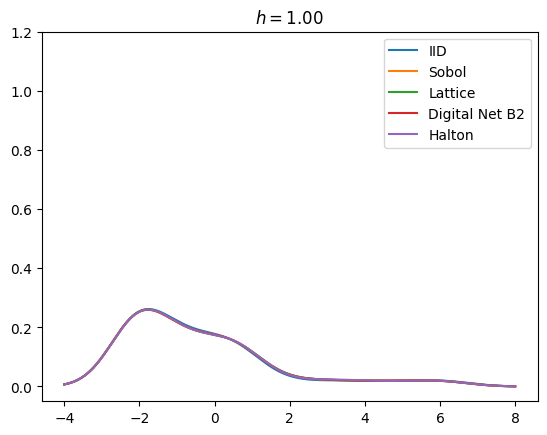

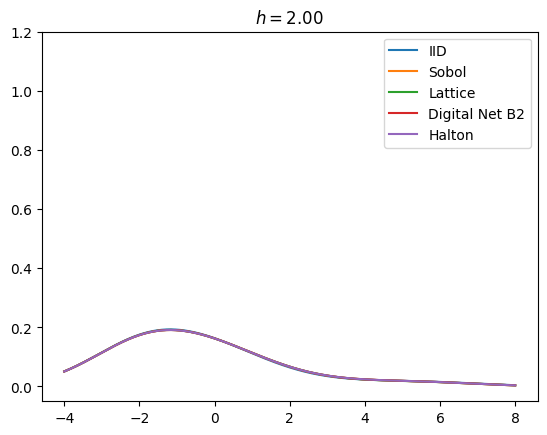

In [37]:
# dim = 3

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob3,bandwidth[ii],yeval)
    rhovallattice = kde(kernel,ylattice3,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel,ydnetb23,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel,yhalton3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Testing different kernels: https://www.researchgate.net/publication/258807801_Performance_Evaluation_of_Various_Functions_for_Kernel_Density_Estimation

In [38]:
# cosine--has best performance according to paper?
def kernel_cos(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(math.pi/4)*np.cos((math.pi/2)*y)

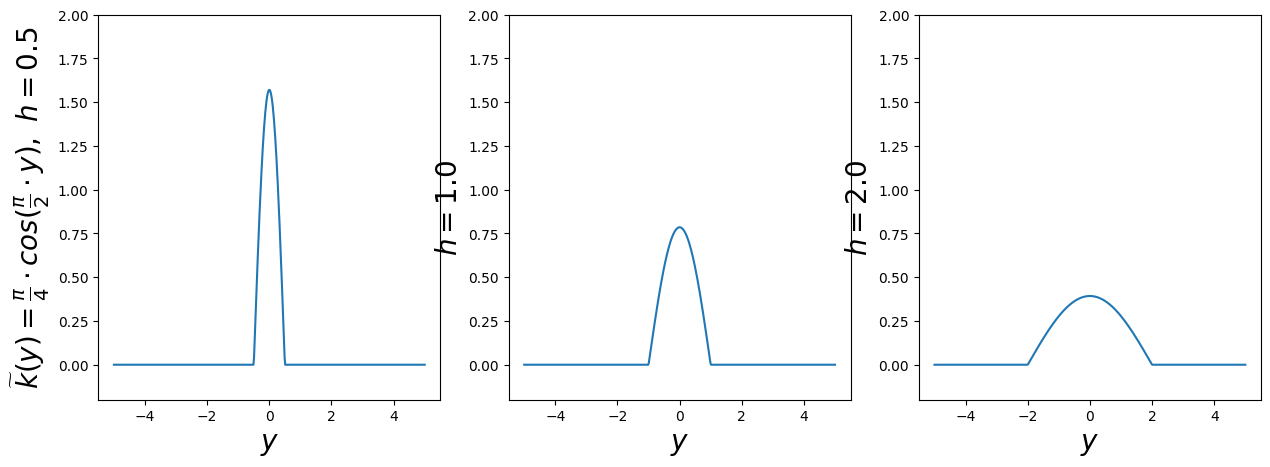

In [41]:
ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel_cos(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.2, 2])
## commenting out below lines to avoid latex error
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = \frac{\pi}{4} \cdot cos(\frac{\pi}{2} \cdot y), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
# if savefigs:
#         fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

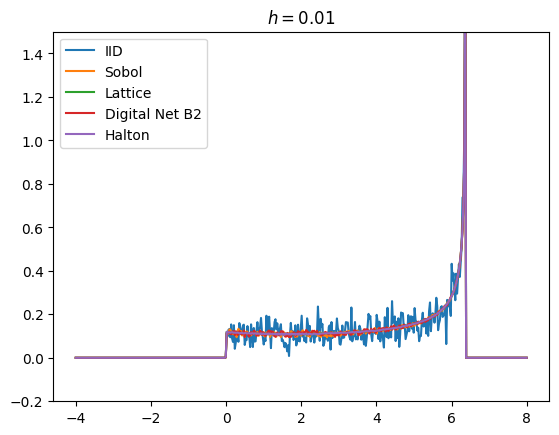

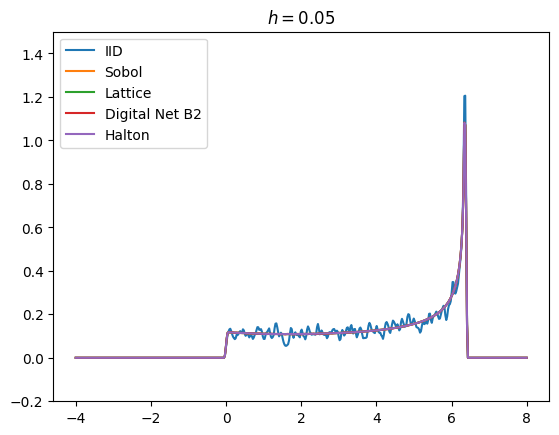

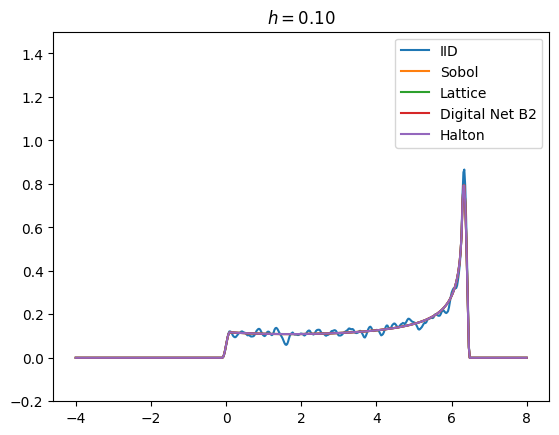

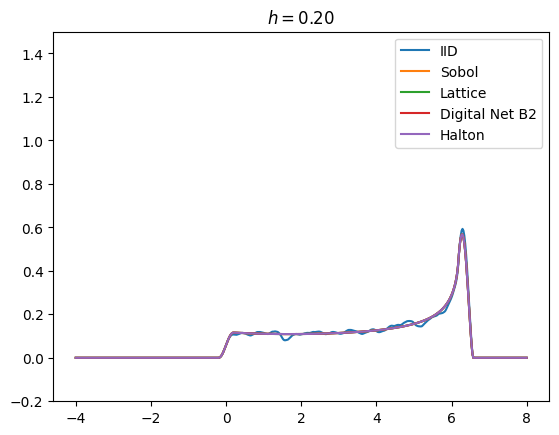

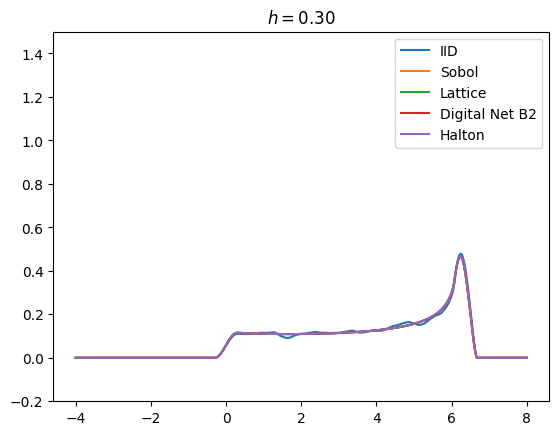

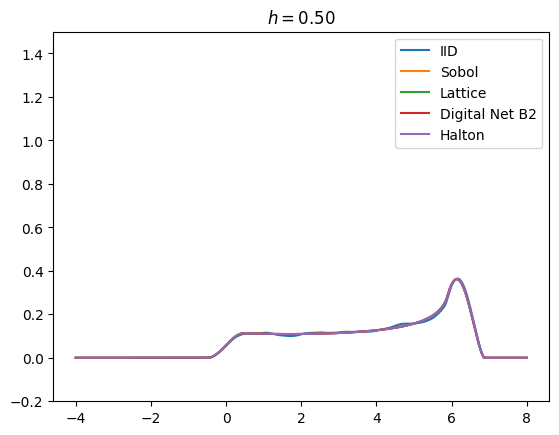

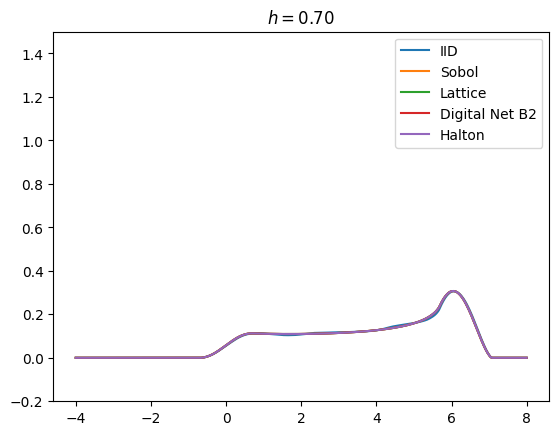

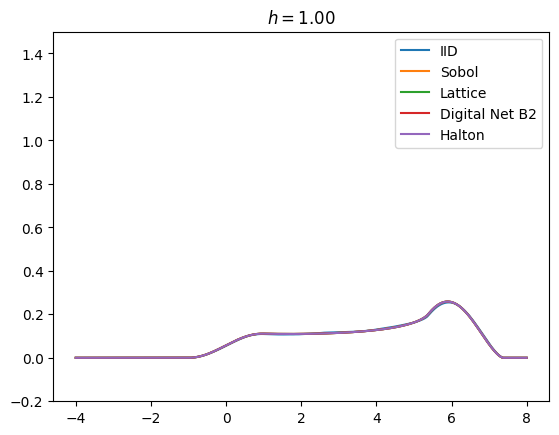

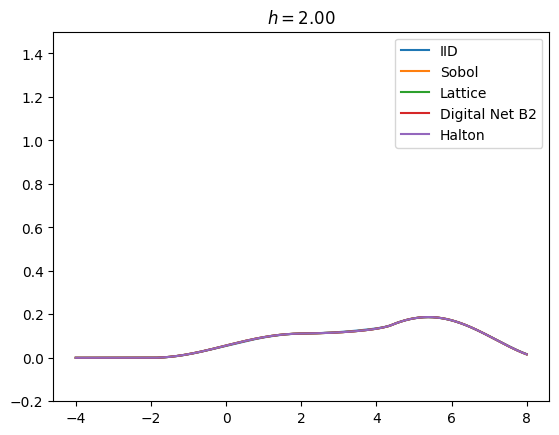

In [43]:
# dim = 1

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel_cos,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel_cos,ysob1,bandwidth[ii],yeval)
    rhovallattice = kde(kernel_cos,ylattice1,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel_cos,ydnetb21,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel_cos,yhalton1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.2, 1.5])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

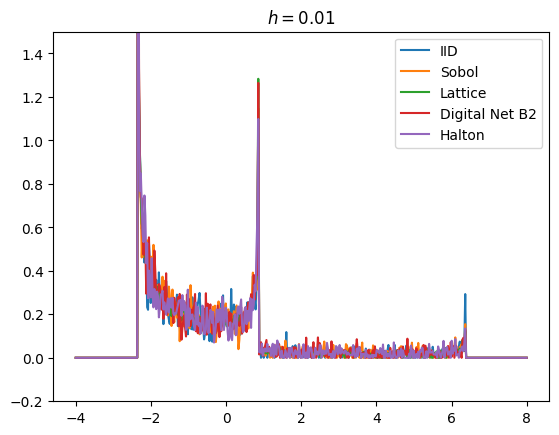

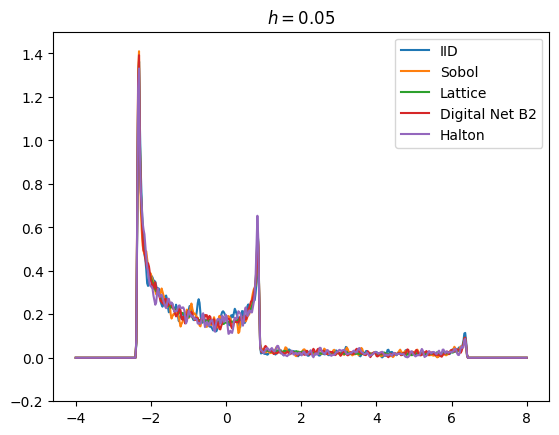

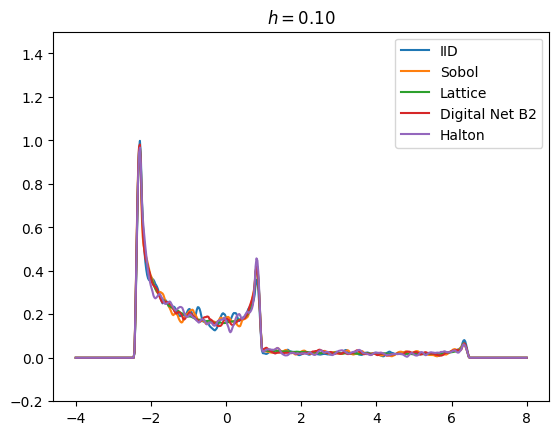

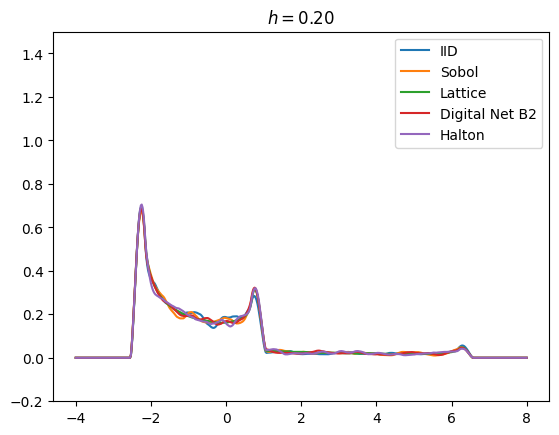

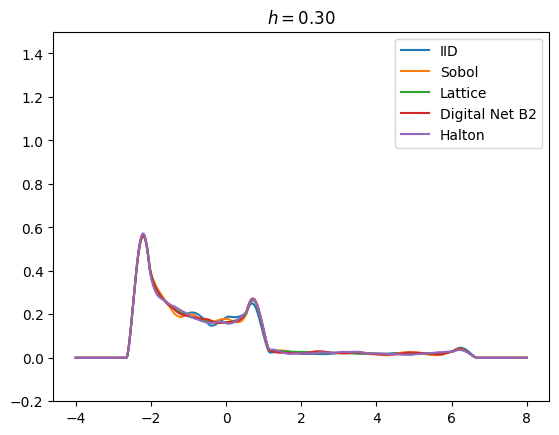

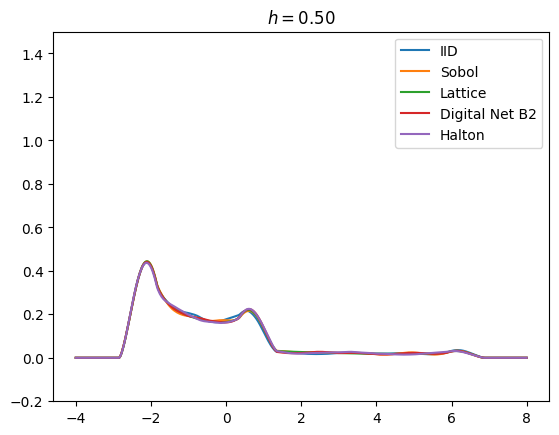

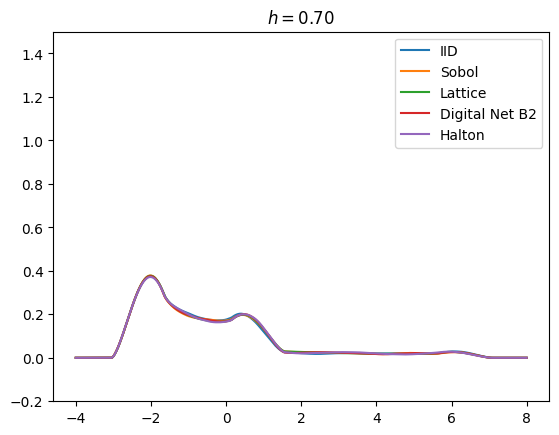

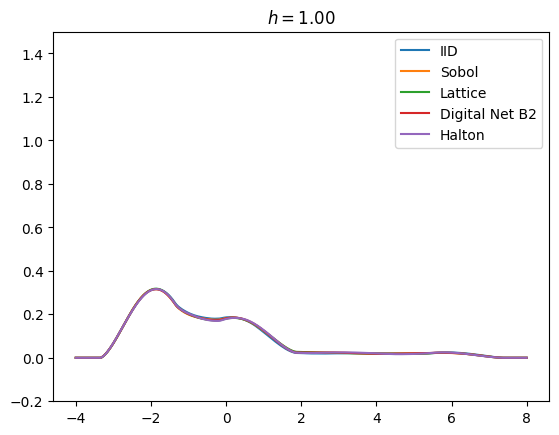

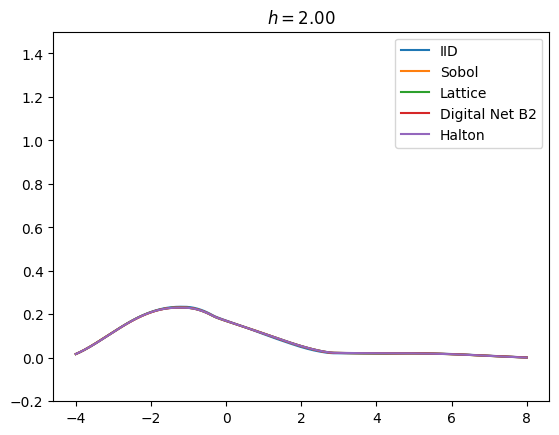

In [44]:
# dim = 3

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel_cos,yiid3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel_cos,ysob3,bandwidth[ii],yeval)
    rhovallattice = kde(kernel_cos,ylattice3,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel_cos,ydnetb23,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel_cos,yhalton3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.2, 1.5])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

In [45]:
# triangular
def kernel_tri(y):
    return np.heaviside(1-np.absolute(y), 1/2)*(1 - np.absolute(y))

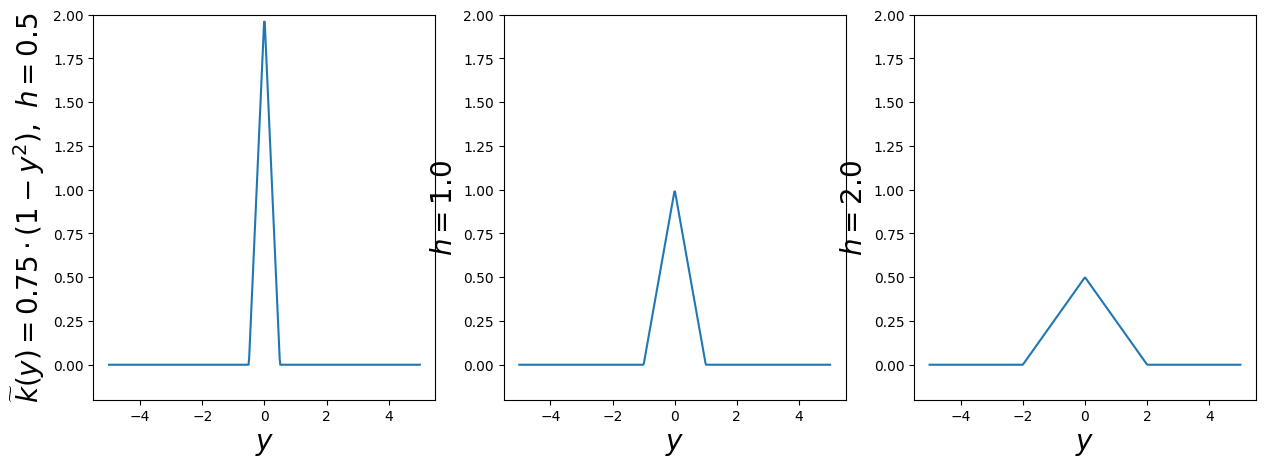

In [47]:
ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel_tri(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.2, 2])
## commenting out below lines to avoid latex error
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = 0.75 \cdot (1 - y^2), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
# if savefigs:
#         fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

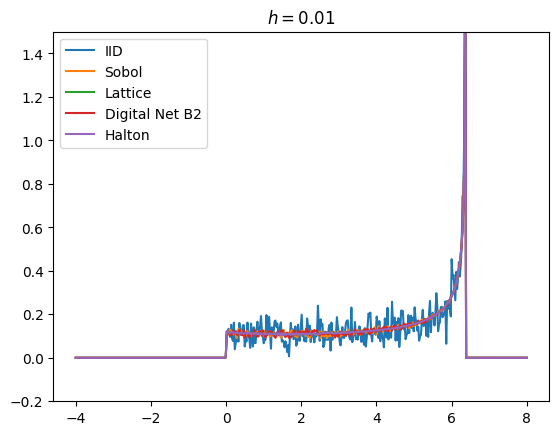

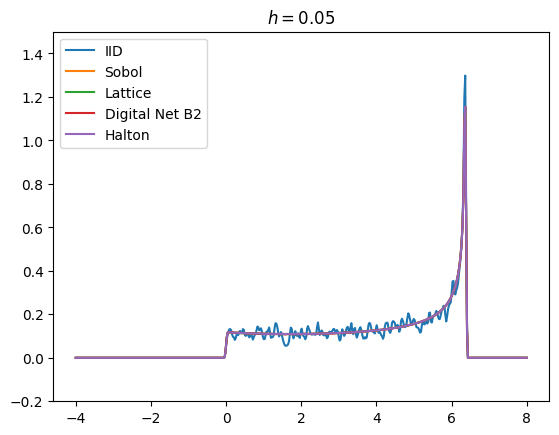

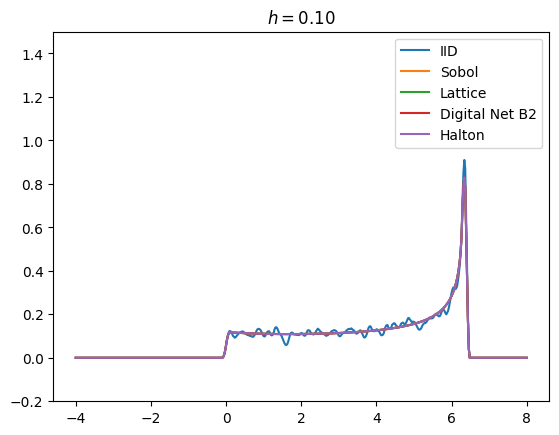

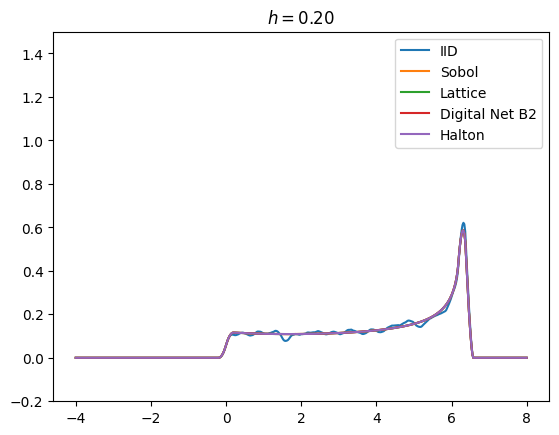

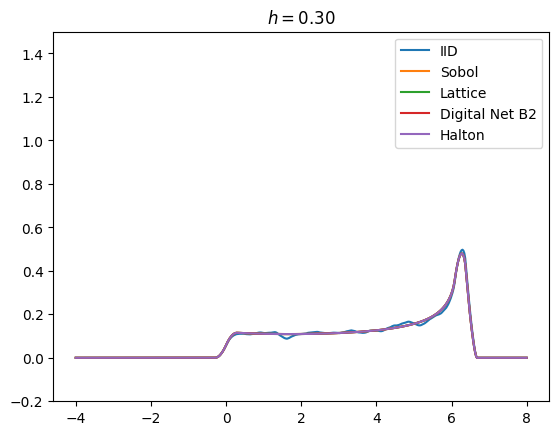

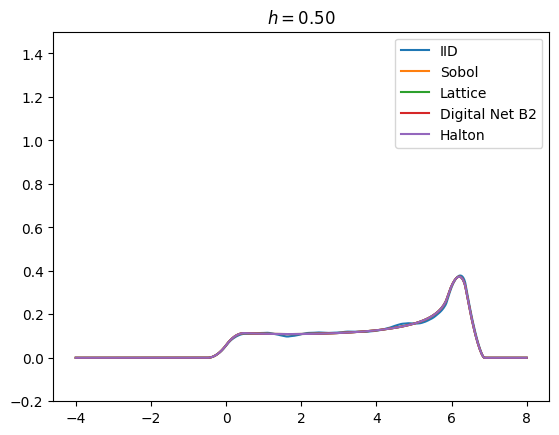

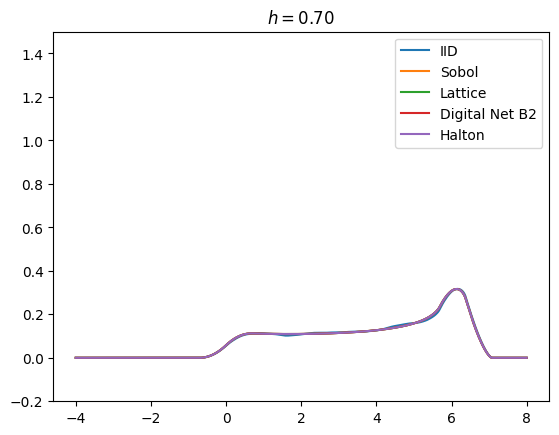

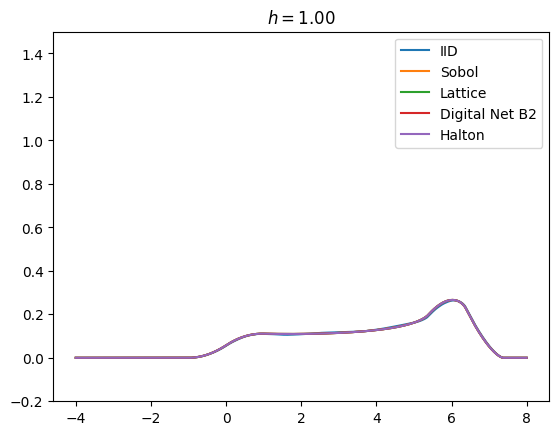

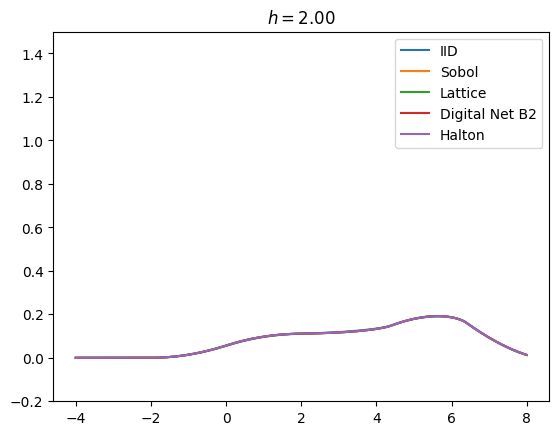

In [48]:
# dim = 1

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel_tri,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel_tri,ysob1,bandwidth[ii],yeval)
    rhovallattice = kde(kernel_tri,ylattice1,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel_tri,ydnetb21,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel_tri,yhalton1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.2, 1.5])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

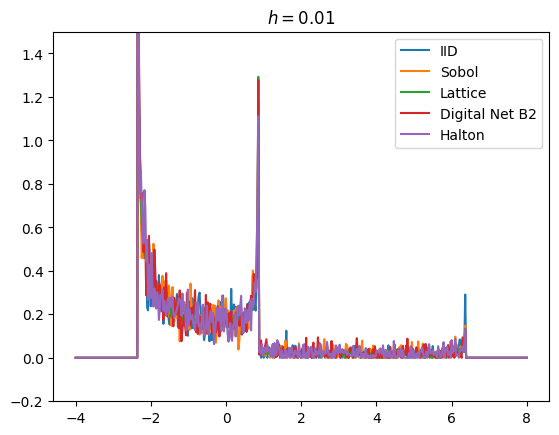

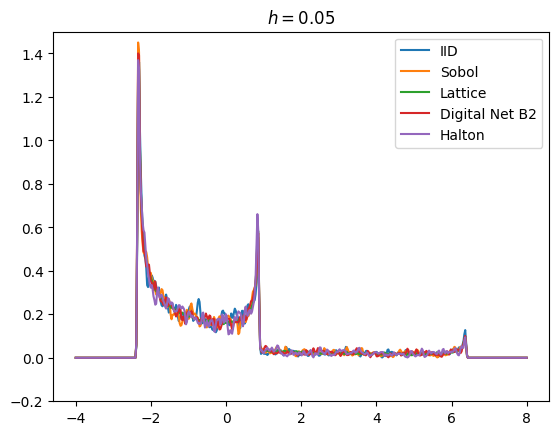

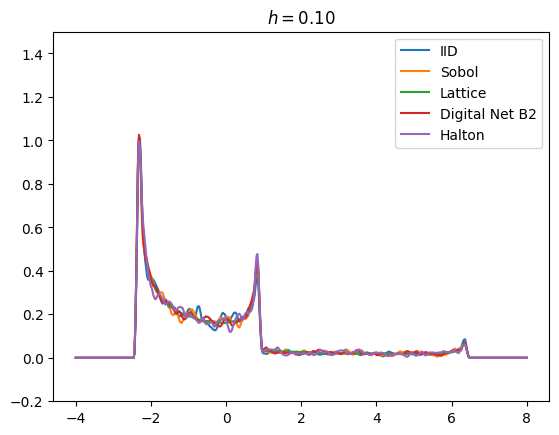

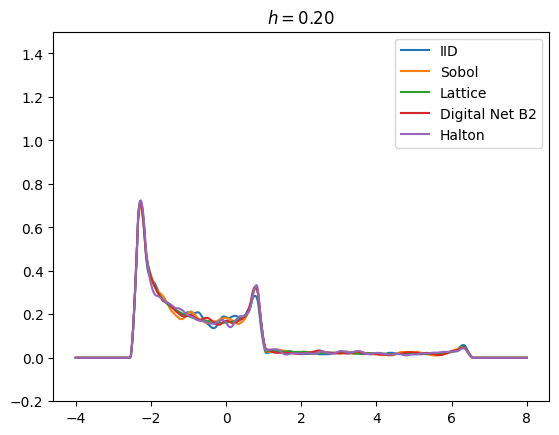

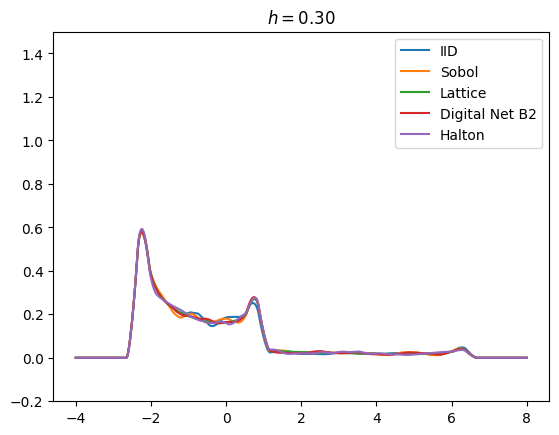

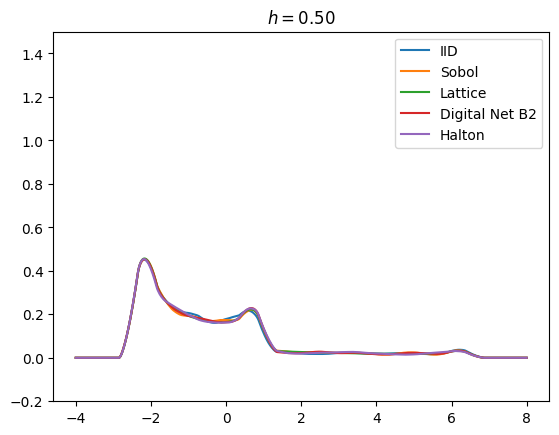

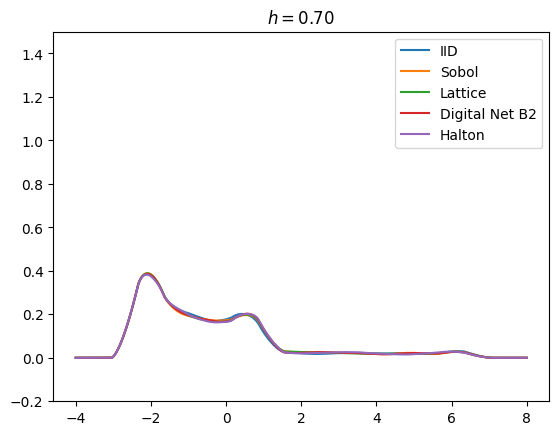

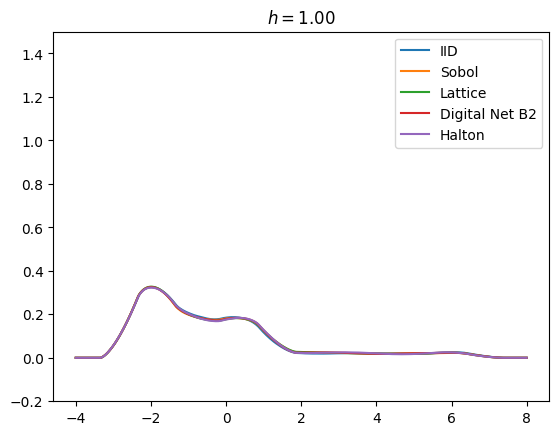

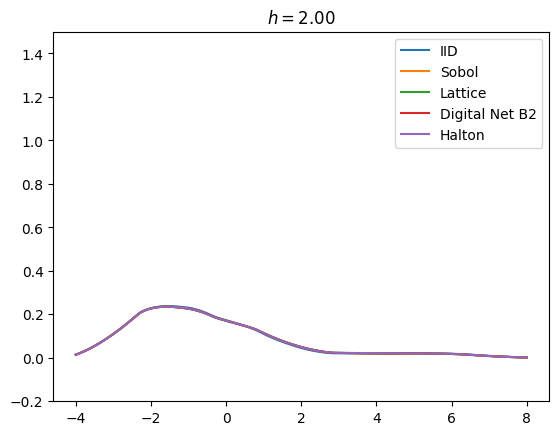

In [49]:
# dim = 3

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel_tri,yiid3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel_tri,ysob3,bandwidth[ii],yeval)
    rhovallattice = kde(kernel_tri,ylattice3,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel_tri,ydnetb23,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel_tri,yhalton3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.2, 1.5])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

In [51]:
# laplacian of Gaussian--performed poorly according to paper
def kernel_laog(y):
    return np.heaviside(1-np.absolute(y), 1/2)*((1/math.pi)*(1-(y**2)/2)*np.exp(-(y**2)/2))

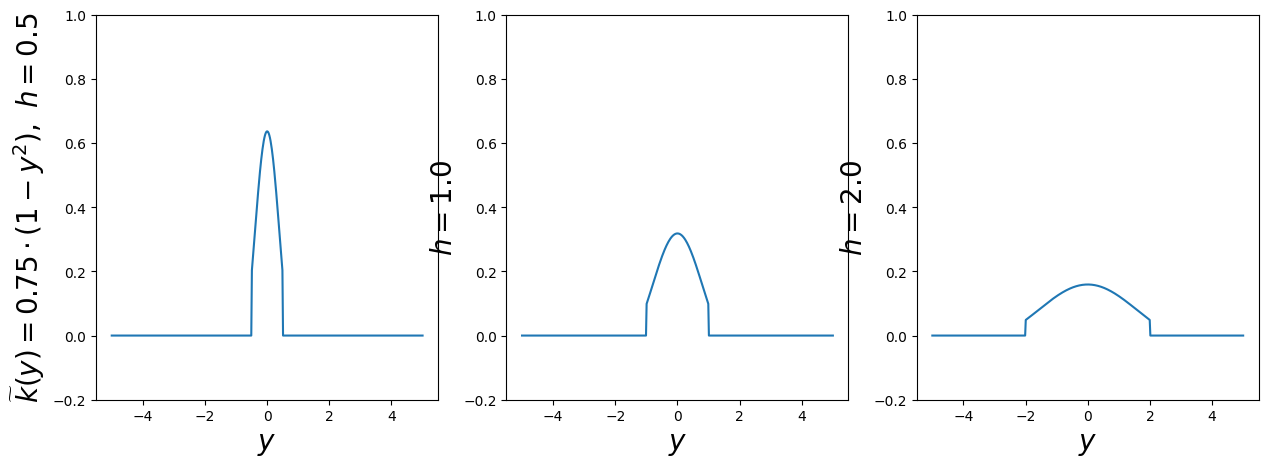

In [52]:
ypts = np.linspace(-5,5,500)
bandwidth = [0.5, 1, 2]
nband = len(bandwidth)
fig,ax = plt.subplots(1,3,figsize=(5*nband,5))
for ii in range(nband):
    ax[ii].plot(ypts,kernel_laog(ypts/bandwidth[ii])/bandwidth[ii])
    ax[ii].grid(False)
    ax[ii].set_ylim([-0.2, 1])
## commenting out below lines to avoid latex error
    ax[ii].set_xlabel(r'$y$',fontsize=20)
    if (ii == 0):
        ax[ii].set_ylabel(r'$\widetilde{k}(y) = 0.75 \cdot (1 - y^2), \ h = {%0.1f}$'%bandwidth[ii],fontsize=20)
    else:
        ax[ii].set_ylabel(r'$h = {%0.1f}$'%bandwidth[ii],fontsize=20)
# if savefigs:
#         fig.savefig(figpath+"kernel."+imgfrmt,format=imgfrmt)

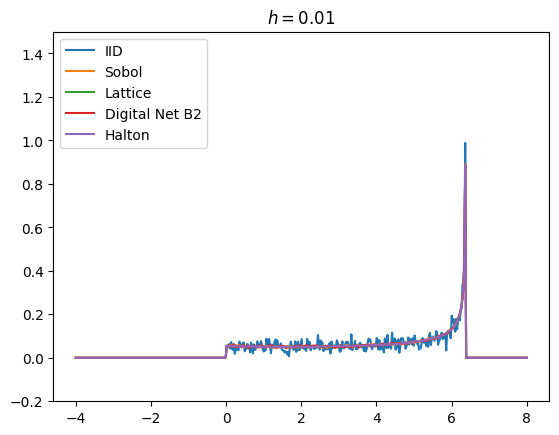

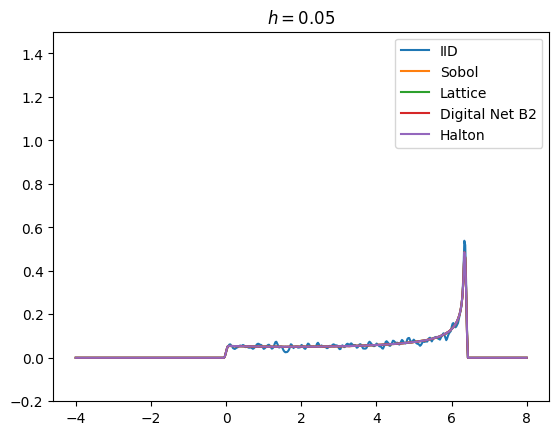

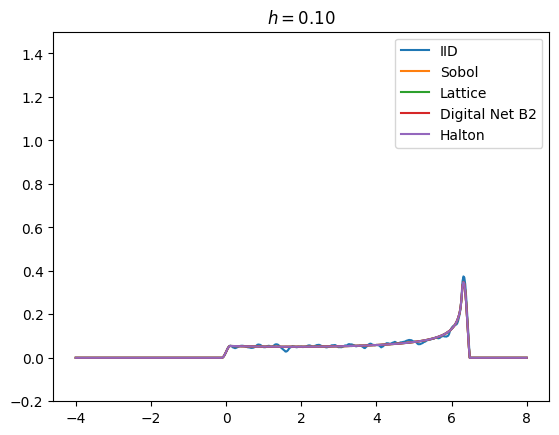

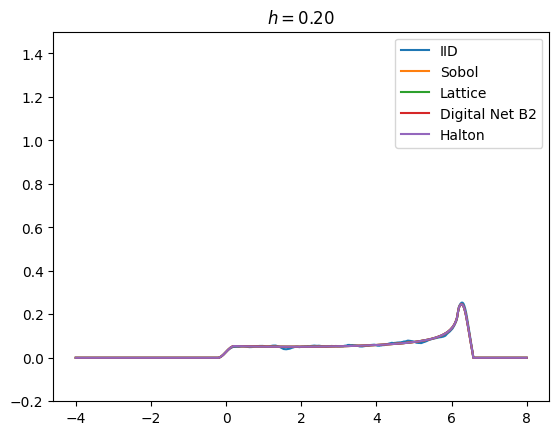

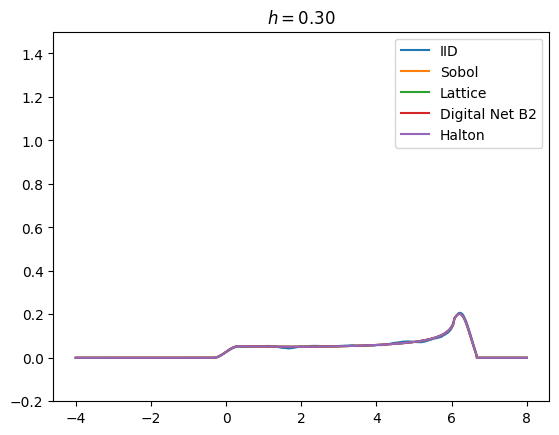

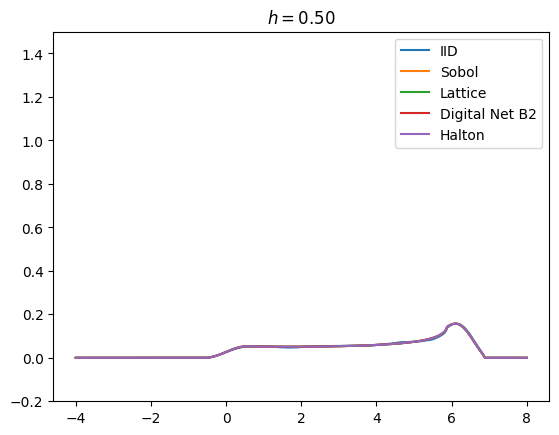

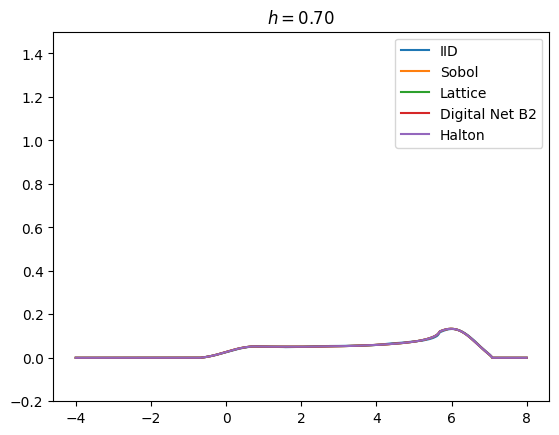

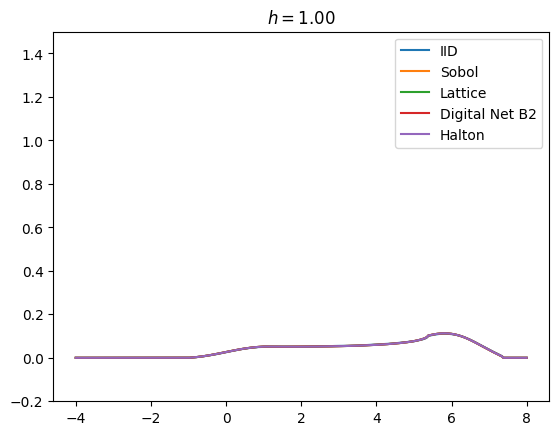

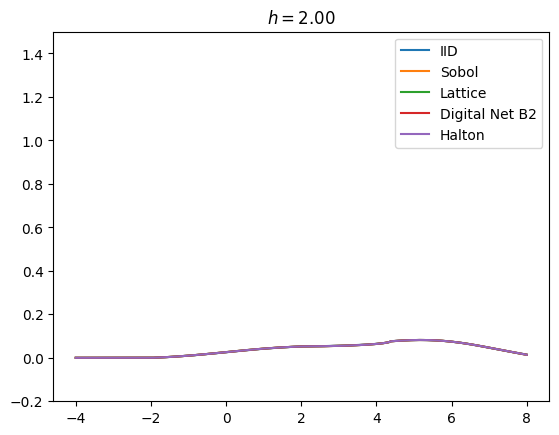

In [53]:
# dim = 1

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel_laog,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde(kernel_laog,ysob1,bandwidth[ii],yeval)
    rhovallattice = kde(kernel_laog,ylattice1,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel_laog,ydnetb21,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel_laog,yhalton1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.2, 1.5])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

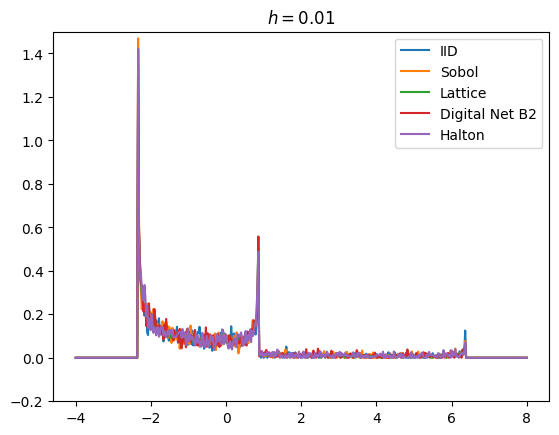

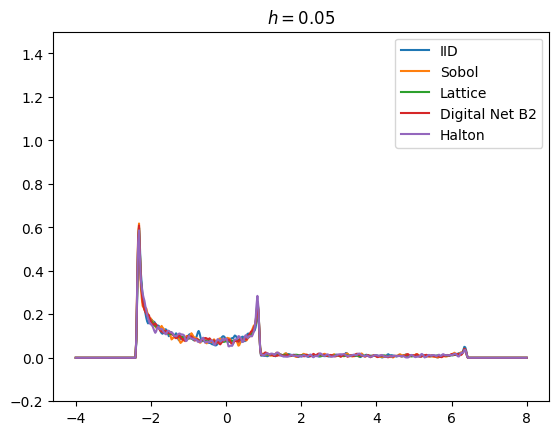

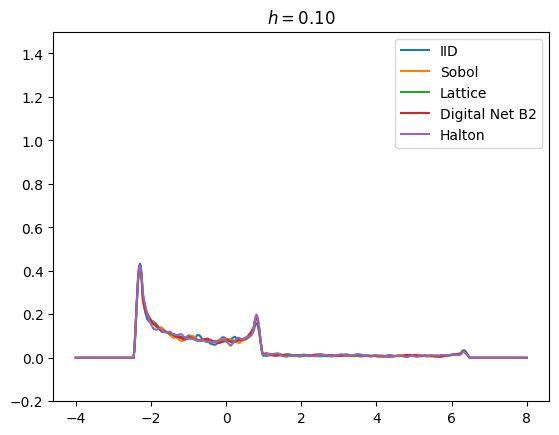

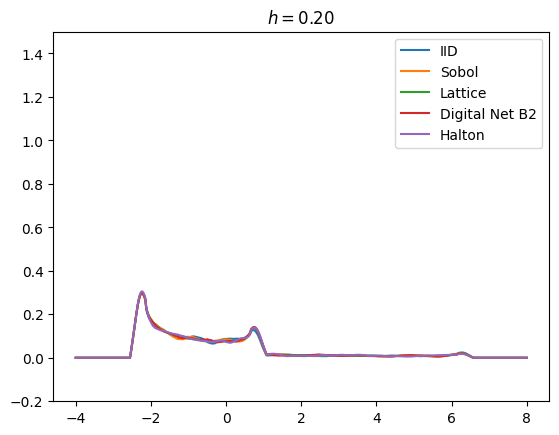

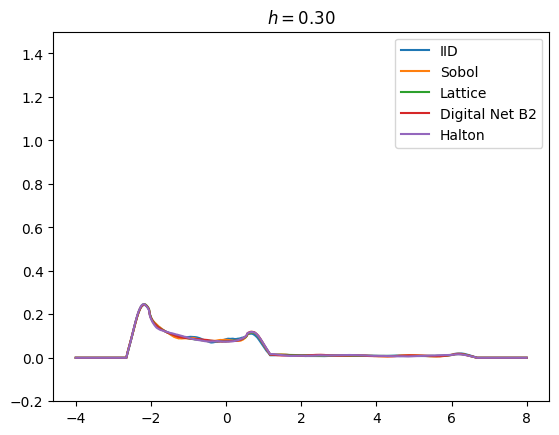

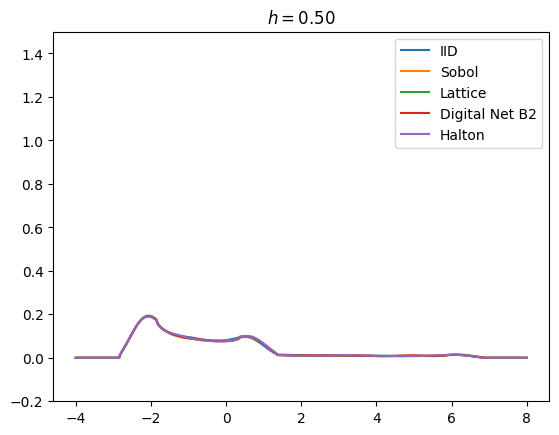

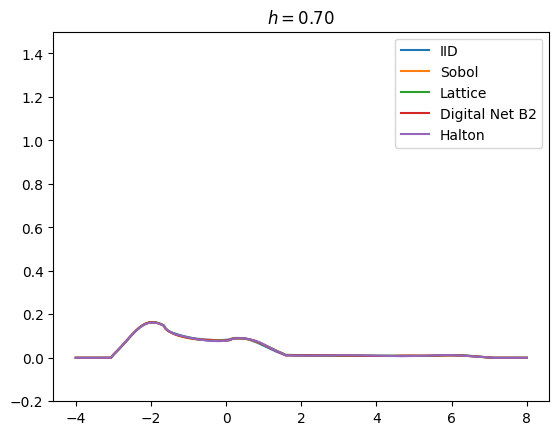

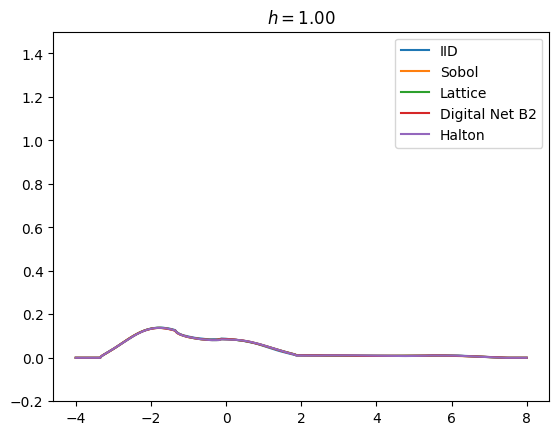

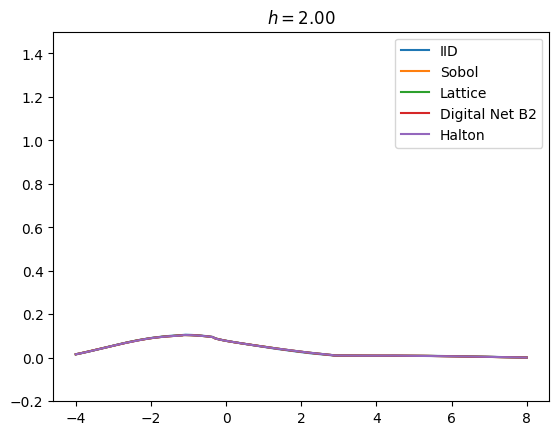

In [54]:
# dim = 3

bandwidth = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel_laog,yiid3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel_laog,ysob3,bandwidth[ii],yeval)
    rhovallattice = kde(kernel_laog,ylattice3,bandwidth[ii], yeval)
    rhovaldnetb2 = kde(kernel_laog,ydnetb23,bandwidth[ii],yeval)
    rhovalhalton = kde(kernel_laog,yhalton3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.plot(yeval,rhovallattice, label = "Lattice")
    ax.plot(yeval,rhovaldnetb2, label = "Digital Net B2")
    ax.plot(yeval,rhovalhalton, label = "Halton")
    ax.legend()
    ax.set_ylim([-0.2, 1.5])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

#### Hermite kernel--from Fred's KDE experiment notebook

In [55]:
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
def sy_hermite_kernel(y = sy.symbols('y', real = True), band_width = sy.symbols('h', positive = True), r = 1, only_coef = False):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel
    '''
    
#    import sympy as sy
    wt = sy.exp(-y*y) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
            # to hardcode the above line:
            # r = 0: intk[jj, ii] = (np.exp(-y**2))/((math.pi)**0.5)
            # r = 1: intk[jj, ii] = ((3-2*y**2)*np.exp(-y**2))/(2*(math.pi)**0.5)
            # r = 2: intk[jj, ii] = ((4*y**4 - 20*y**2 +15)*np.exp(-y**2))/(8*(math.pi)**0.5)
    tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1)) #the kernel should integrate to one, 
        #and the kernel integrated against y, y^2, ..., y^r should be zero
#    print(tot_int)
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
    if only_coef:
        return coef
    print(coef)
#    ktilde = coef.dot(k)
#    integk = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integk =',integk)
    ktilde = coef.dot(k.subs(y,y/band_width)/band_width) #form the isotropic kernel and insert the bandwidth dependency
#    integ = sy.integrate(ktilde,(y,-sy.oo,sy.oo))
#    print('integ =',integ)
#    print(band_width)
#    print(ktilde)
    return coef.dot(k.subs(y,y/band_width)/band_width)

In [ ]:
# hardcoding hermite kernel coefficients

def hermite_kernel(y, r):
    '''
    band_width = the kernel band width, often denoted h; a smaller bandwidth means a peakier kernel
    r = number of terms in our kernel (only for r = 0, 1, or 2)
    '''
    if r==0:
        return (np.exp(-y**2))/((math.pi)**0.5)
    elif r==1:
        return ((3-2*y**2)*np.exp(-y**2))/(2*(math.pi)**0.5)
    elif r==2:
        return ((4*y**4 - 20*y**2 +15)*np.exp(-y**2))/(8*(math.pi)**0.5)
    else:
        raise ValueError("Invalid input. r must be 0, 1, or 2.")

In [56]:
test_kernel_sy = sy_hermite_kernel(r=1) # r = number terms in kernel
print(type(test_kernel_sy))
print('kernel =',test_kernel_sy)
integ = sy.integrate(test_kernel_sy,(y,-sy.oo,sy.oo))
print('integ =',integ) # should be 1
test_kernel_sy = sy_hermite_kernel(r=2,only_coef = True)
print(test_kernel_sy)

Matrix([[1/sqrt(pi)]])
<class 'sympy.core.mul.Mul'>
kernel = exp(-y**2/h**2)/(sqrt(pi)*h)
integ = 1
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])


In [57]:
# smaller bandwidth = spikier kernel
# higher order = more accurate, but KDE might have negative values
h = sy.symbols('h', positive = True)
y = sy.symbols('y', real = True)
rarray = sy.Matrix([sy.Integer(1), sy.Integer(2), sy.Integer(3)])
nr = rarray.shape[0]

Matrix([[1/sqrt(pi)]])
ktilde = \frac{e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
ktilde = \frac{\left(\frac{3}{2} - y^{2}\right) e^{- y^{2}}}{\sqrt{\pi}}
Matrix([[1/sqrt(pi), -1/(4*sqrt(pi)), 1/(32*sqrt(pi))]])
ktilde = \frac{\left(4 y^{4} - 20 y^{2} + 15\right) e^{- y^{2}}}{8 \sqrt{\pi}}


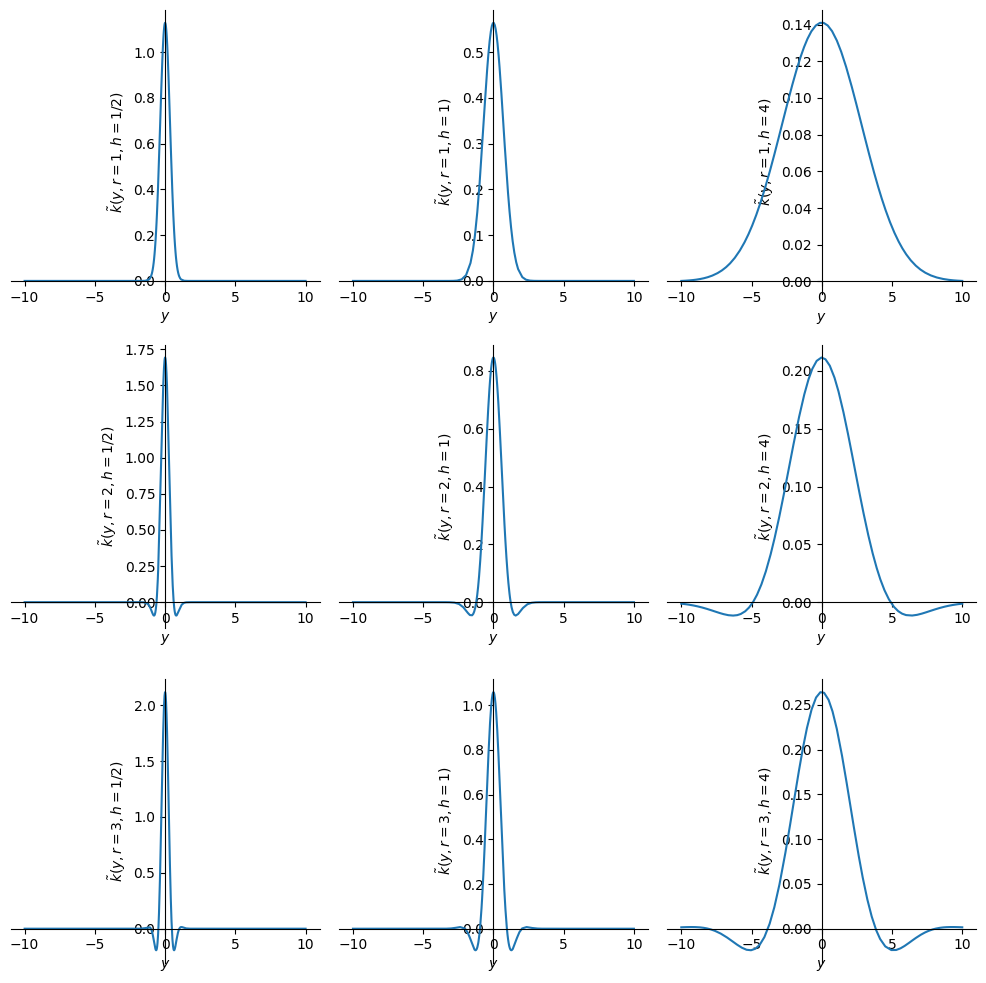

In [58]:
harray = sy.Matrix([sy.Rational(1/2), sy.Rational(1), sy.Rational(4)]) # Rational() returns rational form of value--diff. bandwidths
nh = harray.shape[0] # number of bandwidths
p = []; # plots
for rr in range(nr):
    rval = rarray[rr]
    ktilde_sy = sy.simplify(sy_hermite_kernel(y,h,rval))
    print('ktilde =',sy.latex(ktilde_sy.subs(h,1)))
    for hh in range(nh):
        hval = harray[hh]
        p.append(sy.plot(ktilde_sy.subs(h,hval),ylabel = r'$\tilde k(y,r='+str(rval)+',h='+str(hval)+')$', show = False))
sy.plotting.PlotGrid(nr,nh, *p, size = (10,10));

In [59]:
def kde_hermite(kernel,ypts,bandwidth,yeval):
    neval = len(yeval)
    rhoval = np.zeros_like(yeval) #values of density estimator
    for ii in range(len(yeval)):
        rhoval[ii] = np.mean(kernel((yeval[ii]-ypts)/bandwidth))/bandwidth
    return rhoval

In [60]:
# define hermite kernel for r = 1
def hermite_kernel(y, r = 1):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0)
    # print(poly)
    k = sp.special.hermite(0)(y)*coef[0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [61]:
# example hermite kernel
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hermite_kernel(y)
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
k = [0.342198280312217 0.546831294919853 0.497895559951388 0.258304813712196
 0.0763547570885822]


In [ ]:
# trying r = 2
def hermite_kernel_2(y, r = 2):
    '''
    r = number of terms in our kernel
    '''
    coef = np.array(sy.N(sy_hermite_kernel(r = r, only_coef = True)))
    # print(coef)
    poly = sp.special.hermite(0) # why use the 0th polynomial?
    # print(poly)
    # for i in range(len(coef[0])):
    #     print(coef[0][i])
    k = sp.special.hermite(0)(y)*coef[0][0] #initialize a vector of kernel values
    # print(k)
    for ii in range(1,r):
        k += sp.special.hermite(2*ii)(y)*coef[0][ii] #add the additional terms
    k*=np.exp(-y*y/2) #normalizing weight for Hermite functions #form the isotropic kernel and insert the bandwidth dependency
    return k

In [ ]:
print(sp.special.hermite(0))
print(sp.special.hermite(1))
print(sp.special.hermite(2))
print(sp.special.hermite(3))

 
1
 
2 x
   2
4 x - 2
   3
8 x - 12 x


In [ ]:
# example hermite kernel when r = 2
y = np.linspace(-1,2,5)
print('y =',y)
print(type(y))
k = hermite_kernel_2(y)
print('k =',k)

y = [-1.   -0.25  0.5   1.25  2.  ]
<class 'numpy.ndarray'>
k = [0.171099140156108 0.786069986447289 0.622369449939235 -0.0161440508570123
 -0.190886892721455]


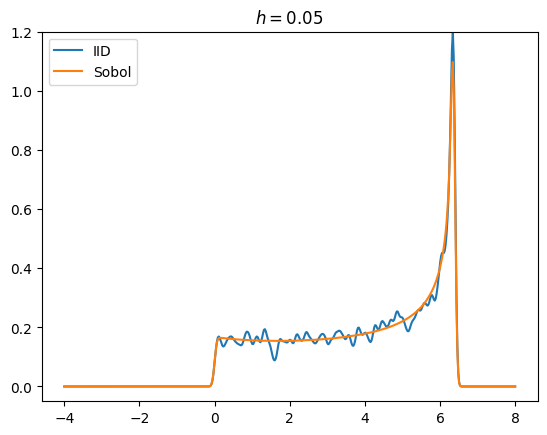

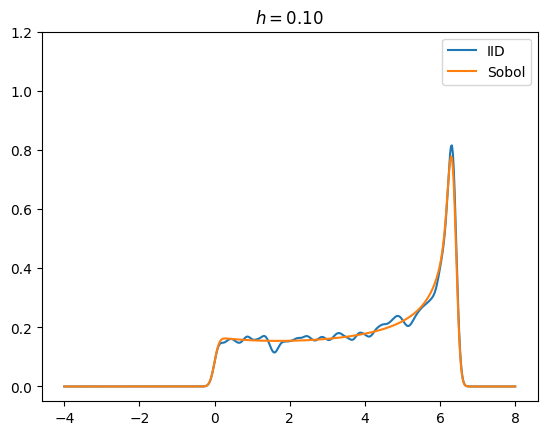

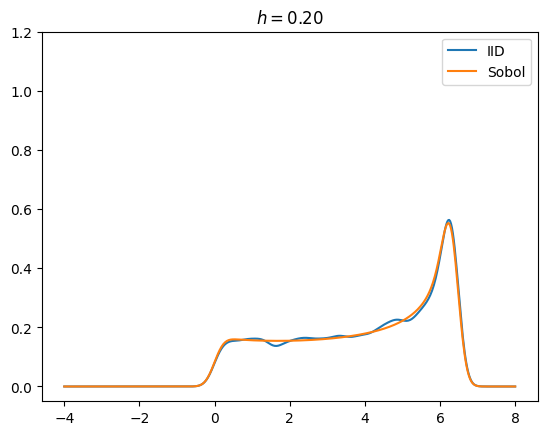

In [63]:
# dim = 1, r = 1
## hermite kernel takes much longer--why?
## how do graphs look?
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
rval = 2
for ii in range(nband):
    rhovaliid = kde_hermite(hermite_kernel,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde_hermite(hermite_kernel,ysob1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

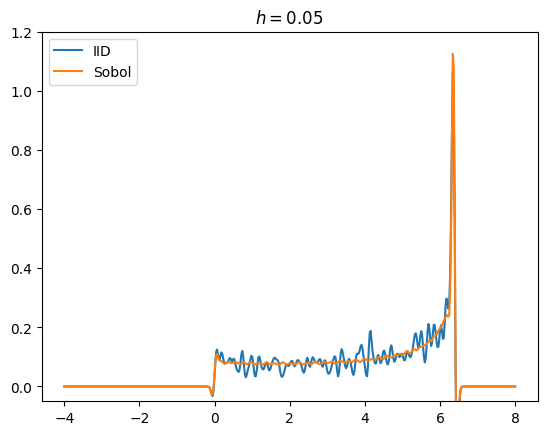

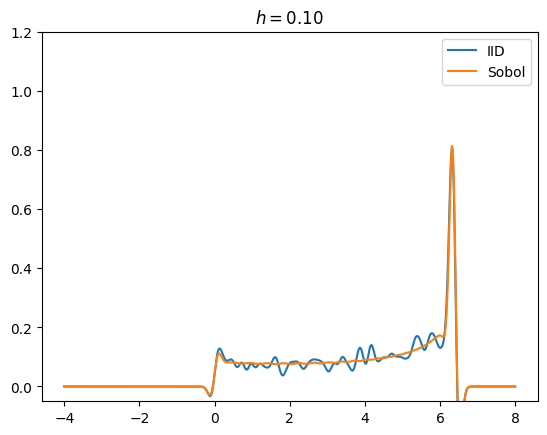

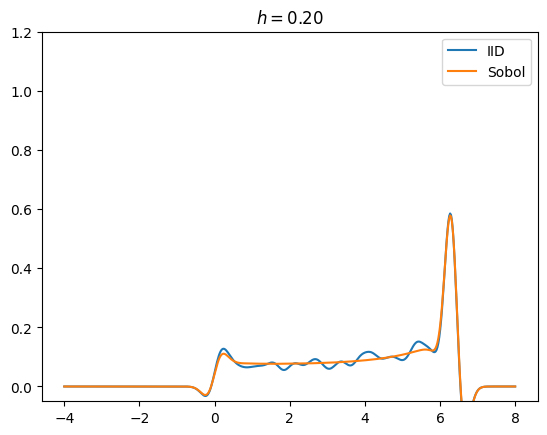

In [ ]:
# dim = 1, r = 2
## hermite kernel takes much longer--why?
## how do graphs look?
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
rval = 2
for ii in range(nband):
    rhovaliid = kde_hermite(hermite_kernel_2,yiid1,bandwidth[ii],yeval)
    rhovalsob = kde_hermite(hermite_kernel_2,ysob1,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 ...
 0.564189583547756 0.564189583547756 0.564189583547756]
[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 ...
 0.564189583547756 0.564189583547756 0.564189583547756]
[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 ...
 0.564189583547756 0.564189583547756 0.564189583547756]
[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 ...
 0.564189583547756 0.564189583547756 0.564189583547756]
[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 ...
 0.564189583547756 0.564189583547756 0.564189583547756]
[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 ...
 0.564189583547756 0.564189583547756 0.564189583547756]
[[0.564189583547756]]
 
1
[0.564189583547756 0.564189583547756 0.564189583547756 ...
 0.564189583547756 0.564189583547756 0.564189583547756]
[[0.564189583

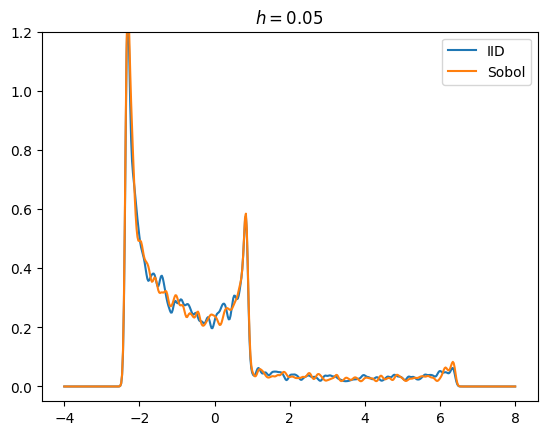

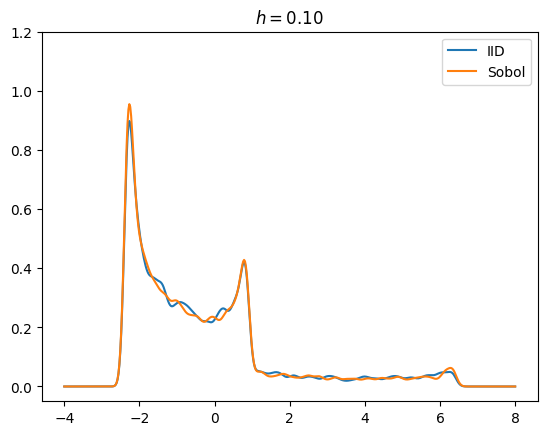

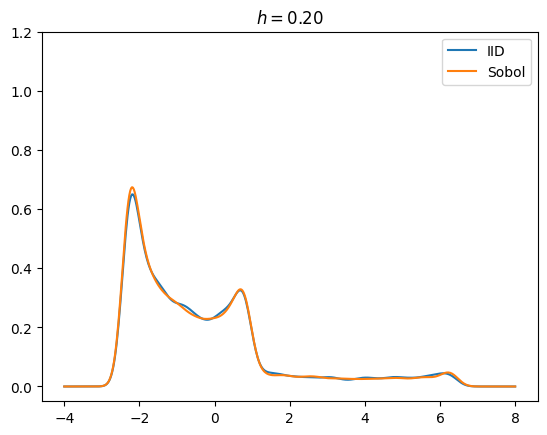

In [42]:
# dim = 3, r = 1
## hermite kernel takes much longer
## the graphs look pretty much the same compared to when we use the gaussian kernel when r = 1
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
rval = 1
for ii in range(nband):
    rhovaliid = kde_hermite(hermite_kernel,yiid3,bandwidth[ii],yeval)
    rhovalsob = kde_hermite(hermite_kernel,ysob3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

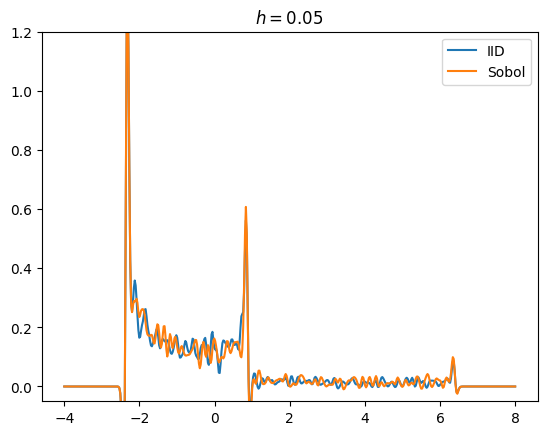

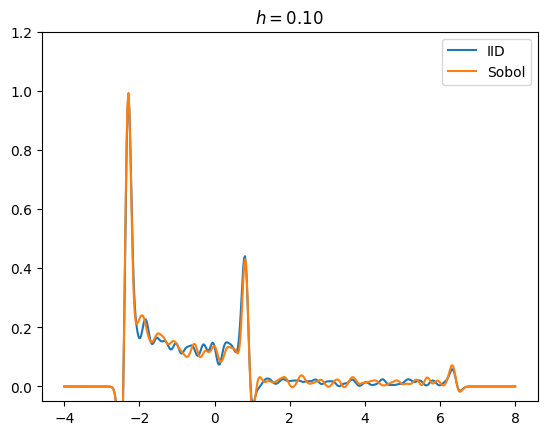

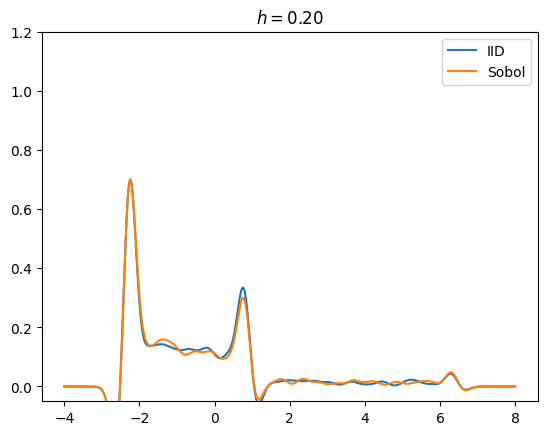

In [59]:
# dim = 3, r = 2
## hermite kernel takes much longer--why?
## how do graphs look?
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
rval = 2
for ii in range(nband):
    rhovaliid = kde_hermite(hermite_kernel_2,yiid3,bandwidth[ii],yeval)
    rhovalsob = kde_hermite(hermite_kernel_2,ysob3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1.2])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    if savefigs:
        fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

##### Profiling/timing hermite kernel (see why it's taking so long, breaking down sy_hermite_kernel function)

In [140]:
import time

In [141]:
t1 = time.perf_counter(), time.process_time()
sy_hermite_kernel(r=1)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

Matrix([[1/sqrt(pi)]])
 Real time: 0.07 seconds
 CPU time: 0.05 seconds


In [142]:
t1 = time.perf_counter(), time.process_time()
sy_hermite_kernel(r=2)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

Matrix([[1/sqrt(pi), -1/(4*sqrt(pi))]])
 Real time: 0.17 seconds
 CPU time: 0.02 seconds


In [147]:
bandwidth = 0.1
yeval = np.linspace(-4,8,10)
t1 = time.perf_counter(), time.process_time()
kde(kernel,yiid1,bandwidth,yeval)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

 Real time: 0.00 seconds
 CPU time: 0.00 seconds


In [149]:
bandwidth = 0.1
yeval = np.linspace(-4,8,10)
t1 = time.perf_counter(), time.process_time()
kde_hermite(hermite_kernel_2,yiid1,bandwidth,yeval)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

 Real time: 13.94 seconds
 CPU time: 1.66 seconds


In [150]:
t1 = time.perf_counter(), time.process_time()
y = sy.symbols('y', real = True)
# h = sy.symbols('h', positive = True)
wt = sy.exp(-y*y) #normalizing weight for Hermite functions
sy.hermite(2,y)*wt #form the bases
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

 Real time: 0.00 seconds
 CPU time: 0.00 seconds


In [153]:
t1 = time.perf_counter(), time.process_time()
y = sy.symbols('y', real = True)
# h = sy.symbols('h', positive = True)
k = sy.zeros(1,1) #initialize a vector of bases that make up the kernel
wt = sy.exp(-y*y) #normalizing weight for Hermite functions
sy.hermite(2,y)*wt #form the bases
sy.integrate(k[0]*(y**(2*1)),(y,-sy.oo,sy.oo))
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

 Real time: 0.00 seconds
 CPU time: 0.00 seconds


In [154]:
t1 = time.perf_counter(), time.process_time()
sy.Matrix.vstack(sy.ones(1,1),sy.zeros(1-1,1))
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

 Real time: 0.00 seconds
 CPU time: 0.00 seconds


In [155]:
y = sy.symbols('y', real = True)
h = sy.symbols('h', positive = True)
r = 1
wt = sy.exp(-y*y) #normalizing weight for Hermite functions
k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
for ii in range(r):
    k[ii] = sy.hermite(2*ii,y)*wt #form the bases
    for jj in range(r):
        intk[jj,ii] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals against even degree monomials
tot_int = sy.Matrix.vstack(sy.ones(1,1),sy.zeros(r-1,1))

t1 = time.perf_counter(), time.process_time()
sy.Matrix(list(sy.linsolve((intk,tot_int))))
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

 Real time: 0.00 seconds
 CPU time: 0.00 seconds


In [156]:
coef = sy.Matrix(list(sy.linsolve((intk,tot_int))))
band_width = 0.1

t1 = time.perf_counter(), time.process_time()
coef.dot(k.subs(y,y/band_width)/band_width)
t2 = time.perf_counter(), time.process_time()
print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

 Real time: 0.01 seconds
 CPU time: 0.00 seconds


#### Testing different functions for f(x)--exponential, laplace (still in progress)
- https://en.wikipedia.org/wiki/Exponential_distribution
- https://en.wikipedia.org/wiki/Laplace_distribution

In [64]:
## exponential, lambda = 1:
# def testfun_exp(x,coord_wts = 1): # function f(x) defines the random variable
#     wtx = np.multiply(x,coord_wts)
#     y = -np.log(1-wtx)
#     return y

In [78]:
# exponential, lambda = 1, but without the subtraction inside the ln():
def testfun_exp(x,coord_wts = 1): # function f(x) defines the random variable
    wtx = np.multiply(x,coord_wts)
    y = -np.log(wtx)
    return y

In [79]:
yiid1_exp = testfun_exp(iidpts1)
ysob1_exp = testfun_exp(sobpts1)

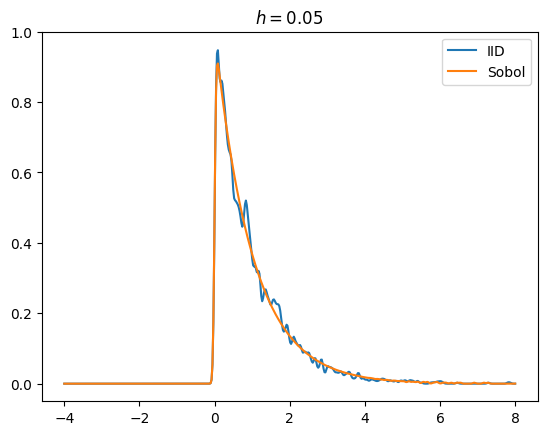

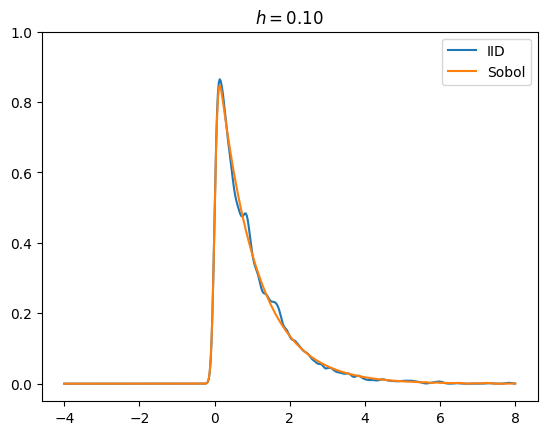

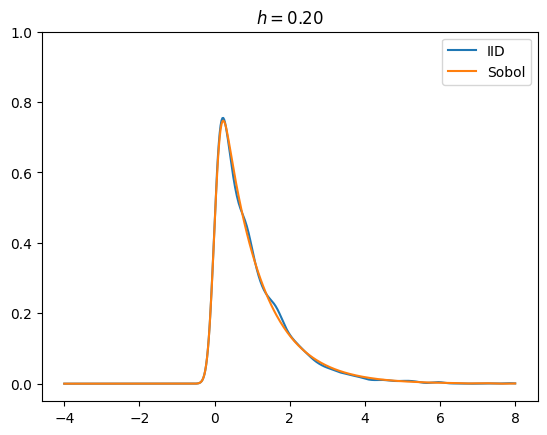

In [80]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid1_exp,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob1_exp,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

In [81]:
yiid3_exp = testfun_exp(iidpts3)
ysob3_exp = testfun_exp(sobpts3)

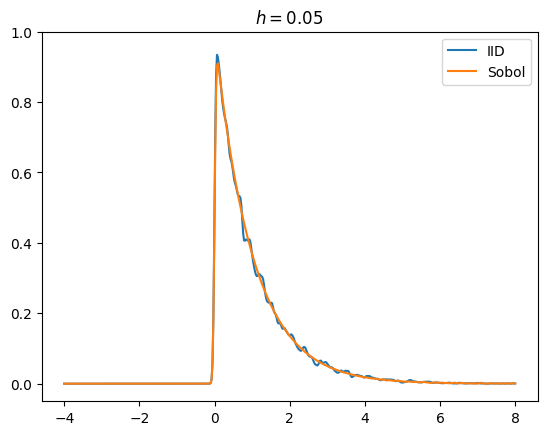

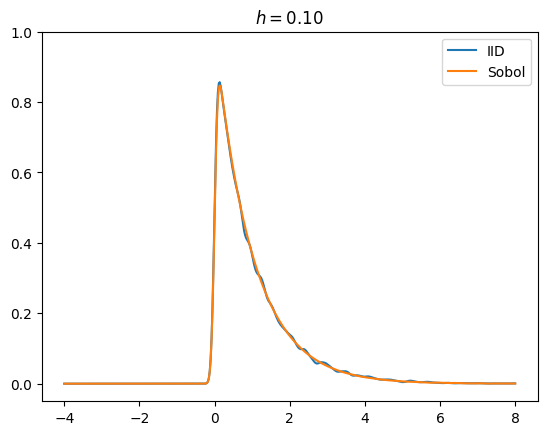

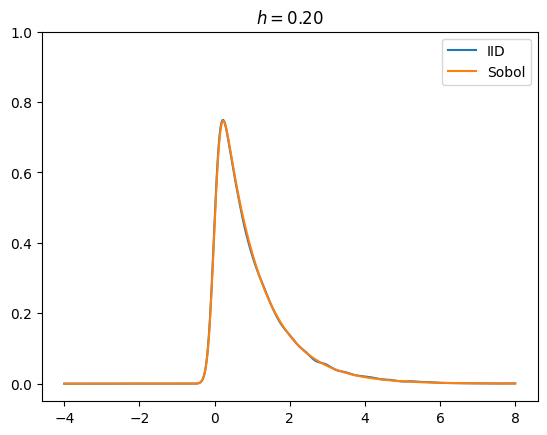

In [82]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid3_exp,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob3_exp,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 1])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

In [1]:
## laplace: mu = 0, b = 1
def testfun_laplace(x1,x2,coord_wts = 1): # function f(x) defines the random variable
    wtx1 = np.multiply(x1,coord_wts)
    wtx2 = np.multiply(x2,coord_wts)
    y = np.log10(wtx1/wtx2)
    return y

In [179]:
# making a second set of iid and sobol points
d = 1
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts1_2 = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts1_2)
wtiidpts1_2 = np.multiply(iidpts1_2,coord_wts)
print(wtiidpts1_2)
sobpts1_2 = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts1_2)

iid pts [[0.75913957]
 [0.88310839]
 [0.79631425]
 ...
 [0.41754125]
 [0.64438361]
 [0.16807597]]
[[0.75913957]
 [0.88310839]
 [0.79631425]
 ...
 [0.41754125]
 [0.64438361]
 [0.16807597]]
sobol pts [[0.46026772]
 [0.99407713]
 [0.13005973]
 ...
 [0.76922819]
 [0.10883223]
 [0.56426432]]


In [180]:
yiid_laplace = testfun_laplace(iidpts1, iidpts1_2) 
ysob_laplace = testfun_laplace(sobpts1, sobpts1_2)

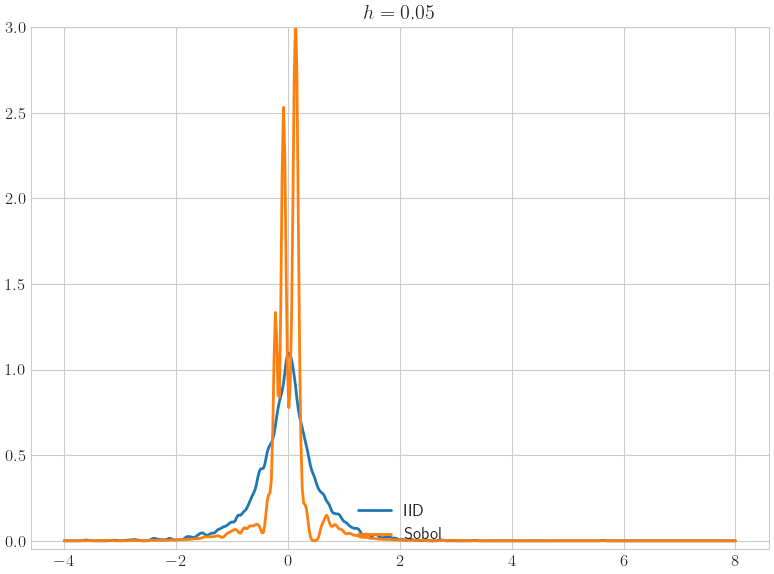

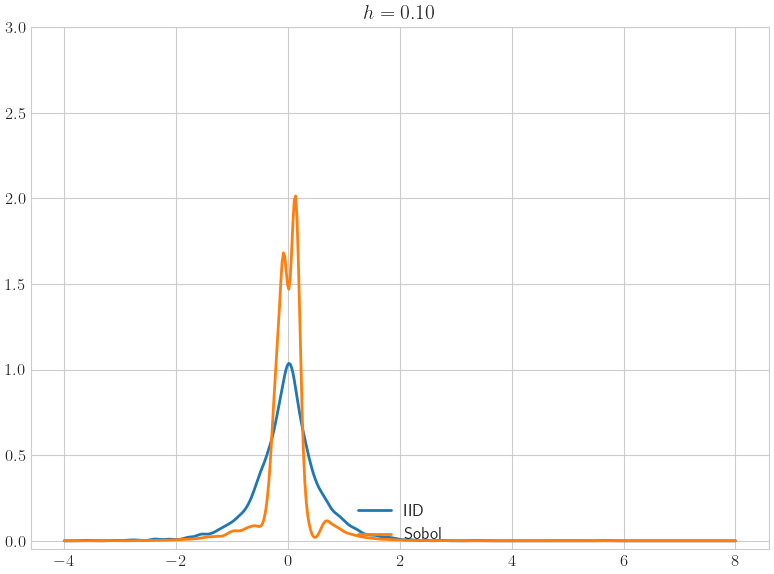

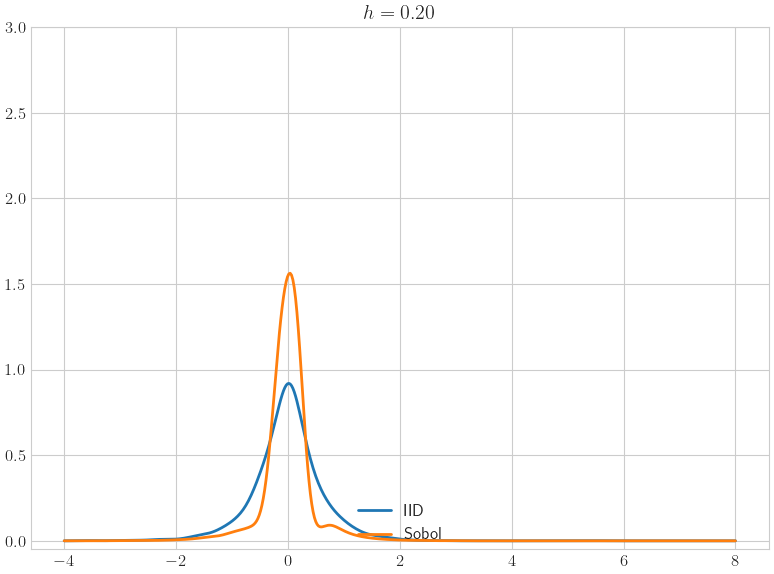

In [182]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid_laplace,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob_laplace,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 3])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)

In [183]:
d = 3
coord_wts = 2.**(-np.array(range(0,d)))
n = 2**12
iidpts3_2 = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts3_2)
wtiidpts3_2 = np.multiply(iidpts3_2,coord_wts)
print(wtiidpts3_2)
sobpts3_2 = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts3_2)

iid pts [[0.50146103 0.41800052 0.45326276]
 [0.23383911 0.66512026 0.1315121 ]
 [0.95797197 0.76360443 0.52118716]
 ...
 [0.63716814 0.23931089 0.73514248]
 [0.23057058 0.94870452 0.37937888]
 [0.40436722 0.95199338 0.14058925]]
[[0.50146103 0.20900026 0.11331569]
 [0.23383911 0.33256013 0.03287802]
 [0.95797197 0.38180221 0.13029679]
 ...
 [0.63716814 0.11965544 0.18378562]
 [0.23057058 0.47435226 0.09484472]
 [0.40436722 0.47599669 0.03514731]]
sobol pts [[0.76014776 0.72433071 0.09409247]
 [0.06446911 0.03109159 0.8140411 ]
 [0.74253688 0.4994748  0.71144727]
 ...
 [0.2443476  0.38084082 0.7130907 ]
 [0.562904   0.09898008 0.81556006]
 [0.25785058 0.65550047 0.09658847]]


In [184]:
yiid_laplace_3 = testfun_laplace(iidpts3, iidpts3_2) 
ysob_laplace_3 = testfun_laplace(sobpts3, sobpts3_2)

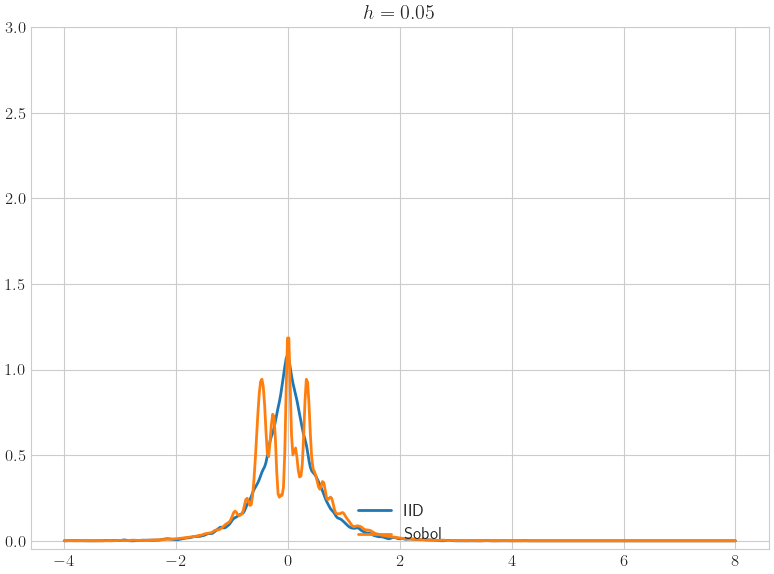

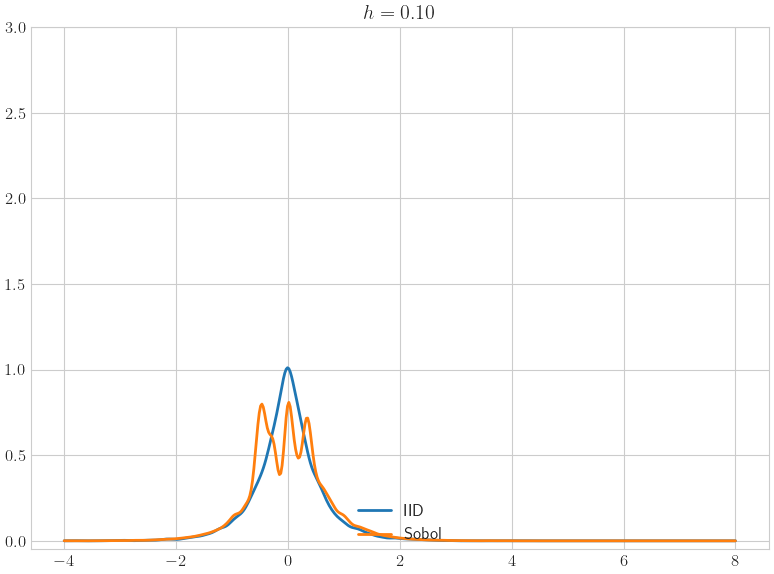

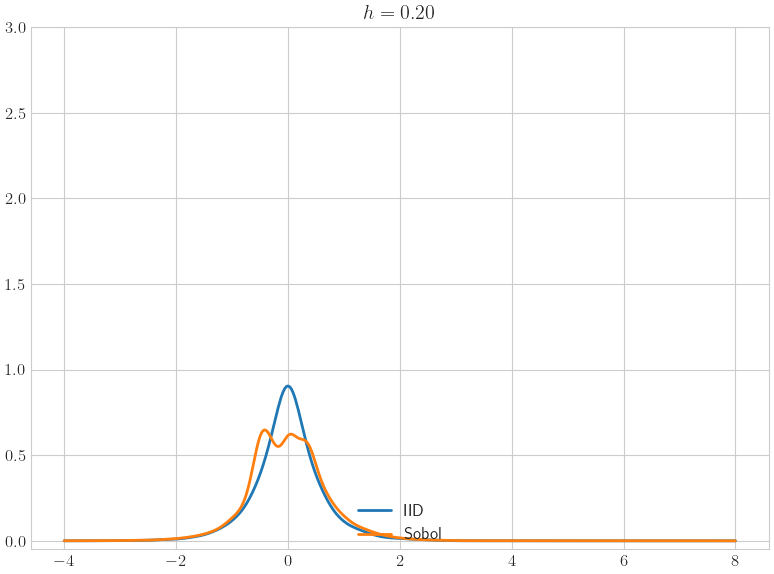

In [185]:
bandwidth = [0.05, 0.1, 0.2]
nband = len(bandwidth)
yeval = np.linspace(-4,8,500)
for ii in range(nband):
    rhovaliid = kde(kernel,yiid_laplace_3,bandwidth[ii],yeval)
    rhovalsob = kde(kernel,ysob_laplace_3,bandwidth[ii],yeval)
    fig,ax = plt.subplots()
    ax.plot(yeval,rhovaliid, label = "IID")
    ax.plot(yeval,rhovalsob, label = "Sobol")
    ax.legend()
    ax.set_ylim([-0.05, 3])
    ax.set_title(f"$h = {bandwidth[ii]:.2f}$")
    # if savefigs:
    #     fig.savefig(figpath+f"{n:.0f}kde_h{bandwidth[ii]:.2f}."+imgfrmt,format=imgfrmt)